# Αναφορά για την 3η εργαστηριακή άσκηση

#### Ομάδα : Α18
#### Ανδρεάς Καλογεράς (03114822)
#### Χρήστος Λούρας (03114037)

In [186]:
from deap import base, tools, creator, algorithms
import numpy as np
import pandas as pd
import math 
import joblib
import random
from numpy import arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
from time import time
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt

## Κοινός κώδικας και για τα 2 μέρη
# Initialize Statistics Object
def init_stat_object():
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    return stats

# function for returning evals, mins , successes, etc
def gather_info(logbooks, times, DELTA):
    successes = 0
    suc_avg_gens, suc_avg_min, suc_avg_evals, evals, mins = [], [], [], [], []
    for lb in logbooks:
        # Number of evaluations
        nevals = sum(lb.select('nevals'))
        evals.append(nevals)
        # Best min in the logbook
        minimum = np.amin(lb.select('min'))
        mins.append(minimum)
        # check if success
        # το GOAL είνα global variable που αρχικοποιείται στην αρχή κάθε ενότητας
        if minimum <= GOAL+DELTA:
            successes = successes + 1
            first_succ = -1
            first_succ_elem = 0
            for index, elem in enumerate(lb.select('min')):
                if elem <= GOAL+DELTA:
                    first_succ = index
                    first_succ_elem = elem
                    break       
            # index of first_succ -> first generation with succesfull minimum
            suc_avg_gens.append(first_succ+1)
            suc_avg_min.append(first_succ_elem)
            suc_avg_evals.append(sum(lb.select('nevals')[:(first_succ + 1)]))       
    if successes == 0:
        # no mimimum below threshold for success
        s_gens, s_avg_min, s_avg_evals = None, None, None
    else:
        s_gens, s_avg_min, s_avg_evals = int(np.mean(suc_avg_gens)), np.mean(suc_avg_min), int(np.mean(suc_avg_evals))   
    return [successes, s_avg_min, s_avg_evals, s_gens, int(np.mean(evals)), np.mean(mins), np.mean(times)]


# Creates a DATAFRAME from the infos crated by gather_info()
# if n_dfs > 0, then creates an array of dataframes
# if sec_part == True, create dataframes for the second part of exercise
# if sec_part == True ,it MUST be n_dfs = 
# if thr_part == True, create dataframes for the optimization of the scalable func
def to_df(all_infos, n_dfs, sec_part=False, thr_part=False):
    columns_1 = ['operators', 'strategy', 'successes', 's.avg.min', 
               's.avg.evals', 's.avg.gens', 'avg.evals', 'avg.min', 'avg.time']
    columns_2 = ['Dimensions', 'successes', 's.avg.min', 's.avg.evals', 
                 's.avg.gens', 'avg.evals', 'avg.min', 'avg.time']
    columns_3 = ['Dimensions','Population', 'successes', 's.avg.min', 's.avg.evals', 
                 's.avg.gens', 'avg.evals', 'avg.min', 'avg.time']
    if n_dfs == 0:
        # final df
        df = pd.DataFrame(all_infos)
        if sec_part:
            df.columns = columns_2
            df.drop('s.avg.min', axis=1, inplace=True)
            df.drop('s.avg.gens', axis=1, inplace=True)
            df.drop('s.avg.evals', axis=1, inplace=True)
        elif thr_part:
            df.columns = columns_3
            #df.drop('s.avg.min', axis=1, inplace=True)
            #df.drop('s.avg.gens', axis=1, inplace=True)
            #df.drop('s.avg.evals', axis=1, inplace=True)
        else:
            df.columns = columns_1
    else:
        # during selecting operators, strategy, etc
        df = []
        for i in range(0,n_dfs):
            df1 = pd.DataFrame(all_infos[i])
            df1.columns = columns
            df.append(df1)
    return df

# Shows the results of the execution of the genetic algorithms
# can show data in a sorted way or not
# default -> non-sorted
def show_results(infos, sort=False, sec_part=False, thr_part=False):
    table = to_df(infos, 0, sec_part, thr_part)
    if sort:
        table.sort_values(["successes", "avg.min"] , inplace=True, ascending=[False, True])
    # pd.set_option('display.max_rows', 15)
    display(table)


def Simple(tb_comp, n_pop, gens, CX, MUT):
    stats = init_stat_object()
    start_time = time()
    toolbox = create_toolbox(*tb_comp)
    pop = toolbox.population(n=n_pop)
    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=CX, mutpb=MUT,
                                       ngen=gens, stats=stats, verbose=False)
    total_time = time() - start_time    
    return logbook, total_time


def M_plus_L(tb_comp, n_pop, gens, M, L, CX, MUT):
    stats = init_stat_object()
    start_time = time()
    toolbox = create_toolbox(*tb_comp)
    pop = toolbox.population(n=n_pop)
    pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, cxpb=CX, mutpb=MUT, mu=M, lambda_=L,
                              ngen=gens, stats=stats, verbose=False)
    total_time = time() - start_time
    return logbook, total_time


def M_comma_L(tb_comp, n_pop, gens, M, L, CX, MUT):
    stats = init_stat_object()
    start_time = time()
    toolbox = create_toolbox(*tb_comp)
    pop = toolbox.population(n=n_pop)
    pop, logbook = algorithms.eaMuCommaLambda(pop, toolbox, cxpb=CX, mutpb=MUT, mu=M, lambda_=L,
                               ngen=gens, stats=stats, verbose=False)
    total_time = time() - start_time
    return logbook, total_time

# runs parrallel n_rounds of simple algorithm
def run_rounds_simple(toolbox, n_pop, n_rounds, gens, CX, MUT, deltas, parallel=False):
    if parallel: cpus = -1
    else: cpus = 1
    logbooks = []
    times = []
    outputs = joblib.Parallel(n_jobs=cpus)(
            joblib.delayed(Simple)(toolbox, n_pop, gens, CX, MUT) for _ in range(0, n_rounds))
    # Split logbook, times from output
    for output in outputs:
        logbooks.append(output[0])
        times.append(output[1])
    infos = []
    for delta in deltas:
        infos.append(gather_info(logbooks, times, delta))
    return infos


# runs parrallel n_rounds of m_plus_l algorithm
def run_rounds_m_plus_l(toolbox, n_pop, n_rounds, gens, M, L, CX, MUT, deltas, parallel=False):
    if parallel: cpus = -1
    else: cpus = 1
    logbooks = []
    times = []
    outputs = joblib.Parallel(n_jobs=cpus)(
            joblib.delayed(M_plus_L)(toolbox, n_pop, gens,  M, L, CX, MUT) for _ in range(0, n_rounds))
    # Split logbook, times from output
    for output in outputs:
        logbooks.append(output[0])
        times.append(output[1])
    infos = []
    for delta in deltas:
        infos.append(gather_info(logbooks, times, delta))
    return infos

# runs parrallel n_rounds of m_comma_l algorithm
def run_rounds_m_comma_l(toolbox, n_pop, n_rounds, gens, M, L, CX, MUT, deltas, parallel=False):
    if parallel: cpus = -1
    else: cpus = 1
    logbooks = []
    times = []
    outputs = joblib.Parallel(n_jobs=cpus)(
        joblib.delayed(M_comma_L)(toolbox, n_pop, gens,  M, L, CX, MUT) for _ in range(0, n_rounds))
    # Split logbook, times from output
    for output in outputs:
        logbooks.append(output[0])
        times.append(output[1])
    infos = []
    for delta in deltas:
        infos.append(gather_info(logbooks, times, delta))
    return infos

# Η συνάρτηση που εκτελεί τον γενετικό αλγόριθμο με τις παραμέτρους και τους συνδυασμούς που επιθυμούμε.
# Είναι παραμμετροποιήσιμη όσον αφορά τον συνδυασμό των τελεστών-αλγορίθμου, το gridsearch για τις πιθανότητες cx, mut
# γίνεται από την fine_tuning()
# Δίνει ως έξοδο μία λίστα όπου κάθε στοιχείο της αντιστοιχεί στα αντίστοιχα αποτελέσματα για δεδομένα DELTA
# Δηλαδή αν ενδιαφερόμαστε για τιμές για 4 διαφορετικά delta, η λίστα αυτή θα έχει 4 στοιχεία
# Κάθε στοιχείο στην συνέχεια μπορεί μέσω της show_results() να μετατραπεί σε DataFrame και να παρουσιαστεί
# με παρόμοιο format με αυτό του πίνακα της εκφώνησης
def run_ga(numVariables, rounds, pop, gens, cx_pb, mut_pb, mu, l, opers_algs, deltas):
    # infos for all delta
    all_infos = []
    for delta in deltas:
        all_infos.append([])
    for cr_op in opers_algs[0]:
        for mut_op in opers_algs[1]:
            for sel_op in opers_algs[2]:
                tb_comps = (cr_op, mut_op, sel_op, numVariables)
                for alg in opers_algs[3]:
                    if alg == "eaSimple":
                        # string with operators and strategy
                        OPs_Str= [("%s, %s, %s" % (cr_op, mut_op, sel_op)), 
                                  ("%s %d %.2f %.2f" % (alg, pop, cx_pb, mut_pb))]
                        # run Simple algorithm for MAX_ROUNDS and return the necesary stats
                        print(OPs_Str)
                        infos = run_rounds_simple(tb_comps, pop, rounds, gens, cx_pb,
                                                  mut_pb, deltas, parallel=True)
                        # Save necessary info for each delta
                        for i in range(0,len(deltas)):
                            all_infos[i].append(OPs_Str+infos[i])
                    elif alg == "eaMuPLusLambda":
                        # string with operators and strategy
                        OPs_Str= [("%s, %s, %s" % (cr_op, mut_op, sel_op)), 
                                  ("%s %d %d %.2f %.2f" % (alg, mu, l, cx_pb, mut_pb))]
                        print(OPs_Str)
                        infos = run_rounds_m_plus_l(tb_comps, pop, rounds, gens, mu, l, 
                                                    cx_pb, mut_pb, deltas, parallel=True)
                        # Save necessary info for each delta
                        for i in range(0,len(deltas)):
                            all_infos[i].append(OPs_Str+infos[i])
                    elif alg == "eaMuCommaLambda":
                        # string with operators and strategy
                        OPs_Str= [("%s, %s, %s" % (cr_op, mut_op, sel_op)), 
                                  ("%s %d %d %.2f %.2f" % (alg, mu, l, cx_pb, mut_pb))]
                        print(OPs_Str)
                        infos = run_rounds_m_comma_l(tb_comps, pop, rounds, gens, mu, l,
                                                     cx_pb, mut_pb, deltas, parallel=True)
                        # Save necessary info for each delta
                        for i in range(0,len(deltas)):
                            all_infos[i].append(OPs_Str+infos[i])
    return all_infos

# Wrapper function for run_ga(), show_results()
# Επιστρέφει ότι και η run_ga() σε περίπτωση που τα χρειαζόμαστε ή θέλουμε να τα αποθηκέυσουμε
def run_ga_and_show_results(numVariables, rounds, pop, gens, cx_pb, mut_pb,
                            mu, l, opers_algs, deltas, sort=False):
    all_infos = run_ga(numVariables, rounds, pop, gens, cx_pb, mut_pb,
                       mu, l, opers_algs, deltas)
    for i in range(0, len(deltas)):
        print("DELTA = %f:" % deltas[i])
        #print(all_infos[i])
        show_results(all_infos[i], sort)
    return all_infos

# Εκτελεί την gridsearch για τις πιθανότητες διαστάυρωσης και μετάλλαξης
# Μπορεί να δοκιμάσει διαφορετικές δυνατότητες για παραπάνω από έναν συνδυασμό τελεστών-αλγορίθμου
# Είναι παρόμοιας λογικής με την run_ga()
def fine_tuning(numVariables, best_comb_ls, pop, rounds, gens, mu, l, cx_pbs, mut_pbs, deltas):
    all_infos = []
    for delta in deltas:
        all_infos.append([])
    for comp in best_comb_ls:
        toolbox = (comp[0], comp[1], comp[2], numVariables)
        for cx_pb in cx_pbs:
            for mut_pb in mut_pbs:
                if cx_pb+mut_pb > 1.0:
                    break
                if comp[3] == "eaSimple":
                    # string with operators and strategy
                    OPs_Str= [("%s, %s, %s" % (comp[0], comp[1], comp[2])), 
                              ("%s %d %.2f %.2f" % (comp[3], pop, cx_pb, mut_pb))]
                    # run Simple algorithm for MAX_ROUNDS and return the necesary stats
                    print(OPs_Str)
                    infos = run_rounds_simple(toolbox, pop, rounds, gens, cx_pb,
                                              mut_pb, deltas, parallel=True)
                    # Save necessary info for each delta
                    for i in range(0,len(deltas)):
                        all_infos[i].append(OPs_Str+infos[i])
                elif comp[3] == "eaMuPLusLambda":
                    # string with operators and strategy
                    OPs_Str= [("%s, %s, %s" % (comp[0], comp[1], comp[2])), 
                              ("%s %d %d %.2f %.2f" % (comp[3], mu, l, cx_pb, mut_pb))]
                    print(OPs_Str)
                    infos = run_rounds_m_plus_l(toolbox, pop, rounds, gens, mu, l, 
                                                cx_pb, mut_pb, deltas, parallel=True)
                    # Save necessary info for each delta
                    for i in range(0,len(deltas)):
                        all_infos[i].append(OPs_Str+infos[i])
                elif comp[3] == "eaMuCommaLambda":
                    # string with operators and strategy
                    OPs_Str= [("%s, %s, %s" % (comp[0], comp[1], comp[2])), 
                              ("%s %d %d %.2f %.2f" % (comp[3], mu, l, cx_pb, mut_pb))]
                    print(OPs_Str)
                    infos = run_rounds_m_comma_l(toolbox, pop, rounds, gens, mu, l,
                                                 cx_pb, mut_pb, deltas, parallel=True)
                    # Save necessary info for each delta
                    for i in range(0,len(deltas)):
                        all_infos[i].append(OPs_Str+infos[i])
    return all_infos

# Τρέχει την run_ga() rounds φορές και κρατά για κάθε γύρο τους 5 καλύτερους συνδυασμούς
# Στην συνέχεια υπολογίζει την συχνότητα παρουσίας κάθε συνδυασμού στην πρώτη πεντάδα
# Επιστρέφει αυτούς με την μεγαύτερη συχνότητα
def get_5_best(DELTA, rounds=10):
    indexes = []
    infos = []
    for i in range(0,rounds):
        info = run_ga(numVariables=nVars, rounds=MAX_ROUNDS, gens=MAX_GENS, pop=POP,
                      cx_pb=CX, mut_pb=MUT, mu=M, l=L, opers_algs=OPs_ALGs, deltas=[DELTA])
        infos.append(info)
        df = to_df(info[0], 0)
        # sort dataframe and keep only first 5 rows
        df.sort_values(["successes", "s.avg.gens"] , inplace=True, ascending=[False, True])
        ind = list(df.index)
        indexes.extend(ind[:5])
    ind = np.array(indexes)
    unique, counts = np.unique(ind, return_counts=True)
    a = np.asarray((unique, counts)).T
    print(a)
    b = a[a[:,1].argsort()[::-1]]
    print(b)
    best =  b[:5, 0]
    print(best)
    for i in range(0, 5):
        print(infos[0][0][best[i]][0]," ", infos[0][0][best[i]][1],"  with freq=",b[i][1])
    return infos 

**Επεξήγηση μεταβλητών που χρησιμοποιούνται:**   
1. **nVar** -> Διάστασεις  
2. **MAX_ROUNDS** -> Γύροι  
3. **POP** -> Αρχικός πληθυσμός  
4. **MAX_GENS** -> γενιές  
5. **GOAL** -> στόχος της ελαχιστοποίησης  
6. **DELTA** -> Ανεκτό offset από το Goal  
Ο πίνακας DELTAS αποθηκεύει πολλές διαφορετικές τιμές για το DELTA. Η τιμή αυτή δεν επηρρεάζει την έξοδο του GA (logbook), απλά μέσω αυτού υπολογίζουμε για >1 τιμές DELTA τα αντίστοιχα ζητούμενα. Επίσης το πλήθος των DELTA δεν πορσθέτει κάποιο σημαντικό overhead διότι οι υπολογισμοί είναι αρκετά λιγότερο χρονοβόροι σε σχέση με αυτούς των γενετικών αλγορίθμων.
7. **CX** -> Πιθανότητα διαστάυρωσης  
8. **MUT** -> Πιθανότητα μετάλλαξης    
9. **M** -> mu για τους "m+l", "m,l" αλγόριθμους  
10. **L** -> lambda για τους "m+l", "m,l" αλγόριθμους 
11. **OPs_ALGs** -> λίστα με λίστες για κάθε operator, αλγόριθμο που θα ληφθεί υπόψιν

**Σημείωση:**
1. Πέρα απο τον παραπάνω κώδικα κάποιες συναρτήσεις που είναι ειδικές για κάθε πρόβλημα ακολουθούν στο αντίστοιχο τμήμα παρακάτω. Αυτές είναι οι συναρτήσεις για το "evaluate", τον έλεγχο των άκρων, και το toolbox, διότι χρησιμοποιούμε διαφορετικούς τελεστές με διαφορετικές υπερπαραμέτρους και διαφορετικές συναρτήσεις decorators.

2. Σε ξεχωριστό tarball έχουμε όλα τα pkl files που αποθηκευσάμε κατά την διάρκεια της εργασίας. Αν χρειαστεί να τρέξετε κάποιο σχετικό κελό τοποθετήστε το αντίστοιχο pkl file στο ίδιο directory με το notebook.

**!!ΣΗΜΑΝΤΙΚΟ!!:** Για να μην έχουμε αρκετά if-clause ή και διπλές συναρτήσεις για τον ίδιο σκοπό (μία για κάθε συνάρτηση) αναγκαστικά η συνάρτηση create_toolbox() υπάρχει 2 φορές. Οπότε, πριν την εκτέλεση οποιουδήποτε κώδικα ,πχ ενός κελιού για την 1η συνάρτηση, πρέπει να εκτελεστεί το κελί με την αντίστοιχη create_toolbox().

## Μέρος 1. Μελέτη μη-κλιμακούμενης συνάρτησης

Η συνάρτηση που αντιστοιχούσε στην ομάδα μας είναι η:
$$f(x_1, x_2) = 2x_1^2-1.05x_1^4+x_1^6/6+x_1x_2+x_2^2$$

$$-5<=x_i<=5$$

Της οποίας η γραφική παράσταση υπολογίζεται και αναπαρίσταται από τον παρακάτω κώδικα:

*Ακολουθεί ο κώδικας που είναι ειδικός για το πρόβλημα της μη κλιμακούμενης συνάρτησης:*

In [187]:
def y(x1,x2): 
    return 2*pow(x1,2)- 1.05*pow(x1,4) +pow(x1,6)/6 +x1*x2 +pow(x2,2)

In [190]:
def evalFunc1( individual ):
    return (y(individual[0],individual[1]),)

# Dimensions
numVariables = 2
# Initialize global vars
GOAL = 0.0

def checkBounds1(min, max):
    def decorator(func):
        def wrapper(*args, **kargs):
            offspring = func(*args, **kargs)
            for child in offspring:
                for i in range(0,len(child)):
                    if child[i] > max:
                        child[i] = max
                    elif child[i] < min:
                        child[i] = min
            return offspring
        return wrapper
    return decorator


# Function returns the GA algorithm
def create_toolbox(cross_op, mutate_op, sel_op, numVariables):
    # Initialize objects like creator, etc
    # Single criteria optimization (minimization of f)
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("IndividualContainer", list, fitness=creator.FitnessMin)
    # Create Toolbox object 
    toolbox = base.Toolbox()
    # Create population
    toolbox.register("InitialValue", np.random.uniform, -5.0, 5.0)
    toolbox.register("individual", tools.initRepeat, creator.IndividualContainer, toolbox.InitialValue, numVariables)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    # Choose crossover operator
    if cross_op == "cxBlendHigh":
        toolbox.register("mate", tools.cxBlend, alpha=0.7)
    elif cross_op == "cxBlendLow":
        toolbox.register("mate", tools.cxBlend, alpha=0.2)
    elif cross_op == "cxUniformHigh":
        toolbox.register("mate", tools.cxUniform, indpb=0.7)
    elif cross_op == "cxUniformLow":
        toolbox.register("mate", tools.cxUniform, indpb=0.2)
    # Choose mutate operator
    if mutate_op == "mutGaussianHigh":
        toolbox.register("mutate", tools.mutGaussian, mu = 0, sigma=1.0, indpb=0.7)
    elif mutate_op == "mutGaussianLow":
        toolbox.register("mutate", tools.mutGaussian, mu = 0, sigma=1.0, indpb=0.2)
    elif mutate_op == "mutShuffleIndexesHigh":
        toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.7)
    elif mutate_op == "mutShuffleIndexesLow":
        toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.2)
    # registering auxilliary functions for checking bounds
    toolbox.decorate("mate", checkBounds1(-5.0, 5.0))
    toolbox.decorate("mutate", checkBounds1(-5.0, 5.0))
    # SelTournament
    if sel_op == "selTournamentHigh":
        toolbox.register("select", tools.selTournament, tournsize=10)
    elif sel_op == "selTournamentLow": 
        toolbox.register("select", tools.selTournament, tournsize=3)
    # Evaluate function is evalFunc
    toolbox.register("evaluate", evalFunc1)
    return toolbox

### Γράφημα

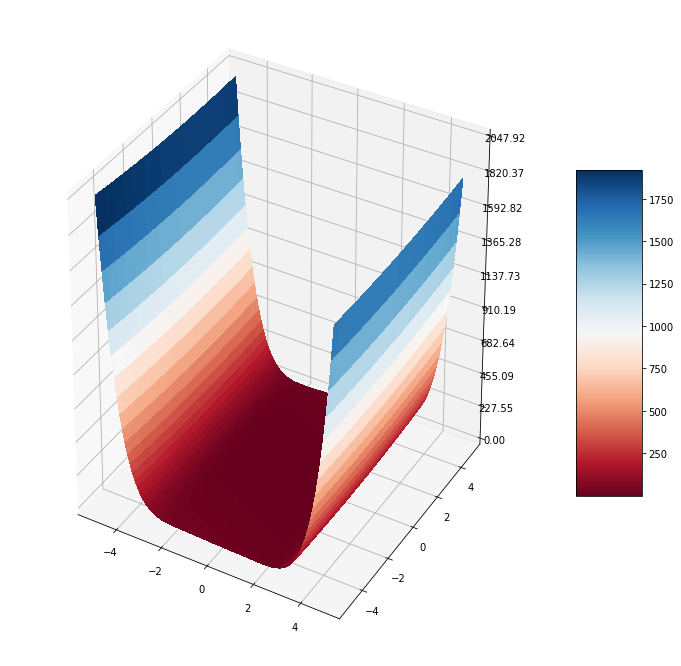

In [189]:
x1 = arange(-5.0,5.0,0.1)
x2 = arange(-5.0,5.0,0.1)
X,Y = meshgrid(x1,x2)
Z = y(X,Y)

fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, 
                      cmap=cm.RdBu,linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

Παρατηρώντας το γράφημα, βλέπουμε ότι η απεικόνιση της δοθείσας συνάρτησης είναι μία "κοιλάδα" η οποία παρουσιάζει ολικό ελάχιστο το 0 στο σημείο (0,0). Παρατηρούμε επίσης πως δεν μπορούμε να διακρίνουμε εύκολα το ολικό ελάχστο καθώς η καμπύλη πλησιάζει πολύ απότομα στο 0, κάτι που θα παίξει καθοριστικό ρόλο στην άσκηση καθώς όπως θα δουμε, για DELTA = 0 δε θα έχουμε καμία επιτυχία, με κανέναν συνδυασμό.

Δοκιμάσαμε τους εξής τελεστές διασταύρωσης:

**cxBlend**, όπου θέσαμε υψηλή και χαμηλή τιμή της υπερπαραμέτρου indpb(μοναδική υπερπαράμετρος του τελεστή) 0.7 και 0.2 αντίστοιχα. (Η στρατηγική Blend αναμειγνύει τα στοιχεία των 2 γονέων με τυχαίο τρόπο και τα μεταβιβάζει στην τούπλα του απογόνου).

**cxUniform**, όπου θέσαμε υψηλή και χαμηλή τιμή της υπερπαραμέτρου indpb(και εδώ μοναδική υπερπαράμετρος) 0.7 και 0.2 αντίστοιχα. (Η στρατηγική Uniform κατα τη διάρκεια της διασταύρωσης "ανταλλάσσει" στοιχεία μεταξύ των 2 "γονέων" τα οποία μεταφέρονται στην τούπλα του "απογόνου". Το πώς κατανέμεται αυτη η "ανταλλαγή" και η "κληρονόμηση", εξαρτάται από την υπερμαράμετρο indpb(που μας δείχνει την πιθανότητα "ανταλλαγής" για κάθε "γονέα").


Όσον αφορά τους τελεστές μετάλλαξης, επιλέξαμε μετά απο δοκιμή διάφορων άλλων, τους εξής δύο:

**muGaussian**, όπου θέσαμε την υπερπαράμετρο sigma (η τυπική απόκλιση του τελεστή) ίση με 1 και υψηλή/χαμηλή τιμή της indpb = 0.7/0.2  αντίστοιχα. (Η στρατηγική Gaussian χρησιμοποιείται προκειμένου το ποσοστό των μεταλλάξεων να ακολουθήσει την κανονική κατανομή(Gauss), τα χαρακτηριστικά της οποίας(μέση τιμη και τυπική απόκλιση) τα ορίζουμε εμείς. Τέλος εμπεριέχει και την υπερπαράμετρο indpb, με την οποία ορίζουμε την πιθανότητα μετάλλαξης του κάθε attribute του ατόμου.)

**muShuffleIndexes**, όπου θέσαμε υψηλή και χαμηλή τιμή της υπερπαραμέτρου indpb(μοναδική υπερπαράμετρος) 0.7 και 0.2 αντίστοιχα. (Η στρατηγική ShuffleIndexes αναμειγνύει τα χαρακτηριστικά της τούπλας(ατόμου) και έτσι προκύπτει ο mutant. Η υπερπαράμετρος indpb μας δείχνει την πιθανότητα ένα χαρακτηριστικό του ατόμου να ανταλλαχθεί με κάποιο άλλο της τούπλας.

Να σημειώσουμε εδώ ότι δεν πήραμε ακραίες τιμές στις υπερπαραμέτρους, καθώς θα είχαμε μη επιθυμητά αποτελέσματα εξ'αρχής(με πολύ μεγάλο indpb θα παίρναμε αποκλειστικά μεταλλαγμένα άτομα, ενώ με πολύ μικρό indpb, σχεδόν καθόλου.)

In [120]:
nVars = 2
POP = 40
MAX_ROUNDS = 20
MAX_GENS = 50
CX, MUT = 0.5, 0.2
M, L = 40, 50

OPs_ALGs = [["cxBlendHigh", "cxBlendLow", "cxUniformHigh", "cxUniformLow"], # crossover operators
            ["mutGaussianHigh", "mutGaussianLow", "mutShuffleIndexesHigh", "mutShuffleIndexesLow"], # mutate_operators
            ["selTournamentHigh", "selTournamentLow"], # selection operators
            ["eaSimple", "eaMuPLusLambda", "eaMuCommaLambda"] # Algorithms
           ]

Όσον αφορά το DELTA, πειραματιστήκαμε με τιμές γύρω από τις αρνητικές δυνάμεις του 10. Παρατηρήσαμε ότι όσο πιο μικρό το DELTA, τόσο λιγότερα τα successes ανά διάφορους τελεστές και τόσο πιο πολύ "ξεχώριζαν" οι καλύτεροι συνδυασμοί. Παρόλα αυτά, διακρίναμε πως από ένα σημείο και μετά, υπάρχει ένας κορεσμός όσον αφορά τα αποτελέσματα, και καταλήξαμε όπως θα δούμε παρακάτω με την τιμή DELTA = 0.0001, καθώς όπως θα δούμε, είναι η μόνη τιμή η οποία έχει έναν μοναδικό συνδυασμό που έχει 100% επιτυχία(20 στα 20 successes δηλαδή).

In [121]:
#DELTAS = [0, 0.1, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001, 0.000000001]
DELTAS = [0]+[round(10**(-x), x) for x in range(1, 9)]
all_infos = run_ga_and_show_results(numVariables=nVars, rounds=MAX_ROUNDS, gens=MAX_GENS, pop=POP,
               cx_pb=CX, mut_pb=MUT, mu=M, l=L, 
               opers_algs=OPs_ALGs, deltas=DELTAS, sort=True)
joblib.dump(all_infos,"all_infosS01R10POP40_3.pkl")

['cxBlendHigh, mutGaussianHigh, selTournamentHigh', 'eaSimple 40 0.50 0.20']
['cxBlendHigh, mutGaussianHigh, selTournamentHigh', 'eaMuPLusLambda 40 50 0.50 0.20']
['cxBlendHigh, mutGaussianHigh, selTournamentHigh', 'eaMuCommaLambda 40 50 0.50 0.20']
['cxBlendHigh, mutGaussianHigh, selTournamentLow', 'eaSimple 40 0.50 0.20']
['cxBlendHigh, mutGaussianHigh, selTournamentLow', 'eaMuPLusLambda 40 50 0.50 0.20']
['cxBlendHigh, mutGaussianHigh, selTournamentLow', 'eaMuCommaLambda 40 50 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentHigh', 'eaSimple 40 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentHigh', 'eaMuPLusLambda 40 50 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentHigh', 'eaMuCommaLambda 40 50 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentLow', 'eaSimple 40 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentLow', 'eaMuPLusLambda 40 50 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentLow', 'eaMuCommaLambda 40 50 0.50 0.20']
['cxBlendHig

DELTA = 0.000000000000000000000000000000000000000000:


operators  \
0     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
1     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
2     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
3      cxBlendHigh, mutGaussianHigh, selTournamentLow   
4      cxBlendHigh, mutGaussianHigh, selTournamentLow   
5      cxBlendHigh, mutGaussianHigh, selTournamentLow   
6      cxBlendHigh, mutGaussianLow, selTournamentHigh   
7      cxBlendHigh, mutGaussianLow, selTournamentHigh   
8      cxBlendHigh, mutGaussianLow, selTournamentHigh   
9       cxBlendHigh, mutGaussianLow, selTournamentLow   
10      cxBlendHigh, mutGaussianLow, selTournamentLow   
11      cxBlendHigh, mutGaussianLow, selTournamentLow   
12  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
13  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
14  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
15  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
16  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
17  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
18  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
19  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
20  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
21  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
22  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
23  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
24     cxBlendLow, mutGaussianHigh, selTournamentHigh   
25     cxBlendLow, mutGaussianHigh, selTournamentHigh   
26     cxBlendLow, mutGaussianHigh, selTournamentHigh   
27      cxBlendLow, mutGaussianHigh, selTournamentLow   
28      cxBlendLow, mutGaussianHigh, selTournamentLow   
29      cxBlendLow, mutGaussianHigh, selTournamentLow   
30      cxBlendLow, mutGaussianLow, selTournamentHigh   
31      cxBlendLow, mutGaussianLow, selTournamentHigh   
32      cxBlendLow, mutGaussianLow, selTournamentHigh   
33       cxBlendLow, mutGaussianLow, selTournamentLow   
34       cxBlendLow, mutGaussianLow, selTournamentLow   
35       cxBlendLow, mutGaussianLow, selTournamentLow   
36  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
37  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
38  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
39  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
40  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
41  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
42  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
43  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
44  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
45  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
46  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
47  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
48  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
49  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
50  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
51   cxUniformHigh, mutGaussianHigh, selTournamentLow   
52   cxUniformHigh, mutGaussianHigh, selTournamentLow   
53   cxUniformHigh, mutGaussianHigh, selTournamentLow   
54   cxUniformHigh, mutGaussianLow, selTournamentHigh   
55   cxUniformHigh, mutGaussianLow, selTournamentHigh   
56   cxUniformHigh, mutGaussianLow, selTournamentHigh   
57    cxUniformHigh, mutGaussianLow, selTournamentLow   
58    cxUniformHigh, mutGaussianLow, selTournamentLow   
59    cxUniformHigh, mutGaussianLow, selTournamentLow   
60  cxUniformHigh, mutShuffleIndexesHigh, selTourn...   
61  cxUniformHigh, mutShuffleIndexesHigh, selTourn...   
62  cxUniformHigh, mutShuffleIndexesHigh, selTourn...   
63  cxUniformHigh, mutShuffleIndexesHigh, selTourn...   
64  cxUniformHigh, mutShuffleIndexesHigh, selTourn...   
65  cxUniformHigh, mutShuffleIndexesHigh, selTourn...   
66  cxUniformHigh, mutShuffleIndexesLow, selTourna...   
67  cxUniformHigh, mutShuffleIndexesLow, selTourna...   
68  cxUniformHigh, mutShuffleIndexesLow, selTourna...   
69  cxUniformHigh, mutShuffleIndexesLow, selTourna... 

DELTA = 0.100000000000000005551115123125782702118158:


operators  \
1     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
4      cxBlendHigh, mutGaussianHigh, selTournamentLow   
25     cxBlendLow, mutGaussianHigh, selTournamentHigh   
26     cxBlendLow, mutGaussianHigh, selTournamentHigh   
35       cxBlendLow, mutGaussianLow, selTournamentLow   
39  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
41  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
47  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
0     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
5      cxBlendHigh, mutGaussianHigh, selTournamentLow   
10      cxBlendHigh, mutGaussianLow, selTournamentLow   
27      cxBlendLow, mutGaussianHigh, selTournamentLow   
46  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
3      cxBlendHigh, mutGaussianHigh, selTournamentLow   
15  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
23  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
24     cxBlendLow, mutGaussianHigh, selTournamentHigh   
48  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
2     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
28      cxBlendLow, mutGaussianHigh, selTournamentLow   
29      cxBlendLow, mutGaussianHigh, selTournamentLow   
74   cxUniformLow, mutGaussianHigh, selTournamentHigh   
75    cxUniformLow, mutGaussianHigh, selTournamentLow   
49  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
72   cxUniformLow, mutGaussianHigh, selTournamentHigh   
73   cxUniformLow, mutGaussianHigh, selTournamentHigh   
76    cxUniformLow, mutGaussianHigh, selTournamentLow   
50  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
51   cxUniformHigh, mutGaussianHigh, selTournamentLow   
52   cxUniformHigh, mutGaussianHigh, selTournamentLow   
53   cxUniformHigh, mutGaussianHigh, selTournamentLow   
77    cxUniformLow, mutGaussianHigh, selTournamentLow   
12  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
32      cxBlendLow, mutGaussianLow, selTournamentHigh   
43  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
45  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
16  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
21  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
33       cxBlendLow, mutGaussianLow, selTournamentLow   
37  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
9       cxBlendHigh, mutGaussianLow, selTournamentLow   
11      cxBlendHigh, mutGaussianLow, selTournamentLow   
17  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
34       cxBlendLow, mutGaussianLow, selTournamentLow   
31      cxBlendLow, mutGaussianLow, selTournamentHigh   
79    cxUniformLow, mutGaussianLow, selTournamentHigh   
8      cxBlendHigh, mutGaussianLow, selTournamentHigh   
30      cxBlendLow, mutGaussianLow, selTournamentHigh   
40  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
22  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
56   cxUniformHigh, mutGaussianLow, selTournamentHigh   
6      cxBlendHigh, mutGaussianLow, selTournamentHigh   
78    cxUniformLow, mutGaussianLow, selTournamentHigh   
82     cxUniformLow, mutGaussianLow, selTournamentLow   
44  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
13  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
19  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
20  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
38  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
7      cxBlendHigh, mutGaussianLow, selTournamentHigh   
80    cxUniformLow, mutGaussianLow, selTournamentHigh   
59    cxUniformHigh, mutGaussianLow, selTournamentLow   
83     cxUniformLow, mutGaussianLow, selTournamentLow   
57    cxUniformHigh, mutGaussianLow, selTournamentLow   
36  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
14  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
18  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
55   cxUniformHigh, mutGaussianLow, selTournamentHigh   
42  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
54   cxUniformHigh, mutGaussianLow, selTournamentHigh 

DELTA = 0.010000000000000000208166817117216851329431:


operators  \
26     cxBlendLow, mutGaussianHigh, selTournamentHigh   
1     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
25     cxBlendLow, mutGaussianHigh, selTournamentHigh   
39  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
0     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
41  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
47  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
3      cxBlendHigh, mutGaussianHigh, selTournamentLow   
4      cxBlendHigh, mutGaussianHigh, selTournamentLow   
5      cxBlendHigh, mutGaussianHigh, selTournamentLow   
10      cxBlendHigh, mutGaussianLow, selTournamentLow   
15  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
27      cxBlendLow, mutGaussianHigh, selTournamentLow   
35       cxBlendLow, mutGaussianLow, selTournamentLow   
2     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
24     cxBlendLow, mutGaussianHigh, selTournamentHigh   
29      cxBlendLow, mutGaussianHigh, selTournamentLow   
28      cxBlendLow, mutGaussianHigh, selTournamentLow   
74   cxUniformLow, mutGaussianHigh, selTournamentHigh   
48  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
49  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
73   cxUniformLow, mutGaussianHigh, selTournamentHigh   
50  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
72   cxUniformLow, mutGaussianHigh, selTournamentHigh   
75    cxUniformLow, mutGaussianHigh, selTournamentLow   
51   cxUniformHigh, mutGaussianHigh, selTournamentLow   
52   cxUniformHigh, mutGaussianHigh, selTournamentLow   
76    cxUniformLow, mutGaussianHigh, selTournamentLow   
45  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
16  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
21  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
33       cxBlendLow, mutGaussianLow, selTournamentLow   
9       cxBlendHigh, mutGaussianLow, selTournamentLow   
11      cxBlendHigh, mutGaussianLow, selTournamentLow   
34       cxBlendLow, mutGaussianLow, selTournamentLow   
17  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
32      cxBlendLow, mutGaussianLow, selTournamentHigh   
77    cxUniformLow, mutGaussianHigh, selTournamentLow   
12  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
43  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
22  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
23  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
30      cxBlendLow, mutGaussianLow, selTournamentHigh   
8      cxBlendHigh, mutGaussianLow, selTournamentHigh   
31      cxBlendLow, mutGaussianLow, selTournamentHigh   
79    cxUniformLow, mutGaussianLow, selTournamentHigh   
7      cxBlendHigh, mutGaussianLow, selTournamentHigh   
46  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
80    cxUniformLow, mutGaussianLow, selTournamentHigh   
6      cxBlendHigh, mutGaussianLow, selTournamentHigh   
53   cxUniformHigh, mutGaussianHigh, selTournamentLow   
83     cxUniformLow, mutGaussianLow, selTournamentLow   
78    cxUniformLow, mutGaussianLow, selTournamentHigh   
44  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
13  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
40  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
55   cxUniformHigh, mutGaussianLow, selTournamentHigh   
56   cxUniformHigh, mutGaussianLow, selTournamentHigh   
14  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
18  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
38  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
37  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
82     cxUniformLow, mutGaussianLow, selTournamentLow   
20  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
54   cxUniformHigh, mutGaussianLow, selTournamentHigh   
59    cxUniformHigh, mutGaussianLow, selTournamentLow   
36  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
19  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
81     cxUniformLow, mutGaussianLow, selTournamentLow   
57    cxUniformHigh, mutGaussianLow, selTournamentLow 

DELTA = 0.001000000000000000020816681711721685132943:


operators  \
41  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
39  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
47  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
3      cxBlendHigh, mutGaussianHigh, selTournamentLow   
15  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
26     cxBlendLow, mutGaussianHigh, selTournamentHigh   
5      cxBlendHigh, mutGaussianHigh, selTournamentLow   
27      cxBlendLow, mutGaussianHigh, selTournamentLow   
1     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
21  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
9       cxBlendHigh, mutGaussianLow, selTournamentLow   
28      cxBlendLow, mutGaussianHigh, selTournamentLow   
24     cxBlendLow, mutGaussianHigh, selTournamentHigh   
45  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
11      cxBlendHigh, mutGaussianLow, selTournamentLow   
22  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
23  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
29      cxBlendLow, mutGaussianHigh, selTournamentLow   
16  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
35       cxBlendLow, mutGaussianLow, selTournamentLow   
2     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
4      cxBlendHigh, mutGaussianHigh, selTournamentLow   
17  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
25     cxBlendLow, mutGaussianHigh, selTournamentHigh   
74   cxUniformLow, mutGaussianHigh, selTournamentHigh   
12  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
34       cxBlendLow, mutGaussianLow, selTournamentLow   
8      cxBlendHigh, mutGaussianLow, selTournamentHigh   
10      cxBlendHigh, mutGaussianLow, selTournamentLow   
31      cxBlendLow, mutGaussianLow, selTournamentHigh   
49  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
43  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
46  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
33       cxBlendLow, mutGaussianLow, selTournamentLow   
7      cxBlendHigh, mutGaussianLow, selTournamentHigh   
38  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
14  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
40  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
0     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
32      cxBlendLow, mutGaussianLow, selTournamentHigh   
44  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
37  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
20  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
77    cxUniformLow, mutGaussianHigh, selTournamentLow   
6      cxBlendHigh, mutGaussianLow, selTournamentHigh   
50  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
76    cxUniformLow, mutGaussianHigh, selTournamentLow   
51   cxUniformHigh, mutGaussianHigh, selTournamentLow   
13  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
18  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
30      cxBlendLow, mutGaussianLow, selTournamentHigh   
73   cxUniformLow, mutGaussianHigh, selTournamentHigh   
72   cxUniformLow, mutGaussianHigh, selTournamentHigh   
75    cxUniformLow, mutGaussianHigh, selTournamentLow   
36  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
19  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
52   cxUniformHigh, mutGaussianHigh, selTournamentLow   
80    cxUniformLow, mutGaussianLow, selTournamentHigh   
55   cxUniformHigh, mutGaussianLow, selTournamentHigh   
48  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
56   cxUniformHigh, mutGaussianLow, selTournamentHigh   
42  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
53   cxUniformHigh, mutGaussianHigh, selTournamentLow   
58    cxUniformHigh, mutGaussianLow, selTournamentLow   
78    cxUniformLow, mutGaussianLow, selTournamentHigh   
79    cxUniformLow, mutGaussianLow, selTournamentHigh   
59    cxUniformHigh, mutGaussianLow, selTournamentLow   
82     cxUniformLow, mutGaussianLow, selTournamentLow   
57    cxUniformHigh, mutGaussianLow, selTournamentLow   
81     cxUniformLow, mutGaussianLow, selTournamentLow 

DELTA = 0.000100000000000000004792173602385929598313:


operators  \
41  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
39  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
15  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
5      cxBlendHigh, mutGaussianHigh, selTournamentLow   
45  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
47  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
23  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
21  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
22  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
3      cxBlendHigh, mutGaussianHigh, selTournamentLow   
9       cxBlendHigh, mutGaussianLow, selTournamentLow   
16  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
17  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
27      cxBlendLow, mutGaussianHigh, selTournamentLow   
11      cxBlendHigh, mutGaussianLow, selTournamentLow   
29      cxBlendLow, mutGaussianHigh, selTournamentLow   
46  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
4      cxBlendHigh, mutGaussianHigh, selTournamentLow   
40  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
28      cxBlendLow, mutGaussianHigh, selTournamentLow   
2     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
34       cxBlendLow, mutGaussianLow, selTournamentLow   
44  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
38  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
10      cxBlendHigh, mutGaussianLow, selTournamentLow   
43  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
14  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
12  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
20  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
8      cxBlendHigh, mutGaussianLow, selTournamentHigh   
1     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
26     cxBlendLow, mutGaussianHigh, selTournamentHigh   
35       cxBlendLow, mutGaussianLow, selTournamentLow   
13  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
37  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
32      cxBlendLow, mutGaussianLow, selTournamentHigh   
7      cxBlendHigh, mutGaussianLow, selTournamentHigh   
36  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
18  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
33       cxBlendLow, mutGaussianLow, selTournamentLow   
24     cxBlendLow, mutGaussianHigh, selTournamentHigh   
25     cxBlendLow, mutGaussianHigh, selTournamentHigh   
30      cxBlendLow, mutGaussianLow, selTournamentHigh   
19  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
31      cxBlendLow, mutGaussianLow, selTournamentHigh   
6      cxBlendHigh, mutGaussianLow, selTournamentHigh   
42  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
0     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
74   cxUniformLow, mutGaussianHigh, selTournamentHigh   
49  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
73   cxUniformLow, mutGaussianHigh, selTournamentHigh   
80    cxUniformLow, mutGaussianLow, selTournamentHigh   
51   cxUniformHigh, mutGaussianHigh, selTournamentLow   
52   cxUniformHigh, mutGaussianHigh, selTournamentLow   
72   cxUniformLow, mutGaussianHigh, selTournamentHigh   
76    cxUniformLow, mutGaussianHigh, selTournamentLow   
77    cxUniformLow, mutGaussianHigh, selTournamentLow   
68  cxUniformHigh, mutShuffleIndexesLow, selTourna...   
78    cxUniformLow, mutGaussianLow, selTournamentHigh   
50  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
79    cxUniformLow, mutGaussianLow, selTournamentHigh   
48  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
55   cxUniformHigh, mutGaussianLow, selTournamentHigh   
75    cxUniformLow, mutGaussianHigh, selTournamentLow   
62  cxUniformHigh, mutShuffleIndexesHigh, selTourn...   
93  cxUniformLow, mutShuffleIndexesLow, selTournam...   
61  cxUniformHigh, mutShuffleIndexesHigh, selTourn...   
92  cxUniformLow, mutShuffleIndexesLow, selTournam...   
94  cxUniformLow, mutShuffleIndexesLow, selTournam...   
82     cxUniformLow, mutGaussianLow, selTournamentLow 

DELTA = 0.000010000000000000000818030539140313095459:


operators  \
41  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
15  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
5      cxBlendHigh, mutGaussianHigh, selTournamentLow   
39  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
47  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
21  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
16  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
17  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
22  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
23  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
45  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
9       cxBlendHigh, mutGaussianLow, selTournamentLow   
46  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
3      cxBlendHigh, mutGaussianHigh, selTournamentLow   
4      cxBlendHigh, mutGaussianHigh, selTournamentLow   
11      cxBlendHigh, mutGaussianLow, selTournamentLow   
40  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
27      cxBlendLow, mutGaussianHigh, selTournamentLow   
44  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
29      cxBlendLow, mutGaussianHigh, selTournamentLow   
10      cxBlendHigh, mutGaussianLow, selTournamentLow   
20  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
38  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
43  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
13  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
12  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
26     cxBlendLow, mutGaussianHigh, selTournamentHigh   
2     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
35       cxBlendLow, mutGaussianLow, selTournamentLow   
28      cxBlendLow, mutGaussianHigh, selTournamentLow   
37  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
14  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
34       cxBlendLow, mutGaussianLow, selTournamentLow   
1     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
36  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
8      cxBlendHigh, mutGaussianLow, selTournamentHigh   
33       cxBlendLow, mutGaussianLow, selTournamentLow   
19  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
7      cxBlendHigh, mutGaussianLow, selTournamentHigh   
18  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
25     cxBlendLow, mutGaussianHigh, selTournamentHigh   
32      cxBlendLow, mutGaussianLow, selTournamentHigh   
24     cxBlendLow, mutGaussianHigh, selTournamentHigh   
42  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
0     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
31      cxBlendLow, mutGaussianLow, selTournamentHigh   
30      cxBlendLow, mutGaussianLow, selTournamentHigh   
6      cxBlendHigh, mutGaussianLow, selTournamentHigh   
75    cxUniformLow, mutGaussianHigh, selTournamentLow   
93  cxUniformLow, mutShuffleIndexesLow, selTournam...   
68  cxUniformHigh, mutShuffleIndexesLow, selTourna...   
61  cxUniformHigh, mutShuffleIndexesHigh, selTourn...   
92  cxUniformLow, mutShuffleIndexesLow, selTournam...   
80    cxUniformLow, mutGaussianLow, selTournamentHigh   
51   cxUniformHigh, mutGaussianHigh, selTournamentLow   
49  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
58    cxUniformHigh, mutGaussianLow, selTournamentLow   
53   cxUniformHigh, mutGaussianHigh, selTournamentLow   
52   cxUniformHigh, mutGaussianHigh, selTournamentLow   
73   cxUniformLow, mutGaussianHigh, selTournamentHigh   
48  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
50  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
54   cxUniformHigh, mutGaussianLow, selTournamentHigh   
55   cxUniformHigh, mutGaussianLow, selTournamentHigh   
56   cxUniformHigh, mutGaussianLow, selTournamentHigh   
57    cxUniformHigh, mutGaussianLow, selTournamentLow   
59    cxUniformHigh, mutGaussianLow, selTournamentLow   
60  cxUniformHigh, mutShuffleIndexesHigh, selTourn...   
62  cxUniformHigh, mutShuffleIndexesHigh, selTourn...   
63  cxUniformHigh, mutShuffleIndexesHigh, selTourn... 

DELTA = 0.000000999999999999999954748111825886258686:


operators  \
41  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
21  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
22  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
23  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
15  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
17  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
39  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
47  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
16  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
9       cxBlendHigh, mutGaussianLow, selTournamentLow   
5      cxBlendHigh, mutGaussianHigh, selTournamentLow   
45  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
46  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
4      cxBlendHigh, mutGaussianHigh, selTournamentLow   
3      cxBlendHigh, mutGaussianHigh, selTournamentLow   
40  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
20  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
27      cxBlendLow, mutGaussianHigh, selTournamentLow   
10      cxBlendHigh, mutGaussianLow, selTournamentLow   
11      cxBlendHigh, mutGaussianLow, selTournamentLow   
44  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
38  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
35       cxBlendLow, mutGaussianLow, selTournamentLow   
14  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
43  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
29      cxBlendLow, mutGaussianHigh, selTournamentLow   
36  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
37  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
34       cxBlendLow, mutGaussianLow, selTournamentLow   
13  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
12  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
26     cxBlendLow, mutGaussianHigh, selTournamentHigh   
2     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
19  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
28      cxBlendLow, mutGaussianHigh, selTournamentLow   
1     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
33       cxBlendLow, mutGaussianLow, selTournamentLow   
42  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
8      cxBlendHigh, mutGaussianLow, selTournamentHigh   
18  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
24     cxBlendLow, mutGaussianHigh, selTournamentHigh   
7      cxBlendHigh, mutGaussianLow, selTournamentHigh   
30      cxBlendLow, mutGaussianLow, selTournamentHigh   
25     cxBlendLow, mutGaussianHigh, selTournamentHigh   
92  cxUniformLow, mutShuffleIndexesLow, selTournam...   
32      cxBlendLow, mutGaussianLow, selTournamentHigh   
31      cxBlendLow, mutGaussianLow, selTournamentHigh   
0     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
6      cxBlendHigh, mutGaussianLow, selTournamentHigh   
48  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
49  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
50  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
51   cxUniformHigh, mutGaussianHigh, selTournamentLow   
52   cxUniformHigh, mutGaussianHigh, selTournamentLow   
53   cxUniformHigh, mutGaussianHigh, selTournamentLow   
54   cxUniformHigh, mutGaussianLow, selTournamentHigh   
55   cxUniformHigh, mutGaussianLow, selTournamentHigh   
56   cxUniformHigh, mutGaussianLow, selTournamentHigh   
57    cxUniformHigh, mutGaussianLow, selTournamentLow   
58    cxUniformHigh, mutGaussianLow, selTournamentLow   
59    cxUniformHigh, mutGaussianLow, selTournamentLow   
60  cxUniformHigh, mutShuffleIndexesHigh, selTourn...   
61  cxUniformHigh, mutShuffleIndexesHigh, selTourn...   
62  cxUniformHigh, mutShuffleIndexesHigh, selTourn...   
63  cxUniformHigh, mutShuffleIndexesHigh, selTourn...   
64  cxUniformHigh, mutShuffleIndexesHigh, selTourn...   
65  cxUniformHigh, mutShuffleIndexesHigh, selTourn...   
66  cxUniformHigh, mutShuffleIndexesLow, selTourna...   
67  cxUniformHigh, mutShuffleIndexesLow, selTourna...   
68  cxUniformHigh, mutShuffleIndexesLow, selTourna... 

DELTA = 0.000000099999999999999995474811182588625869:


operators  \
41  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
23  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
21  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
17  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
39  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
47  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
15  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
16  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
9       cxBlendHigh, mutGaussianLow, selTournamentLow   
45  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
46  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
22  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
5      cxBlendHigh, mutGaussianHigh, selTournamentLow   
3      cxBlendHigh, mutGaussianHigh, selTournamentLow   
4      cxBlendHigh, mutGaussianHigh, selTournamentLow   
40  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
20  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
11      cxBlendHigh, mutGaussianLow, selTournamentLow   
38  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
14  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
43  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
27      cxBlendLow, mutGaussianHigh, selTournamentLow   
44  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
35       cxBlendLow, mutGaussianLow, selTournamentLow   
10      cxBlendHigh, mutGaussianLow, selTournamentLow   
37  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
13  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
36  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
19  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
34       cxBlendLow, mutGaussianLow, selTournamentLow   
1     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
12  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
29      cxBlendLow, mutGaussianHigh, selTournamentLow   
33       cxBlendLow, mutGaussianLow, selTournamentLow   
26     cxBlendLow, mutGaussianHigh, selTournamentHigh   
8      cxBlendHigh, mutGaussianLow, selTournamentHigh   
7      cxBlendHigh, mutGaussianLow, selTournamentHigh   
28      cxBlendLow, mutGaussianHigh, selTournamentLow   
30      cxBlendLow, mutGaussianLow, selTournamentHigh   
18  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
42  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
31      cxBlendLow, mutGaussianLow, selTournamentHigh   
25     cxBlendLow, mutGaussianHigh, selTournamentHigh   
2     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
0     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
6      cxBlendHigh, mutGaussianLow, selTournamentHigh   
24     cxBlendLow, mutGaussianHigh, selTournamentHigh   
32      cxBlendLow, mutGaussianLow, selTournamentHigh   
48  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
49  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
50  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
51   cxUniformHigh, mutGaussianHigh, selTournamentLow   
52   cxUniformHigh, mutGaussianHigh, selTournamentLow   
53   cxUniformHigh, mutGaussianHigh, selTournamentLow   
54   cxUniformHigh, mutGaussianLow, selTournamentHigh   
55   cxUniformHigh, mutGaussianLow, selTournamentHigh   
56   cxUniformHigh, mutGaussianLow, selTournamentHigh   
57    cxUniformHigh, mutGaussianLow, selTournamentLow   
58    cxUniformHigh, mutGaussianLow, selTournamentLow   
59    cxUniformHigh, mutGaussianLow, selTournamentLow   
60  cxUniformHigh, mutShuffleIndexesHigh, selTourn...   
61  cxUniformHigh, mutShuffleIndexesHigh, selTourn...   
62  cxUniformHigh, mutShuffleIndexesHigh, selTourn...   
63  cxUniformHigh, mutShuffleIndexesHigh, selTourn...   
64  cxUniformHigh, mutShuffleIndexesHigh, selTourn...   
65  cxUniformHigh, mutShuffleIndexesHigh, selTourn...   
66  cxUniformHigh, mutShuffleIndexesLow, selTourna...   
67  cxUniformHigh, mutShuffleIndexesLow, selTourna...   
68  cxUniformHigh, mutShuffleIndexesLow, selTourna...   
69  cxUniformHigh, mutShuffleIndexesLow, selTourna... 

DELTA = 0.000000010000000000000000209225608301284727:


operators  \
41  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
23  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
21  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
39  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
15  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
17  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
16  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
45  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
47  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
22  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
46  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
5      cxBlendHigh, mutGaussianHigh, selTournamentLow   
9       cxBlendHigh, mutGaussianLow, selTournamentLow   
3      cxBlendHigh, mutGaussianHigh, selTournamentLow   
40  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
4      cxBlendHigh, mutGaussianHigh, selTournamentLow   
20  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
11      cxBlendHigh, mutGaussianLow, selTournamentLow   
44  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
14  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
13  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
43  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
38  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
37  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
35       cxBlendLow, mutGaussianLow, selTournamentLow   
10      cxBlendHigh, mutGaussianLow, selTournamentLow   
12  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
19  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
27      cxBlendLow, mutGaussianHigh, selTournamentLow   
36  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
1     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
33       cxBlendLow, mutGaussianLow, selTournamentLow   
34       cxBlendLow, mutGaussianLow, selTournamentLow   
29      cxBlendLow, mutGaussianHigh, selTournamentLow   
26     cxBlendLow, mutGaussianHigh, selTournamentHigh   
7      cxBlendHigh, mutGaussianLow, selTournamentHigh   
28      cxBlendLow, mutGaussianHigh, selTournamentLow   
30      cxBlendLow, mutGaussianLow, selTournamentHigh   
18  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
31      cxBlendLow, mutGaussianLow, selTournamentHigh   
42  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
0     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
2     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
6      cxBlendHigh, mutGaussianLow, selTournamentHigh   
8      cxBlendHigh, mutGaussianLow, selTournamentHigh   
24     cxBlendLow, mutGaussianHigh, selTournamentHigh   
25     cxBlendLow, mutGaussianHigh, selTournamentHigh   
32      cxBlendLow, mutGaussianLow, selTournamentHigh   
48  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
49  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
50  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
51   cxUniformHigh, mutGaussianHigh, selTournamentLow   
52   cxUniformHigh, mutGaussianHigh, selTournamentLow   
53   cxUniformHigh, mutGaussianHigh, selTournamentLow   
54   cxUniformHigh, mutGaussianLow, selTournamentHigh   
55   cxUniformHigh, mutGaussianLow, selTournamentHigh   
56   cxUniformHigh, mutGaussianLow, selTournamentHigh   
57    cxUniformHigh, mutGaussianLow, selTournamentLow   
58    cxUniformHigh, mutGaussianLow, selTournamentLow   
59    cxUniformHigh, mutGaussianLow, selTournamentLow   
60  cxUniformHigh, mutShuffleIndexesHigh, selTourn...   
61  cxUniformHigh, mutShuffleIndexesHigh, selTourn...   
62  cxUniformHigh, mutShuffleIndexesHigh, selTourn...   
63  cxUniformHigh, mutShuffleIndexesHigh, selTourn...   
64  cxUniformHigh, mutShuffleIndexesHigh, selTourn...   
65  cxUniformHigh, mutShuffleIndexesHigh, selTourn...   
66  cxUniformHigh, mutShuffleIndexesLow, selTourna...   
67  cxUniformHigh, mutShuffleIndexesLow, selTourna...   
68  cxUniformHigh, mutShuffleIndexesLow, selTourna...   
69  cxUniformHigh, mutShuffleIndexesLow, selTourna... 

['all_infosS01R10POP40_3.pkl']

In [123]:
# Παρουσίαση αποτελεσμάτων μόνο για DELTA=0.0001
all_infos = joblib.load("all_infosS01R10POP40_3.pkl")
show_results(all_infos[4], sort=True)

operators  \
41  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
39  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
15  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
5      cxBlendHigh, mutGaussianHigh, selTournamentLow   
45  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
47  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
23  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
21  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
22  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
3      cxBlendHigh, mutGaussianHigh, selTournamentLow   
9       cxBlendHigh, mutGaussianLow, selTournamentLow   
16  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
17  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
27      cxBlendLow, mutGaussianHigh, selTournamentLow   
11      cxBlendHigh, mutGaussianLow, selTournamentLow   
29      cxBlendLow, mutGaussianHigh, selTournamentLow   
46  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
4      cxBlendHigh, mutGaussianHigh, selTournamentLow   
40  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
28      cxBlendLow, mutGaussianHigh, selTournamentLow   
2     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
34       cxBlendLow, mutGaussianLow, selTournamentLow   
44  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
38  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
10      cxBlendHigh, mutGaussianLow, selTournamentLow   
43  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
14  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
12  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
20  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
8      cxBlendHigh, mutGaussianLow, selTournamentHigh   
1     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
26     cxBlendLow, mutGaussianHigh, selTournamentHigh   
35       cxBlendLow, mutGaussianLow, selTournamentLow   
13  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
37  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
32      cxBlendLow, mutGaussianLow, selTournamentHigh   
7      cxBlendHigh, mutGaussianLow, selTournamentHigh   
36  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
18  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
33       cxBlendLow, mutGaussianLow, selTournamentLow   
24     cxBlendLow, mutGaussianHigh, selTournamentHigh   
25     cxBlendLow, mutGaussianHigh, selTournamentHigh   
30      cxBlendLow, mutGaussianLow, selTournamentHigh   
19  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
31      cxBlendLow, mutGaussianLow, selTournamentHigh   
6      cxBlendHigh, mutGaussianLow, selTournamentHigh   
42  cxBlendLow, mutShuffleIndexesLow, selTournamen...   
0     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
74   cxUniformLow, mutGaussianHigh, selTournamentHigh   
49  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
73   cxUniformLow, mutGaussianHigh, selTournamentHigh   
80    cxUniformLow, mutGaussianLow, selTournamentHigh   
51   cxUniformHigh, mutGaussianHigh, selTournamentLow   
52   cxUniformHigh, mutGaussianHigh, selTournamentLow   
72   cxUniformLow, mutGaussianHigh, selTournamentHigh   
76    cxUniformLow, mutGaussianHigh, selTournamentLow   
77    cxUniformLow, mutGaussianHigh, selTournamentLow   
68  cxUniformHigh, mutShuffleIndexesLow, selTourna...   
78    cxUniformLow, mutGaussianLow, selTournamentHigh   
50  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
79    cxUniformLow, mutGaussianLow, selTournamentHigh   
48  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
55   cxUniformHigh, mutGaussianLow, selTournamentHigh   
75    cxUniformLow, mutGaussianHigh, selTournamentLow   
62  cxUniformHigh, mutShuffleIndexesHigh, selTourn...   
93  cxUniformLow, mutShuffleIndexesLow, selTournam...   
61  cxUniformHigh, mutShuffleIndexesHigh, selTourn...   
92  cxUniformLow, mutShuffleIndexesLow, selTournam...   
94  cxUniformLow, mutShuffleIndexesLow, selTournam...   
82     cxUniformLow, mutGaussianLow, selTournamentLow 

Αφαιρούμε το cxUniform διότι όπως βλέπουμε στα αποτελέσματα, είναι κατα κανόνα σε συνδυασμούς με χαμηλό ποσοστό επιτυχίας. Στη συνέχεια και τρέχουμε την get_5_best() για να βρούμε τους 5 συνδυασμούς με το καλύτερο συνολικό σκόρ.

In [125]:
nVars = 2
POP = 40
MAX_ROUNDS = 20
MAX_GENS = 50
CX, MUT = 0.5, 0.2
M, L = 40, 50 

OPs_ALGs = [["cxBlendHigh", "cxBlendLow"], # crossover operators
            ["mutGaussianHigh", "mutGaussianLow", "mutShuffleIndexesHigh", "mutShuffleIndexesLow"], # mutate_operators
            ["selTournamentHigh", "selTournamentLow"], # selection operators
            ["eaSimple", "eaMuPLusLambda", "eaMuCommaLambda"] # Algorithms
           ]

infos = get_5_best(0.0001, 15)   
# joblib.dump(infos,"non_scalable_infos_best_5.pkl")

['cxBlendHigh, mutGaussianHigh, selTournamentHigh', 'eaSimple 40 0.50 0.20']
['cxBlendHigh, mutGaussianHigh, selTournamentHigh', 'eaMuPLusLambda 40 50 0.50 0.20']
['cxBlendHigh, mutGaussianHigh, selTournamentHigh', 'eaMuCommaLambda 40 50 0.50 0.20']
['cxBlendHigh, mutGaussianHigh, selTournamentLow', 'eaSimple 40 0.50 0.20']
['cxBlendHigh, mutGaussianHigh, selTournamentLow', 'eaMuPLusLambda 40 50 0.50 0.20']
['cxBlendHigh, mutGaussianHigh, selTournamentLow', 'eaMuCommaLambda 40 50 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentHigh', 'eaSimple 40 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentHigh', 'eaMuPLusLambda 40 50 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentHigh', 'eaMuCommaLambda 40 50 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentLow', 'eaSimple 40 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentLow', 'eaMuPLusLambda 40 50 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentLow', 'eaMuCommaLambda 40 50 0.50 0.20']
['cxBlendHig

['cxBlendHigh, mutGaussianHigh, selTournamentHigh', 'eaMuPLusLambda 40 50 0.50 0.20']
['cxBlendHigh, mutGaussianHigh, selTournamentHigh', 'eaMuCommaLambda 40 50 0.50 0.20']
['cxBlendHigh, mutGaussianHigh, selTournamentLow', 'eaSimple 40 0.50 0.20']
['cxBlendHigh, mutGaussianHigh, selTournamentLow', 'eaMuPLusLambda 40 50 0.50 0.20']
['cxBlendHigh, mutGaussianHigh, selTournamentLow', 'eaMuCommaLambda 40 50 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentHigh', 'eaSimple 40 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentHigh', 'eaMuPLusLambda 40 50 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentHigh', 'eaMuCommaLambda 40 50 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentLow', 'eaSimple 40 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentLow', 'eaMuPLusLambda 40 50 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentLow', 'eaMuCommaLambda 40 50 0.50 0.20']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentHigh', 'eaSimple 40 0.50 0.20']
['cxBl

['cxBlendHigh, mutGaussianHigh, selTournamentHigh', 'eaMuCommaLambda 40 50 0.50 0.20']
['cxBlendHigh, mutGaussianHigh, selTournamentLow', 'eaSimple 40 0.50 0.20']
['cxBlendHigh, mutGaussianHigh, selTournamentLow', 'eaMuPLusLambda 40 50 0.50 0.20']
['cxBlendHigh, mutGaussianHigh, selTournamentLow', 'eaMuCommaLambda 40 50 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentHigh', 'eaSimple 40 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentHigh', 'eaMuPLusLambda 40 50 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentHigh', 'eaMuCommaLambda 40 50 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentLow', 'eaSimple 40 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentLow', 'eaMuPLusLambda 40 50 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentLow', 'eaMuCommaLambda 40 50 0.50 0.20']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentHigh', 'eaSimple 40 0.50 0.20']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentHigh', 'eaMuPLusLambda 40 50 0.50 0.20']


['cxBlendHigh, mutGaussianHigh, selTournamentLow', 'eaSimple 40 0.50 0.20']
['cxBlendHigh, mutGaussianHigh, selTournamentLow', 'eaMuPLusLambda 40 50 0.50 0.20']
['cxBlendHigh, mutGaussianHigh, selTournamentLow', 'eaMuCommaLambda 40 50 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentHigh', 'eaSimple 40 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentHigh', 'eaMuPLusLambda 40 50 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentHigh', 'eaMuCommaLambda 40 50 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentLow', 'eaSimple 40 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentLow', 'eaMuPLusLambda 40 50 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentLow', 'eaMuCommaLambda 40 50 0.50 0.20']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentHigh', 'eaSimple 40 0.50 0.20']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentHigh', 'eaMuPLusLambda 40 50 0.50 0.20']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentHigh', 'eaMuCommaLambda 40 50 0.50 0

['cxBlendHigh, mutGaussianHigh, selTournamentLow', 'eaMuPLusLambda 40 50 0.50 0.20']
['cxBlendHigh, mutGaussianHigh, selTournamentLow', 'eaMuCommaLambda 40 50 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentHigh', 'eaSimple 40 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentHigh', 'eaMuPLusLambda 40 50 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentHigh', 'eaMuCommaLambda 40 50 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentLow', 'eaSimple 40 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentLow', 'eaMuPLusLambda 40 50 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentLow', 'eaMuCommaLambda 40 50 0.50 0.20']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentHigh', 'eaSimple 40 0.50 0.20']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentHigh', 'eaMuPLusLambda 40 50 0.50 0.20']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentHigh', 'eaMuCommaLambda 40 50 0.50 0.20']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 40 

['cxBlendHigh, mutGaussianHigh, selTournamentLow', 'eaMuCommaLambda 40 50 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentHigh', 'eaSimple 40 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentHigh', 'eaMuPLusLambda 40 50 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentHigh', 'eaMuCommaLambda 40 50 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentLow', 'eaSimple 40 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentLow', 'eaMuPLusLambda 40 50 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentLow', 'eaMuCommaLambda 40 50 0.50 0.20']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentHigh', 'eaSimple 40 0.50 0.20']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentHigh', 'eaMuPLusLambda 40 50 0.50 0.20']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentHigh', 'eaMuCommaLambda 40 50 0.50 0.20']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 40 0.50 0.20']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaMuPLusLambda 

['cxBlendHigh, mutGaussianLow, selTournamentHigh', 'eaSimple 40 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentHigh', 'eaMuPLusLambda 40 50 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentHigh', 'eaMuCommaLambda 40 50 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentLow', 'eaSimple 40 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentLow', 'eaMuPLusLambda 40 50 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentLow', 'eaMuCommaLambda 40 50 0.50 0.20']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentHigh', 'eaSimple 40 0.50 0.20']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentHigh', 'eaMuPLusLambda 40 50 0.50 0.20']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentHigh', 'eaMuCommaLambda 40 50 0.50 0.20']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 40 0.50 0.20']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaMuPLusLambda 40 50 0.50 0.20']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaMuCommaL

['cxBlendHigh, mutGaussianLow, selTournamentHigh', 'eaMuPLusLambda 40 50 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentHigh', 'eaMuCommaLambda 40 50 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentLow', 'eaSimple 40 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentLow', 'eaMuPLusLambda 40 50 0.50 0.20']
['cxBlendHigh, mutGaussianLow, selTournamentLow', 'eaMuCommaLambda 40 50 0.50 0.20']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentHigh', 'eaSimple 40 0.50 0.20']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentHigh', 'eaMuPLusLambda 40 50 0.50 0.20']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentHigh', 'eaMuCommaLambda 40 50 0.50 0.20']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 40 0.50 0.20']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaMuPLusLambda 40 50 0.50 0.20']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaMuCommaLambda 40 50 0.50 0.20']
['cxBlendHigh, mutShuffleIndexesLow, selTournamentHi

['non_scalable_infos_best_5.pkl']

Από το παραπάνω κελί προκύπτουν οι εξής **συνδυασμοί** :

cxBlendLow mutShuffleIndexesHigh selTournamentLow eaSimple 40 0.50 0.20 **(freq=10)**

cxBlendHigh mutShuffleIndexesHigh selTournamentLow eaMuCommaLambda 40 50 0.50 0.20 **(freq=9)**

cxBlendHigh mutShuffleIndexesHigh selTournamentLow eaSimple 40 0.50 0.20 **(freq=8)**

cxBlendLow mutShuffleIndexesHIgh selTournamentLow eaMuCommaLambda 40 50 0.50 0.20 **(freq=8)**

cxBlendHigh mutShuffleIndexesLow selTournamentLow eaSimple 40 0.50 0.20 **(freq=8)**

Θα επιλέξουμε και τους πέντε αυτούς συνδυασμούς προς εύρεση του καλυτέρου.

Στη συνέχεια, τρέχουμε την συνάρτηση fine_tuning, χάρη στην οποία θα βρούμε ποιoς είναι ο καλύτερος συνδυασμός τελεστών-στρατηγικής με τις βέλτιστες τιμές πιθανοτήτων διασταύρωσης και μετάλλαξης.

In [153]:
cx = [round(0.05*x, 2) for x in range(1, 19)]
mut = [round(0.05*x, 2) for x in range(1, 19)]
best_comb_ls = [["cxBlendLow", "mutShuffleIndexesHigh","selTournamentLow", "eaSimple"],
               ["cxBlendHigh","mutShuffleIndexesHigh", "selTournamentLow", "eaMuCommaLambda"],
               ["cxBlendHigh", "mutShuffleIndexesHigh", "selTournamentLow", "eaSimple"],
               ["cxBlendLow", "mutShuffleIndexesHigh", "selTournamentLow", "eaMuCommaLambda"],
               ["cxBlendHigh","mutShuffleIndexesLow", "selTournamentLow", "eaSimple"]]
              
all_infos_final = fine_tuning(2, best_comb_ls, 20, 20, 50, 20, 25, cx, mut, [0.00001, 0.000001, 0.0000001])

['cxBlendLow, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 20 0.05 0.05']
['cxBlendLow, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 20 0.05 0.10']
['cxBlendLow, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 20 0.05 0.15']
['cxBlendLow, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 20 0.05 0.20']
['cxBlendLow, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 20 0.05 0.25']
['cxBlendLow, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 20 0.05 0.30']
['cxBlendLow, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 20 0.05 0.35']
['cxBlendLow, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 20 0.05 0.40']
['cxBlendLow, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 20 0.05 0.45']
['cxBlendLow, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 20 0.05 0.50']
['cxBlendLow, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 20 0.05 0.55']
['cxBlendLow, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 20 0.05 0.60']
['cxBlendLow, mutShuffleInde

['cxBlendLow, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 20 0.35 0.25']
['cxBlendLow, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 20 0.35 0.30']
['cxBlendLow, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 20 0.35 0.35']
['cxBlendLow, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 20 0.35 0.40']
['cxBlendLow, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 20 0.35 0.45']
['cxBlendLow, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 20 0.35 0.50']
['cxBlendLow, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 20 0.35 0.55']
['cxBlendLow, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 20 0.35 0.60']
['cxBlendLow, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 20 0.35 0.65']
['cxBlendLow, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 20 0.40 0.05']
['cxBlendLow, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 20 0.40 0.10']
['cxBlendLow, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 20 0.40 0.15']
['cxBlendLow, mutShuffleInde

['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaMuCommaLambda 20 25 0.05 0.75']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaMuCommaLambda 20 25 0.05 0.80']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaMuCommaLambda 20 25 0.05 0.85']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaMuCommaLambda 20 25 0.05 0.90']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaMuCommaLambda 20 25 0.10 0.05']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaMuCommaLambda 20 25 0.10 0.10']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaMuCommaLambda 20 25 0.10 0.15']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaMuCommaLambda 20 25 0.10 0.20']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaMuCommaLambda 20 25 0.10 0.25']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaMuCommaLambda 20 25 0.10 0.30']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaMuCommaLambda 20 25 

['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaMuCommaLambda 20 25 0.35 0.35']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaMuCommaLambda 20 25 0.35 0.40']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaMuCommaLambda 20 25 0.35 0.45']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaMuCommaLambda 20 25 0.35 0.50']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaMuCommaLambda 20 25 0.35 0.55']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaMuCommaLambda 20 25 0.35 0.60']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaMuCommaLambda 20 25 0.35 0.65']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaMuCommaLambda 20 25 0.40 0.05']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaMuCommaLambda 20 25 0.40 0.10']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaMuCommaLambda 20 25 0.40 0.15']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaMuCommaLambda 20 25 

['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 20 0.05 0.35']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 20 0.05 0.40']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 20 0.05 0.45']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 20 0.05 0.50']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 20 0.05 0.55']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 20 0.05 0.60']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 20 0.05 0.65']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 20 0.05 0.70']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 20 0.05 0.75']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 20 0.05 0.80']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 20 0.05 0.85']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 20 0.05 0.90']
['cxBlendHigh, m

['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 20 0.35 0.45']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 20 0.35 0.50']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 20 0.35 0.55']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 20 0.35 0.60']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 20 0.35 0.65']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 20 0.40 0.05']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 20 0.40 0.10']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 20 0.40 0.15']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 20 0.40 0.20']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 20 0.40 0.25']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 20 0.40 0.30']
['cxBlendHigh, mutShuffleIndexesHigh, selTournamentLow', 'eaSimple 20 0.40 0.35']
['cxBlendHigh, m

['cxBlendLow, mutShuffleIndexesHigh, selTournamentLow', 'eaMuCommaLambda 20 25 0.05 0.90']
['cxBlendLow, mutShuffleIndexesHigh, selTournamentLow', 'eaMuCommaLambda 20 25 0.10 0.05']
['cxBlendLow, mutShuffleIndexesHigh, selTournamentLow', 'eaMuCommaLambda 20 25 0.10 0.10']
['cxBlendLow, mutShuffleIndexesHigh, selTournamentLow', 'eaMuCommaLambda 20 25 0.10 0.15']
['cxBlendLow, mutShuffleIndexesHigh, selTournamentLow', 'eaMuCommaLambda 20 25 0.10 0.20']
['cxBlendLow, mutShuffleIndexesHigh, selTournamentLow', 'eaMuCommaLambda 20 25 0.10 0.25']
['cxBlendLow, mutShuffleIndexesHigh, selTournamentLow', 'eaMuCommaLambda 20 25 0.10 0.30']
['cxBlendLow, mutShuffleIndexesHigh, selTournamentLow', 'eaMuCommaLambda 20 25 0.10 0.35']
['cxBlendLow, mutShuffleIndexesHigh, selTournamentLow', 'eaMuCommaLambda 20 25 0.10 0.40']
['cxBlendLow, mutShuffleIndexesHigh, selTournamentLow', 'eaMuCommaLambda 20 25 0.10 0.45']
['cxBlendLow, mutShuffleIndexesHigh, selTournamentLow', 'eaMuCommaLambda 20 25 0.10 0.50']

['cxBlendLow, mutShuffleIndexesHigh, selTournamentLow', 'eaMuCommaLambda 20 25 0.35 0.55']
['cxBlendLow, mutShuffleIndexesHigh, selTournamentLow', 'eaMuCommaLambda 20 25 0.35 0.60']
['cxBlendLow, mutShuffleIndexesHigh, selTournamentLow', 'eaMuCommaLambda 20 25 0.35 0.65']
['cxBlendLow, mutShuffleIndexesHigh, selTournamentLow', 'eaMuCommaLambda 20 25 0.40 0.05']
['cxBlendLow, mutShuffleIndexesHigh, selTournamentLow', 'eaMuCommaLambda 20 25 0.40 0.10']
['cxBlendLow, mutShuffleIndexesHigh, selTournamentLow', 'eaMuCommaLambda 20 25 0.40 0.15']
['cxBlendLow, mutShuffleIndexesHigh, selTournamentLow', 'eaMuCommaLambda 20 25 0.40 0.20']
['cxBlendLow, mutShuffleIndexesHigh, selTournamentLow', 'eaMuCommaLambda 20 25 0.40 0.25']
['cxBlendLow, mutShuffleIndexesHigh, selTournamentLow', 'eaMuCommaLambda 20 25 0.40 0.30']
['cxBlendLow, mutShuffleIndexesHigh, selTournamentLow', 'eaMuCommaLambda 20 25 0.40 0.35']
['cxBlendLow, mutShuffleIndexesHigh, selTournamentLow', 'eaMuCommaLambda 20 25 0.40 0.40']

['cxBlendHigh, mutShuffleIndexesLow, selTournamentLow', 'eaSimple 20 0.05 0.65']
['cxBlendHigh, mutShuffleIndexesLow, selTournamentLow', 'eaSimple 20 0.05 0.70']
['cxBlendHigh, mutShuffleIndexesLow, selTournamentLow', 'eaSimple 20 0.05 0.75']
['cxBlendHigh, mutShuffleIndexesLow, selTournamentLow', 'eaSimple 20 0.05 0.80']
['cxBlendHigh, mutShuffleIndexesLow, selTournamentLow', 'eaSimple 20 0.05 0.85']
['cxBlendHigh, mutShuffleIndexesLow, selTournamentLow', 'eaSimple 20 0.05 0.90']
['cxBlendHigh, mutShuffleIndexesLow, selTournamentLow', 'eaSimple 20 0.10 0.05']
['cxBlendHigh, mutShuffleIndexesLow, selTournamentLow', 'eaSimple 20 0.10 0.10']
['cxBlendHigh, mutShuffleIndexesLow, selTournamentLow', 'eaSimple 20 0.10 0.15']
['cxBlendHigh, mutShuffleIndexesLow, selTournamentLow', 'eaSimple 20 0.10 0.20']
['cxBlendHigh, mutShuffleIndexesLow, selTournamentLow', 'eaSimple 20 0.10 0.25']
['cxBlendHigh, mutShuffleIndexesLow, selTournamentLow', 'eaSimple 20 0.10 0.30']
['cxBlendHigh, mutShuffleInd

['cxBlendHigh, mutShuffleIndexesLow, selTournamentLow', 'eaSimple 20 0.40 0.20']
['cxBlendHigh, mutShuffleIndexesLow, selTournamentLow', 'eaSimple 20 0.40 0.25']
['cxBlendHigh, mutShuffleIndexesLow, selTournamentLow', 'eaSimple 20 0.40 0.30']
['cxBlendHigh, mutShuffleIndexesLow, selTournamentLow', 'eaSimple 20 0.40 0.35']
['cxBlendHigh, mutShuffleIndexesLow, selTournamentLow', 'eaSimple 20 0.40 0.40']
['cxBlendHigh, mutShuffleIndexesLow, selTournamentLow', 'eaSimple 20 0.40 0.45']
['cxBlendHigh, mutShuffleIndexesLow, selTournamentLow', 'eaSimple 20 0.40 0.50']
['cxBlendHigh, mutShuffleIndexesLow, selTournamentLow', 'eaSimple 20 0.40 0.55']
['cxBlendHigh, mutShuffleIndexesLow, selTournamentLow', 'eaSimple 20 0.40 0.60']
['cxBlendHigh, mutShuffleIndexesLow, selTournamentLow', 'eaSimple 20 0.45 0.05']
['cxBlendHigh, mutShuffleIndexesLow, selTournamentLow', 'eaSimple 20 0.45 0.10']
['cxBlendHigh, mutShuffleIndexesLow, selTournamentLow', 'eaSimple 20 0.45 0.15']
['cxBlendHigh, mutShuffleInd

In [155]:
joblib.dump(all_infos_final,"fine_tuning2.pkl")
show_results(all_infos_final[0], sort=True)

operators  \
347  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
320  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
553  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
364  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
173  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
724  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
348  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
706  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
340  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
731  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
723  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
536  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
369  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
308  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
730  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
345  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
715  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
185  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
704  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
366  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
374  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
370  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
321  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
361  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
543  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
346  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
355  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
178  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
742  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
157  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
509  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
365  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
172  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
150  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
159  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
737  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
338  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
927  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
177  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
166  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
160  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
167  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
561  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
331  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
517  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
353  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
549  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
551  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
337  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
707  cxBlendLow, mutShuffleIndexesHigh, selTourname...   
..                                                 ...   
765  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
755  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
794  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
198  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
391  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
4    cxBlendLow, mutShuffleIndexesHigh, selTourname...   
414  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
768  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
6    cxBlendLow, mutShuffleIndexesHigh, selTourname...   
400  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
771  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
753  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
759  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
789  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
762  cxBlendHigh, mutShuffleIndexesLow, selTourname...   
394  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
203  cxBlendHigh, mutShuffleIndexesHigh, selTournam...   
568  cxBlendLow, mutShuffleIndexesHigh, sel

Εκτελώντας τη συνάρτηση βελτιστοποίησης, παρατηρήσαμε πως για DELTA  = 0.0001, έχουμε πάρα πολλούς συνδυασμούς με 100% επιτυχία. Προκειμένου να κάνουμε μια πιο σαφή επιλογή, θα αυξήσουμε την ακρίβεια στo DELTA στη συνάρτηση fine_tuning, και θα επαναλάβουμε την εκτέλεση της. Παράλληλα , θα μειώσουμε τον πληθυσμό (σε 20) προκειμένου να καθίσταται δυσκολότερη η εύρεση του βέλτιστου συνδυασμού.

Μετά την εκτέλεση της συνάρτησης, προέκυψε ως βέλτιστος συνδυασμός ο εξής:

**cxBlendHigh mutShuffleIndexesHigh selTournamentLow eaMuCommaLamba 20 25 0.6 0.35 20** . **(successes=20)** *(Ο μοναδικός συνδυασμός που έχει 20 successes)*

Επομένως οι καλύτερες τιμές για την πιθανότητα διασταύρωσης και μετάλλαξης είναι αντίστοιχα: **0.6** και **0.35**.

In [193]:
# Final execution
tb_comp = ("cxBlendHigh", "mutShuffleIndexesHigh", "selTournamentLow", 2)
lb, total_time = M_comma_L(tb_comp, 100, 50, 100, 125, 0.6, 0.35)
print("Best value : ",np.amin(lb.select('min')))
print("Total evaluations : ",sum(lb.select('nevals')))
print("Execution time : ", total_time)

Best value :  4.0024646833614865e-19
Total evaluations :  6065
Execution time :  0.580005407333374




## Μέρος 2. Μελέτη κλιμακούμενης συνάρτησης

Συνάρτηση: **Xin-She Yang (function 3)**

$$f(\mathbf x)=f(x_1, ..., x_n) =exp(-\sum_{i=1}^{n}(x_i / \beta)^{2m}) - 2exp(-\sum_{i=1}^{n}x_i^2) \prod_{i=1}^{n}cos^ 2(x_i)$$

$$-20<=x_i<=20$$
$$ m=5, b=15$$




*Ακολουθεί ο κώδικας που είναι ειδικός για το πρόβλημα της κλιμακούμενης συνάρτησης:*

In [178]:
# function F is the implementation of Xin-She Yang(Function 3) 171
def f(X, m=5, b = 15):
    sum1 = 0
    sum2 = 0
    mul = 1
    # calculate sums and m
    for x in X:
        sum1 = sum1 + math.pow((x / b), 2*m)
        sum2 = sum2 + (x * x)
        mul = mul * (math.cos(x) * math.cos(x))
    result = math.exp(-sum1) - 2 * math.exp(-sum2) * mul
    return result 

# function needed for plot
def calc_z(X):
    Z = []
    for i in range(len(X)):
        row = [f(ls) for ls in X[i]]
        Z.append(row)
    return Z

# Initialize global vars
GOAL = -1.0

# Taken from DEAP docs
# to turn complex numbers to float
def checkBounds2(min, max):
    def decorator(func):
        def wrapper(*args, **kargs):
            offspring = func(*args, **kargs)
            for child in offspring:
                for i in range(0,len(child)):
                    if isinstance(child[i], complex):
                        child[i] = abs(child[i])
                    if child[i] > max:
                        child[i] = max
                    elif child[i] < min:
                        child[i] = min
            return offspring
        return wrapper
    return decorator


# Function for checking if individual is valid (by checking boundaries)
def feasible( indiv ):
    for x in indiv:
        if isinstance(x, complex):
            return False 
        if (x < -20.00) or (x > 20.00):
            return False 
    return True


# Function for evaluating fitness
def evalFunc2(individual):
    return (f(individual),)


# Function returns the GA algorithm
def create_toolbox(cross_op, mutate_op, sel_op, numVariables, s=0.1, eta_high=40.0, eta_low=5.0):
    # Initialize objects like creator, etc
    # Single criteria optimization (minimization of f)
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("IndividualContainer", list, fitness=creator.FitnessMin)
    # Create Toolbox object 
    toolbox = base.Toolbox()
    toolbox.register("InitialValue", np.random.uniform, -20.0, 20.0)
    toolbox.register("individual", tools.initRepeat, creator.IndividualContainer, toolbox.InitialValue, numVariables)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    # Choose crossover operator
    if cross_op == "cxBlendHigh":
        toolbox.register("mate", tools.cxBlend, alpha=0.6)
    elif cross_op == "cxBlendLow":
        toolbox.register("mate", tools.cxBlend, alpha=0.3)
    elif cross_op == "cxUniformHigh":
        toolbox.register("mate", tools.cxUniform, indpb=0.6)
    elif cross_op == "cxUniformLow":
        toolbox.register("mate", tools.cxUniform, indpb=0.3)
    # Choose mutate operator
    if mutate_op == "mutGaussianHigh":
        toolbox.register("mutate", tools.mutGaussian, mu = 0, sigma=s, indpb=0.6)
    elif mutate_op == "mutGaussianLow":
        toolbox.register("mutate", tools.mutGaussian, mu = 0, sigma=s, indpb=0.3)
    elif mutate_op == "mutPolynomialBoundedHigh":
        toolbox.register("mutate", tools.mutPolynomialBounded, eta=eta_high, low=-21.0, up=21.0, indpb=0.6)
    elif mutate_op == "mutPolynomialBoundedLow":
        toolbox.register("mutate", tools.mutPolynomialBounded, eta=eta_low, low=-21.0, up=21.0, indpb=0.3)
    # registering auxilliary functions for checking bounds
    toolbox.decorate("mate", checkBounds2(-20.1, 20.1))
    toolbox.decorate("mutate", checkBounds2(-20.1, 20.1))
    # SelTournament
    if sel_op == "selTournamentHigh":
        toolbox.register("select", tools.selTournament, tournsize=10)
    elif sel_op == "selTournamentLow": 
        toolbox.register("select", tools.selTournament, tournsize=3)
    # Evaluate function is evalFunc
    toolbox.register("evaluate", evalFunc2)
    toolbox.decorate( "evaluate", tools.DeltaPenality (feasible, 3))
    return toolbox

### Για D=2:

**α)** 3D γράφημα της συνάρτησης Xin-She Yang (function 3) με m = 5 και b = 15 για δισδιάστατο πεδιό ορισμού:

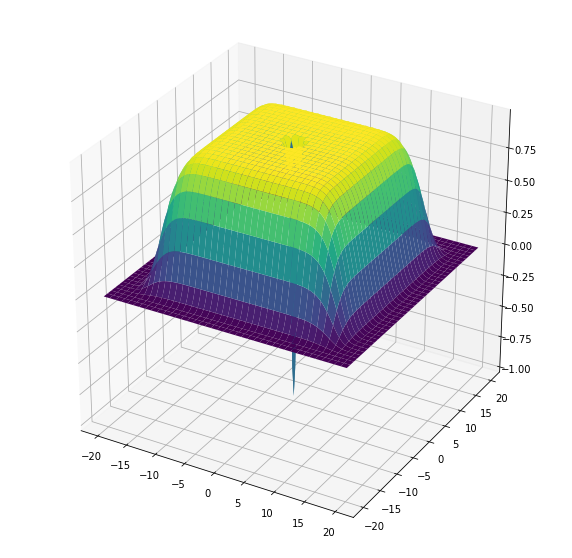

In [27]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
#ax.view_init(20,30)
# Calc Data
X, Y = np.arange(-20, 20.1, 0.25), np.arange(-20, 20.1, 0.25)
X2,Y2 = np.meshgrid(X, Y)
XY = np.dstack(((X2, Y2)))
Z = np.array(calc_z(XY))
# Plot Surface
surf = ax.plot_surface(X2, Y2, Z,cmap='viridis', linewidth=0, antialiased=True)

### **α) Ανάλυση του γραφήματος**:

Για ακραίες τιμές του πεδίου ορισμού μηδενίζεται, όσο το ζέυγος(x,y) απομακρύνεται από ακραίες τιμές παρατηρούμε άυξηση της f. Αυτή η αύξηση συνεχίζεται μέχρι περίπου |x|<10 και |y|<10 όπου παρατηρούμε περίπου μέγιστες τιμές(η άυξηση έπειτα είναι πολύ μικρή). 
'Ομως, για κοντινές τιμές στο (0,0) παρατηρούμε αντίστροφη πορεία όσο (x,y) -> (0,0) με πολύ πιο απότομη κλίση. Επίσης, κοντά στο (0,0) πατηρείται ολικό μέγιστο.
Συνοπτικά, το γράφημα μοιάζει με ένα βουνό με μία αρκετά μικρή αλλά με απότομη κλίση τρύπα-κοιλάδα στην μέση.

### **β) Έυρεση βέλτιστου γενετικού αλγορίθμου και βέλτιστης τιμής για *2 διαστάσεις***:

Για τον **γενετικό αλγόριθμο** επιλέξαμε αρχικά τα εξής:  
Τελεστές:  
i. Διαστάυρωσης:  
    1. cxBlend, High -> alpha=0.6, Low -> alpha=0.3
    2. cxUniform, High -> indpb=0.6, Low -> indpb=0.3.
ii. Μετάλλαξης:
    1. mutGaussian, κοινά: mu = 0, sigma=0.1, High -> indpb=0.6 ,Low -> indpb=0.3 
    2. mutPolynomialBounded, κοινά: low=-21.0, up=21.0, High -> eta=40.0, indpb=0.6, Low -> eta=5.0, indpb=0.3
iii. Eπιλογής:
    1.  selTournament, High -> tournsize=10, Low -> tournsize=3

Στην συνέχεια, ακολουθούν οι κατάλληλες **αρχικοποιήσεις** για το **πρώτο βήμα** στην έυρεση βέλτιστου συνδυασμού (έλεγχος βάσει του **delta**):  

*(το κελί πρέπει να εκτελεστεί διότι αρχικοποιεί μεταβλητές αναγκαίες σε επόμενα κελιά)*

In [52]:
nVars = 2
POP = 200
MAX_ROUNDS = 10
MAX_GENS = 100
CX, MUT = 0.5, 0.4
M, L = 200, 250

OPs_ALGs = [["cxBlendHigh", "cxBlendLow", "cxUniformHigh", "cxUniformLow"], # crossover operators
            ["mutGaussianHigh", "mutGaussianLow", "mutPolynomialBoundedHigh", "mutPolynomialBoundedLow"], # mutate_operators
            ["selTournamentHigh", "selTournamentLow"], # selection operators
            ["eaSimple", "eaMuPLusLambda", "eaMuCommaLambda"] # Algorithms
           ]

**Αρχικές τιμές:**  
1. Πληθυσμός = 200, mu = 200 και lambda = 250  
2. Πιθανότητα διαστάυρωσης = 0.5  
3. Πιθανότητα μετάλλαξης = 0.4  


Τρέξαμε πρώτα για DELTA = 0, για να δούμε πόσο ακριβείς είναι οι συνδυασμό σε σχέση με την εύρεση του στόχου. Ο καλύτερος είχε 4 επιτυχίες και ακολούθησαν ακόμα περίπου 10 συνδυασμοί με 3 ή 2 επιτυχίες.  |
Στην συνέχεια, τρέξαμε για πολλές διαφορετικές τιμές DELTA, ώστε να δούμε γενικά πως διαφοροποιούνται τοι τιμές των σχετικών κριτηρίων.    
Συκεκριμένα για τις τιμές:  **[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]**    
**Πόρισμα:**  
Για DELTA = 0, ο καλύτερος συνδυασμός είχε 5 επιτυχίες (δεν ήταν μοναδικός).  
Για DELTA = 1.0, βλέπουμε μόνο επιτυχίες σε όλους τους συνδυασμούς.  
Για DELTA = 0.1 έως 0.9 παρατηρήσαμε παρόμοιες αποδόσεις από τους 5-10 καλύτερους συνδυασμούς σε κάθε περίπτωση. Επίσης από DELTA σε DELTA σε αυτό το έυρος τα αποτελέσματα ήταν παρόμοια, δηλαδή δεν βρέθηκε κάποιο DELTA που να ξεδιαλύνει κάπως την κατάσταση και να ξεχωρίζουν κάποιοι συνδυασμοί.  

Ο **λόγος** που έχουμε αυτά τα αποτελέσματα φαίνεται στο γράφημα της συνάρτησης:  
Για να επιτευχθεί fitness < 0 πρέπει να υπάρχει άτομο που να αντιστοιχεί σε σημείο μέσα στην "τρύπα" στο γράφημα και μάλιστα, αρκετά βαθιά.  
Η πιθανότητα ,όμως, τα άτομα να τείνουν προς τιμές στα άκρα είναι αρκετά μεγαλύτερη, διότι το κομμάτι του γραφήματος που ειναι ~0 αποτελεί ενά σημαντικό κομμάτι του πεδίου ορισμού και αρκετά μεγαλύτερο από αυτό που αντιστοιχεί στο τμήμα της τρύπας που έχει fitness <= 0.  
Για αυτό για DELTA < 1 δεν βλέπουμε αξιόλογες διαφορές στα αποτελέσματα, ενώ πχ για DELTA = 1.1, έχουμε σε πάρα πολλούς συνδυασμούς μόνο επιτυχίες.
Συνεπώς δεν υπάρχει λόγος να αυξήσουμε το DELTA πάνω από 1.0 διότι πια οι επιτυχίες που θα βλεπουμε δεν θα οφείλονται στην έυρεση σημείου κοντά στο ολικό ελάχιστο, αλλά στα άκρα του πεδίου ορισμού. 

Επομένως, για επόμενες εκτελέσεις και για το grιd search που έπεται θα χρησιμοποιηθεί **DELTA=0.1**. Πρώτον, επειδή δίνει καλύτερα αποτελέσματα από το DELTA=0 και επειδή είναι το μικρότερο από αυτά που ελέγξαμε (πέρα από το 0) που παράλληλα δίνει καλά αποτελέσματα και κοινά με άλλα DELTA στο έυρος 0.1 - 0.9.

Δυστυχώς, δεν είναι εφικτό σε αυτό το σημείο της αναζήτησης να βρεθεί DELTA τέτοιο ώστε να ξεχωρίζουν κάποιοι λίγοι συνδυασμοί που έχουν σχεδόν μόνο επιτυχίες. Ευελπίστουμε να το επιτύχουμε αυτό με το fine-tuning που θα ακολουθήσει.

**Ακολουθεί το block κώδικα για την εκτέλεση όλων των συνδυασμών για να πάρουμε αποτελέσματα για όλα τα DELTA που ελέγξαμε:**    
*(ο πίνακας που εμφανίζεται είναι ταξινομημένος κατά φθίνουσα σειρά βάσει successes και για ισοπαλίες κατά άυξουσα σειρά βάσει avg.min)*

In [ ]:
DELTAS = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8 ,0.9, 1.0]

all_infos = run_ga_and_show_results(numVariables=nVars, rounds=MAX_ROUNDS, gens=MAX_GENS, pop=POP,
               cx_pb=CX, mut_pb=MUT, mu=M, l=L, 
               opers_algs=OPs_ALGs, deltas=DELTAS, sort=True)

# joblib.dump(all_infos, "all_infos2_0-1.0.pkl")

In [181]:
all_infos = joblib.load("all_infos2_0-1.0.pkl")
DELTAS = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
for i in range(0, len(deltas)):
    print("DELTA = %f:" % deltas[i])
    #print(all_infos[i])
    show_results(all_infos[i], sort=True)

DELTA = 0.000000:


operators  \
33       cxBlendLow, mutGaussianLow, selTournamentLow   
44  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
46  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
8      cxBlendHigh, mutGaussianLow, selTournamentHigh   
1     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
43  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
20  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
10      cxBlendHigh, mutGaussianLow, selTournamentLow   
9       cxBlendHigh, mutGaussianLow, selTournamentLow   
14  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
7      cxBlendHigh, mutGaussianLow, selTournamentHigh   
25     cxBlendLow, mutGaussianHigh, selTournamentHigh   
40  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
35       cxBlendLow, mutGaussianLow, selTournamentLow   
12  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
16  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
38  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
5      cxBlendHigh, mutGaussianHigh, selTournamentLow   
13  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
18  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
22  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
32      cxBlendLow, mutGaussianLow, selTournamentHigh   
34       cxBlendLow, mutGaussianLow, selTournamentLow   
37  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
30      cxBlendLow, mutGaussianLow, selTournamentHigh   
4      cxBlendHigh, mutGaussianHigh, selTournamentLow   
21  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
2     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
19  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
24     cxBlendLow, mutGaussianHigh, selTournamentHigh   
26     cxBlendLow, mutGaussianHigh, selTournamentHigh   
42  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
45  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
53   cxUniformHigh, mutGaussianHigh, selTournamentLow   
85  cxUniformLow, mutPolynomialBoundedHigh, selTou...   
71  cxUniformHigh, mutPolynomialBoundedLow, selTou...   
82     cxUniformLow, mutGaussianLow, selTournamentLow   
79    cxUniformLow, mutGaussianLow, selTournamentHigh   
57    cxUniformHigh, mutGaussianLow, selTournamentLow   
88  cxUniformLow, mutPolynomialBoundedHigh, selTou...   
91  cxUniformLow, mutPolynomialBoundedLow, selTour...   
90  cxUniformLow, mutPolynomialBoundedLow, selTour...   
50  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
94  cxUniformLow, mutPolynomialBoundedLow, selTour...   
47  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
28      cxBlendLow, mutGaussianHigh, selTournamentLow   
56   cxUniformHigh, mutGaussianLow, selTournamentHigh   
55   cxUniformHigh, mutGaussianLow, selTournamentHigh   
83     cxUniformLow, mutGaussianLow, selTournamentLow   
72   cxUniformLow, mutGaussianHigh, selTournamentHigh   
52   cxUniformHigh, mutGaussianHigh, selTournamentLow   
81     cxUniformLow, mutGaussianLow, selTournamentLow   
73   cxUniformLow, mutGaussianHigh, selTournamentHigh   
58    cxUniformHigh, mutGaussianLow, selTournamentLow   
61  cxUniformHigh, mutPolynomialBoundedHigh, selTo...   
70  cxUniformHigh, mutPolynomialBoundedLow, selTou...   
23  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
93  cxUniformLow, mutPolynomialBoundedLow, selTour...   
17  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
41  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
80    cxUniformLow, mutGaussianLow, selTournamentHigh   
29      cxBlendLow, mutGaussianHigh, selTournamentLow   
39  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
95  cxUniformLow, mutPolynomialBoundedLow, selTour...   
65  cxUniformHigh, mutPolynomialBoundedHigh, selTo...   
68  cxUniformHigh, mutPolynomialBoundedLow, selTou...   
77    cxUniformLow, mutGaussianHigh, selTournamentLow   
78    cxUniformLow, mutGaussianLow, selTournamentHigh   
49  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
75    cxUniformLow, mutGaussianHigh, selTournamentLow 

DELTA = 0.050000:


operators  \
33       cxBlendLow, mutGaussianLow, selTournamentLow   
44  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
46  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
8      cxBlendHigh, mutGaussianLow, selTournamentHigh   
53   cxUniformHigh, mutGaussianHigh, selTournamentLow   
1     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
43  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
85  cxUniformLow, mutPolynomialBoundedHigh, selTou...   
20  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
35       cxBlendLow, mutGaussianLow, selTournamentLow   
10      cxBlendHigh, mutGaussianLow, selTournamentLow   
9       cxBlendHigh, mutGaussianLow, selTournamentLow   
14  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
7      cxBlendHigh, mutGaussianLow, selTournamentHigh   
25     cxBlendLow, mutGaussianHigh, selTournamentHigh   
40  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
12  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
82     cxUniformLow, mutGaussianLow, selTournamentLow   
79    cxUniformLow, mutGaussianLow, selTournamentHigh   
57    cxUniformHigh, mutGaussianLow, selTournamentLow   
88  cxUniformLow, mutPolynomialBoundedHigh, selTou...   
91  cxUniformLow, mutPolynomialBoundedLow, selTour...   
90  cxUniformLow, mutPolynomialBoundedLow, selTour...   
16  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
71  cxUniformHigh, mutPolynomialBoundedLow, selTou...   
38  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
50  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
94  cxUniformLow, mutPolynomialBoundedLow, selTour...   
47  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
5      cxBlendHigh, mutGaussianHigh, selTournamentLow   
13  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
18  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
22  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
32      cxBlendLow, mutGaussianLow, selTournamentHigh   
34       cxBlendLow, mutGaussianLow, selTournamentLow   
37  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
30      cxBlendLow, mutGaussianLow, selTournamentHigh   
28      cxBlendLow, mutGaussianHigh, selTournamentLow   
56   cxUniformHigh, mutGaussianLow, selTournamentHigh   
55   cxUniformHigh, mutGaussianLow, selTournamentHigh   
83     cxUniformLow, mutGaussianLow, selTournamentLow   
72   cxUniformLow, mutGaussianHigh, selTournamentHigh   
52   cxUniformHigh, mutGaussianHigh, selTournamentLow   
81     cxUniformLow, mutGaussianLow, selTournamentLow   
73   cxUniformLow, mutGaussianHigh, selTournamentHigh   
58    cxUniformHigh, mutGaussianLow, selTournamentLow   
61  cxUniformHigh, mutPolynomialBoundedHigh, selTo...   
70  cxUniformHigh, mutPolynomialBoundedLow, selTou...   
4      cxBlendHigh, mutGaussianHigh, selTournamentLow   
23  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
21  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
93  cxUniformLow, mutPolynomialBoundedLow, selTour...   
80    cxUniformLow, mutGaussianLow, selTournamentHigh   
2     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
39  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
95  cxUniformLow, mutPolynomialBoundedLow, selTour...   
68  cxUniformHigh, mutPolynomialBoundedLow, selTou...   
19  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
24     cxBlendLow, mutGaussianHigh, selTournamentHigh   
26     cxBlendLow, mutGaussianHigh, selTournamentHigh   
42  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
45  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
77    cxUniformLow, mutGaussianHigh, selTournamentLow   
78    cxUniformLow, mutGaussianLow, selTournamentHigh   
49  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
75    cxUniformLow, mutGaussianHigh, selTournamentLow   
87  cxUniformLow, mutPolynomialBoundedHigh, selTou...   
60  cxUniformHigh, mutPolynomialBoundedHigh, selTo...   
63  cxUniformHigh, mutPolynomialBoundedHigh, selTo...   
67  cxUniformHigh, mutPolynomialBoundedLow, selTou... 

DELTA = 0.100000:


operators  \
33       cxBlendLow, mutGaussianLow, selTournamentLow   
44  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
46  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
8      cxBlendHigh, mutGaussianLow, selTournamentHigh   
53   cxUniformHigh, mutGaussianHigh, selTournamentLow   
1     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
43  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
85  cxUniformLow, mutPolynomialBoundedHigh, selTou...   
20  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
35       cxBlendLow, mutGaussianLow, selTournamentLow   
10      cxBlendHigh, mutGaussianLow, selTournamentLow   
9       cxBlendHigh, mutGaussianLow, selTournamentLow   
14  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
71  cxUniformHigh, mutPolynomialBoundedLow, selTou...   
7      cxBlendHigh, mutGaussianLow, selTournamentHigh   
25     cxBlendLow, mutGaussianHigh, selTournamentHigh   
40  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
12  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
82     cxUniformLow, mutGaussianLow, selTournamentLow   
79    cxUniformLow, mutGaussianLow, selTournamentHigh   
57    cxUniformHigh, mutGaussianLow, selTournamentLow   
88  cxUniformLow, mutPolynomialBoundedHigh, selTou...   
91  cxUniformLow, mutPolynomialBoundedLow, selTour...   
90  cxUniformLow, mutPolynomialBoundedLow, selTour...   
16  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
38  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
50  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
94  cxUniformLow, mutPolynomialBoundedLow, selTour...   
47  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
5      cxBlendHigh, mutGaussianHigh, selTournamentLow   
13  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
18  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
22  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
32      cxBlendLow, mutGaussianLow, selTournamentHigh   
34       cxBlendLow, mutGaussianLow, selTournamentLow   
37  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
30      cxBlendLow, mutGaussianLow, selTournamentHigh   
28      cxBlendLow, mutGaussianHigh, selTournamentLow   
56   cxUniformHigh, mutGaussianLow, selTournamentHigh   
55   cxUniformHigh, mutGaussianLow, selTournamentHigh   
83     cxUniformLow, mutGaussianLow, selTournamentLow   
72   cxUniformLow, mutGaussianHigh, selTournamentHigh   
52   cxUniformHigh, mutGaussianHigh, selTournamentLow   
81     cxUniformLow, mutGaussianLow, selTournamentLow   
73   cxUniformLow, mutGaussianHigh, selTournamentHigh   
58    cxUniformHigh, mutGaussianLow, selTournamentLow   
61  cxUniformHigh, mutPolynomialBoundedHigh, selTo...   
70  cxUniformHigh, mutPolynomialBoundedLow, selTou...   
4      cxBlendHigh, mutGaussianHigh, selTournamentLow   
23  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
21  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
93  cxUniformLow, mutPolynomialBoundedLow, selTour...   
17  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
41  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
80    cxUniformLow, mutGaussianLow, selTournamentHigh   
2     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
39  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
95  cxUniformLow, mutPolynomialBoundedLow, selTour...   
68  cxUniformHigh, mutPolynomialBoundedLow, selTou...   
19  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
24     cxBlendLow, mutGaussianHigh, selTournamentHigh   
26     cxBlendLow, mutGaussianHigh, selTournamentHigh   
42  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
45  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
77    cxUniformLow, mutGaussianHigh, selTournamentLow   
78    cxUniformLow, mutGaussianLow, selTournamentHigh   
49  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
75    cxUniformLow, mutGaussianHigh, selTournamentLow   
87  cxUniformLow, mutPolynomialBoundedHigh, selTou...   
60  cxUniformHigh, mutPolynomialBoundedHigh, selTo... 

DELTA = 0.200000:


operators  \
33       cxBlendLow, mutGaussianLow, selTournamentLow   
44  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
46  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
8      cxBlendHigh, mutGaussianLow, selTournamentHigh   
53   cxUniformHigh, mutGaussianHigh, selTournamentLow   
1     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
43  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
85  cxUniformLow, mutPolynomialBoundedHigh, selTou...   
20  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
35       cxBlendLow, mutGaussianLow, selTournamentLow   
10      cxBlendHigh, mutGaussianLow, selTournamentLow   
9       cxBlendHigh, mutGaussianLow, selTournamentLow   
14  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
71  cxUniformHigh, mutPolynomialBoundedLow, selTou...   
7      cxBlendHigh, mutGaussianLow, selTournamentHigh   
25     cxBlendLow, mutGaussianHigh, selTournamentHigh   
40  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
12  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
82     cxUniformLow, mutGaussianLow, selTournamentLow   
79    cxUniformLow, mutGaussianLow, selTournamentHigh   
57    cxUniformHigh, mutGaussianLow, selTournamentLow   
88  cxUniformLow, mutPolynomialBoundedHigh, selTou...   
91  cxUniformLow, mutPolynomialBoundedLow, selTour...   
90  cxUniformLow, mutPolynomialBoundedLow, selTour...   
16  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
38  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
50  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
94  cxUniformLow, mutPolynomialBoundedLow, selTour...   
47  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
5      cxBlendHigh, mutGaussianHigh, selTournamentLow   
13  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
18  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
22  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
32      cxBlendLow, mutGaussianLow, selTournamentHigh   
34       cxBlendLow, mutGaussianLow, selTournamentLow   
37  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
30      cxBlendLow, mutGaussianLow, selTournamentHigh   
28      cxBlendLow, mutGaussianHigh, selTournamentLow   
56   cxUniformHigh, mutGaussianLow, selTournamentHigh   
55   cxUniformHigh, mutGaussianLow, selTournamentHigh   
83     cxUniformLow, mutGaussianLow, selTournamentLow   
72   cxUniformLow, mutGaussianHigh, selTournamentHigh   
52   cxUniformHigh, mutGaussianHigh, selTournamentLow   
81     cxUniformLow, mutGaussianLow, selTournamentLow   
73   cxUniformLow, mutGaussianHigh, selTournamentHigh   
58    cxUniformHigh, mutGaussianLow, selTournamentLow   
61  cxUniformHigh, mutPolynomialBoundedHigh, selTo...   
70  cxUniformHigh, mutPolynomialBoundedLow, selTou...   
4      cxBlendHigh, mutGaussianHigh, selTournamentLow   
17  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
23  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
21  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
93  cxUniformLow, mutPolynomialBoundedLow, selTour...   
41  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
80    cxUniformLow, mutGaussianLow, selTournamentHigh   
2     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
39  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
95  cxUniformLow, mutPolynomialBoundedLow, selTour...   
68  cxUniformHigh, mutPolynomialBoundedLow, selTou...   
19  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
24     cxBlendLow, mutGaussianHigh, selTournamentHigh   
26     cxBlendLow, mutGaussianHigh, selTournamentHigh   
42  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
45  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
77    cxUniformLow, mutGaussianHigh, selTournamentLow   
78    cxUniformLow, mutGaussianLow, selTournamentHigh   
49  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
75    cxUniformLow, mutGaussianHigh, selTournamentLow   
87  cxUniformLow, mutPolynomialBoundedHigh, selTou...   
60  cxUniformHigh, mutPolynomialBoundedHigh, selTo... 

DELTA = 0.300000:


operators  \
33       cxBlendLow, mutGaussianLow, selTournamentLow   
44  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
46  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
8      cxBlendHigh, mutGaussianLow, selTournamentHigh   
53   cxUniformHigh, mutGaussianHigh, selTournamentLow   
1     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
43  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
85  cxUniformLow, mutPolynomialBoundedHigh, selTou...   
20  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
35       cxBlendLow, mutGaussianLow, selTournamentLow   
10      cxBlendHigh, mutGaussianLow, selTournamentLow   
9       cxBlendHigh, mutGaussianLow, selTournamentLow   
14  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
71  cxUniformHigh, mutPolynomialBoundedLow, selTou...   
7      cxBlendHigh, mutGaussianLow, selTournamentHigh   
25     cxBlendLow, mutGaussianHigh, selTournamentHigh   
40  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
12  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
82     cxUniformLow, mutGaussianLow, selTournamentLow   
79    cxUniformLow, mutGaussianLow, selTournamentHigh   
57    cxUniformHigh, mutGaussianLow, selTournamentLow   
88  cxUniformLow, mutPolynomialBoundedHigh, selTou...   
91  cxUniformLow, mutPolynomialBoundedLow, selTour...   
90  cxUniformLow, mutPolynomialBoundedLow, selTour...   
16  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
38  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
50  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
94  cxUniformLow, mutPolynomialBoundedLow, selTour...   
47  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
5      cxBlendHigh, mutGaussianHigh, selTournamentLow   
13  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
18  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
22  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
32      cxBlendLow, mutGaussianLow, selTournamentHigh   
34       cxBlendLow, mutGaussianLow, selTournamentLow   
37  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
30      cxBlendLow, mutGaussianLow, selTournamentHigh   
28      cxBlendLow, mutGaussianHigh, selTournamentLow   
56   cxUniformHigh, mutGaussianLow, selTournamentHigh   
55   cxUniformHigh, mutGaussianLow, selTournamentHigh   
83     cxUniformLow, mutGaussianLow, selTournamentLow   
72   cxUniformLow, mutGaussianHigh, selTournamentHigh   
52   cxUniformHigh, mutGaussianHigh, selTournamentLow   
81     cxUniformLow, mutGaussianLow, selTournamentLow   
73   cxUniformLow, mutGaussianHigh, selTournamentHigh   
58    cxUniformHigh, mutGaussianLow, selTournamentLow   
61  cxUniformHigh, mutPolynomialBoundedHigh, selTo...   
70  cxUniformHigh, mutPolynomialBoundedLow, selTou...   
4      cxBlendHigh, mutGaussianHigh, selTournamentLow   
93  cxUniformLow, mutPolynomialBoundedLow, selTour...   
17  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
23  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
21  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
41  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
80    cxUniformLow, mutGaussianLow, selTournamentHigh   
2     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
29      cxBlendLow, mutGaussianHigh, selTournamentLow   
39  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
95  cxUniformLow, mutPolynomialBoundedLow, selTour...   
65  cxUniformHigh, mutPolynomialBoundedHigh, selTo...   
68  cxUniformHigh, mutPolynomialBoundedLow, selTou...   
19  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
24     cxBlendLow, mutGaussianHigh, selTournamentHigh   
26     cxBlendLow, mutGaussianHigh, selTournamentHigh   
42  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
45  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
77    cxUniformLow, mutGaussianHigh, selTournamentLow   
78    cxUniformLow, mutGaussianLow, selTournamentHigh   
49  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
75    cxUniformLow, mutGaussianHigh, selTournamentLow 

DELTA = 0.400000:


operators  \
33       cxBlendLow, mutGaussianLow, selTournamentLow   
44  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
46  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
8      cxBlendHigh, mutGaussianLow, selTournamentHigh   
53   cxUniformHigh, mutGaussianHigh, selTournamentLow   
1     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
43  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
85  cxUniformLow, mutPolynomialBoundedHigh, selTou...   
20  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
35       cxBlendLow, mutGaussianLow, selTournamentLow   
10      cxBlendHigh, mutGaussianLow, selTournamentLow   
9       cxBlendHigh, mutGaussianLow, selTournamentLow   
14  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
71  cxUniformHigh, mutPolynomialBoundedLow, selTou...   
7      cxBlendHigh, mutGaussianLow, selTournamentHigh   
25     cxBlendLow, mutGaussianHigh, selTournamentHigh   
40  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
12  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
82     cxUniformLow, mutGaussianLow, selTournamentLow   
79    cxUniformLow, mutGaussianLow, selTournamentHigh   
57    cxUniformHigh, mutGaussianLow, selTournamentLow   
88  cxUniformLow, mutPolynomialBoundedHigh, selTou...   
91  cxUniformLow, mutPolynomialBoundedLow, selTour...   
90  cxUniformLow, mutPolynomialBoundedLow, selTour...   
16  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
38  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
50  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
94  cxUniformLow, mutPolynomialBoundedLow, selTour...   
47  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
5      cxBlendHigh, mutGaussianHigh, selTournamentLow   
13  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
18  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
22  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
32      cxBlendLow, mutGaussianLow, selTournamentHigh   
34       cxBlendLow, mutGaussianLow, selTournamentLow   
37  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
30      cxBlendLow, mutGaussianLow, selTournamentHigh   
28      cxBlendLow, mutGaussianHigh, selTournamentLow   
56   cxUniformHigh, mutGaussianLow, selTournamentHigh   
55   cxUniformHigh, mutGaussianLow, selTournamentHigh   
83     cxUniformLow, mutGaussianLow, selTournamentLow   
72   cxUniformLow, mutGaussianHigh, selTournamentHigh   
52   cxUniformHigh, mutGaussianHigh, selTournamentLow   
81     cxUniformLow, mutGaussianLow, selTournamentLow   
73   cxUniformLow, mutGaussianHigh, selTournamentHigh   
58    cxUniformHigh, mutGaussianLow, selTournamentLow   
61  cxUniformHigh, mutPolynomialBoundedHigh, selTo...   
70  cxUniformHigh, mutPolynomialBoundedLow, selTou...   
4      cxBlendHigh, mutGaussianHigh, selTournamentLow   
23  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
21  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
93  cxUniformLow, mutPolynomialBoundedLow, selTour...   
17  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
65  cxUniformHigh, mutPolynomialBoundedHigh, selTo...   
41  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
80    cxUniformLow, mutGaussianLow, selTournamentHigh   
2     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
29      cxBlendLow, mutGaussianHigh, selTournamentLow   
39  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
95  cxUniformLow, mutPolynomialBoundedLow, selTour...   
68  cxUniformHigh, mutPolynomialBoundedLow, selTou...   
19  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
24     cxBlendLow, mutGaussianHigh, selTournamentHigh   
26     cxBlendLow, mutGaussianHigh, selTournamentHigh   
42  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
45  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
77    cxUniformLow, mutGaussianHigh, selTournamentLow   
78    cxUniformLow, mutGaussianLow, selTournamentHigh   
49  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
75    cxUniformLow, mutGaussianHigh, selTournamentLow 

DELTA = 0.500000:


operators  \
33       cxBlendLow, mutGaussianLow, selTournamentLow   
44  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
46  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
8      cxBlendHigh, mutGaussianLow, selTournamentHigh   
53   cxUniformHigh, mutGaussianHigh, selTournamentLow   
1     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
43  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
85  cxUniformLow, mutPolynomialBoundedHigh, selTou...   
20  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
35       cxBlendLow, mutGaussianLow, selTournamentLow   
10      cxBlendHigh, mutGaussianLow, selTournamentLow   
9       cxBlendHigh, mutGaussianLow, selTournamentLow   
14  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
71  cxUniformHigh, mutPolynomialBoundedLow, selTou...   
7      cxBlendHigh, mutGaussianLow, selTournamentHigh   
25     cxBlendLow, mutGaussianHigh, selTournamentHigh   
40  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
12  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
82     cxUniformLow, mutGaussianLow, selTournamentLow   
79    cxUniformLow, mutGaussianLow, selTournamentHigh   
57    cxUniformHigh, mutGaussianLow, selTournamentLow   
88  cxUniformLow, mutPolynomialBoundedHigh, selTou...   
91  cxUniformLow, mutPolynomialBoundedLow, selTour...   
90  cxUniformLow, mutPolynomialBoundedLow, selTour...   
16  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
38  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
50  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
94  cxUniformLow, mutPolynomialBoundedLow, selTour...   
47  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
5      cxBlendHigh, mutGaussianHigh, selTournamentLow   
13  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
18  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
22  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
32      cxBlendLow, mutGaussianLow, selTournamentHigh   
34       cxBlendLow, mutGaussianLow, selTournamentLow   
37  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
30      cxBlendLow, mutGaussianLow, selTournamentHigh   
28      cxBlendLow, mutGaussianHigh, selTournamentLow   
56   cxUniformHigh, mutGaussianLow, selTournamentHigh   
55   cxUniformHigh, mutGaussianLow, selTournamentHigh   
83     cxUniformLow, mutGaussianLow, selTournamentLow   
72   cxUniformLow, mutGaussianHigh, selTournamentHigh   
52   cxUniformHigh, mutGaussianHigh, selTournamentLow   
81     cxUniformLow, mutGaussianLow, selTournamentLow   
73   cxUniformLow, mutGaussianHigh, selTournamentHigh   
58    cxUniformHigh, mutGaussianLow, selTournamentLow   
61  cxUniformHigh, mutPolynomialBoundedHigh, selTo...   
70  cxUniformHigh, mutPolynomialBoundedLow, selTou...   
4      cxBlendHigh, mutGaussianHigh, selTournamentLow   
23  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
21  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
93  cxUniformLow, mutPolynomialBoundedLow, selTour...   
17  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
80    cxUniformLow, mutGaussianLow, selTournamentHigh   
29      cxBlendLow, mutGaussianHigh, selTournamentLow   
65  cxUniformHigh, mutPolynomialBoundedHigh, selTo...   
41  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
2     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
39  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
95  cxUniformLow, mutPolynomialBoundedLow, selTour...   
68  cxUniformHigh, mutPolynomialBoundedLow, selTou...   
19  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
24     cxBlendLow, mutGaussianHigh, selTournamentHigh   
26     cxBlendLow, mutGaussianHigh, selTournamentHigh   
42  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
45  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
77    cxUniformLow, mutGaussianHigh, selTournamentLow   
78    cxUniformLow, mutGaussianLow, selTournamentHigh   
49  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
75    cxUniformLow, mutGaussianHigh, selTournamentLow 

DELTA = 0.600000:


operators  \
33       cxBlendLow, mutGaussianLow, selTournamentLow   
44  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
46  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
8      cxBlendHigh, mutGaussianLow, selTournamentHigh   
53   cxUniformHigh, mutGaussianHigh, selTournamentLow   
1     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
43  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
85  cxUniformLow, mutPolynomialBoundedHigh, selTou...   
20  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
35       cxBlendLow, mutGaussianLow, selTournamentLow   
10      cxBlendHigh, mutGaussianLow, selTournamentLow   
9       cxBlendHigh, mutGaussianLow, selTournamentLow   
14  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
71  cxUniformHigh, mutPolynomialBoundedLow, selTou...   
7      cxBlendHigh, mutGaussianLow, selTournamentHigh   
25     cxBlendLow, mutGaussianHigh, selTournamentHigh   
40  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
12  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
82     cxUniformLow, mutGaussianLow, selTournamentLow   
79    cxUniformLow, mutGaussianLow, selTournamentHigh   
57    cxUniformHigh, mutGaussianLow, selTournamentLow   
88  cxUniformLow, mutPolynomialBoundedHigh, selTou...   
91  cxUniformLow, mutPolynomialBoundedLow, selTour...   
90  cxUniformLow, mutPolynomialBoundedLow, selTour...   
16  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
38  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
23  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
21  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
50  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
94  cxUniformLow, mutPolynomialBoundedLow, selTour...   
47  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
5      cxBlendHigh, mutGaussianHigh, selTournamentLow   
13  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
18  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
22  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
32      cxBlendLow, mutGaussianLow, selTournamentHigh   
34       cxBlendLow, mutGaussianLow, selTournamentLow   
37  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
30      cxBlendLow, mutGaussianLow, selTournamentHigh   
28      cxBlendLow, mutGaussianHigh, selTournamentLow   
56   cxUniformHigh, mutGaussianLow, selTournamentHigh   
55   cxUniformHigh, mutGaussianLow, selTournamentHigh   
83     cxUniformLow, mutGaussianLow, selTournamentLow   
72   cxUniformLow, mutGaussianHigh, selTournamentHigh   
52   cxUniformHigh, mutGaussianHigh, selTournamentLow   
81     cxUniformLow, mutGaussianLow, selTournamentLow   
73   cxUniformLow, mutGaussianHigh, selTournamentHigh   
58    cxUniformHigh, mutGaussianLow, selTournamentLow   
61  cxUniformHigh, mutPolynomialBoundedHigh, selTo...   
70  cxUniformHigh, mutPolynomialBoundedLow, selTou...   
4      cxBlendHigh, mutGaussianHigh, selTournamentLow   
93  cxUniformLow, mutPolynomialBoundedLow, selTour...   
17  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
41  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
80    cxUniformLow, mutGaussianLow, selTournamentHigh   
2     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
29      cxBlendLow, mutGaussianHigh, selTournamentLow   
39  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
65  cxUniformHigh, mutPolynomialBoundedHigh, selTo...   
95  cxUniformLow, mutPolynomialBoundedLow, selTour...   
68  cxUniformHigh, mutPolynomialBoundedLow, selTou...   
19  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
24     cxBlendLow, mutGaussianHigh, selTournamentHigh   
26     cxBlendLow, mutGaussianHigh, selTournamentHigh   
42  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
45  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
77    cxUniformLow, mutGaussianHigh, selTournamentLow   
78    cxUniformLow, mutGaussianLow, selTournamentHigh   
49  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
75    cxUniformLow, mutGaussianHigh, selTournamentLow 

DELTA = 0.700000:


operators  \
33       cxBlendLow, mutGaussianLow, selTournamentLow   
44  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
46  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
8      cxBlendHigh, mutGaussianLow, selTournamentHigh   
53   cxUniformHigh, mutGaussianHigh, selTournamentLow   
1     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
43  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
85  cxUniformLow, mutPolynomialBoundedHigh, selTou...   
20  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
35       cxBlendLow, mutGaussianLow, selTournamentLow   
10      cxBlendHigh, mutGaussianLow, selTournamentLow   
9       cxBlendHigh, mutGaussianLow, selTournamentLow   
14  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
71  cxUniformHigh, mutPolynomialBoundedLow, selTou...   
50  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
7      cxBlendHigh, mutGaussianLow, selTournamentHigh   
25     cxBlendLow, mutGaussianHigh, selTournamentHigh   
40  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
12  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
82     cxUniformLow, mutGaussianLow, selTournamentLow   
79    cxUniformLow, mutGaussianLow, selTournamentHigh   
57    cxUniformHigh, mutGaussianLow, selTournamentLow   
88  cxUniformLow, mutPolynomialBoundedHigh, selTou...   
91  cxUniformLow, mutPolynomialBoundedLow, selTour...   
90  cxUniformLow, mutPolynomialBoundedLow, selTour...   
16  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
38  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
94  cxUniformLow, mutPolynomialBoundedLow, selTour...   
23  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
21  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
41  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
29      cxBlendLow, mutGaussianHigh, selTournamentLow   
47  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
5      cxBlendHigh, mutGaussianHigh, selTournamentLow   
13  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
18  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
22  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
32      cxBlendLow, mutGaussianLow, selTournamentHigh   
34       cxBlendLow, mutGaussianLow, selTournamentLow   
37  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
30      cxBlendLow, mutGaussianLow, selTournamentHigh   
28      cxBlendLow, mutGaussianHigh, selTournamentLow   
56   cxUniformHigh, mutGaussianLow, selTournamentHigh   
55   cxUniformHigh, mutGaussianLow, selTournamentHigh   
83     cxUniformLow, mutGaussianLow, selTournamentLow   
72   cxUniformLow, mutGaussianHigh, selTournamentHigh   
52   cxUniformHigh, mutGaussianHigh, selTournamentLow   
81     cxUniformLow, mutGaussianLow, selTournamentLow   
73   cxUniformLow, mutGaussianHigh, selTournamentHigh   
58    cxUniformHigh, mutGaussianLow, selTournamentLow   
61  cxUniformHigh, mutPolynomialBoundedHigh, selTo...   
70  cxUniformHigh, mutPolynomialBoundedLow, selTou...   
4      cxBlendHigh, mutGaussianHigh, selTournamentLow   
93  cxUniformLow, mutPolynomialBoundedLow, selTour...   
17  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
80    cxUniformLow, mutGaussianLow, selTournamentHigh   
2     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
39  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
95  cxUniformLow, mutPolynomialBoundedLow, selTour...   
65  cxUniformHigh, mutPolynomialBoundedHigh, selTo...   
15  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
68  cxUniformHigh, mutPolynomialBoundedLow, selTou...   
19  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
24     cxBlendLow, mutGaussianHigh, selTournamentHigh   
26     cxBlendLow, mutGaussianHigh, selTournamentHigh   
42  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
45  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
77    cxUniformLow, mutGaussianHigh, selTournamentLow   
78    cxUniformLow, mutGaussianLow, selTournamentHigh   
49  cxUniformHigh, mutGaussianHigh, selTournamentHigh 

DELTA = 0.800000:


operators  \
33       cxBlendLow, mutGaussianLow, selTournamentLow   
44  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
46  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
8      cxBlendHigh, mutGaussianLow, selTournamentHigh   
53   cxUniformHigh, mutGaussianHigh, selTournamentLow   
1     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
43  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
85  cxUniformLow, mutPolynomialBoundedHigh, selTou...   
20  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
35       cxBlendLow, mutGaussianLow, selTournamentLow   
10      cxBlendHigh, mutGaussianLow, selTournamentLow   
9       cxBlendHigh, mutGaussianLow, selTournamentLow   
14  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
71  cxUniformHigh, mutPolynomialBoundedLow, selTou...   
50  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
41  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
7      cxBlendHigh, mutGaussianLow, selTournamentHigh   
25     cxBlendLow, mutGaussianHigh, selTournamentHigh   
40  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
12  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
82     cxUniformLow, mutGaussianLow, selTournamentLow   
79    cxUniformLow, mutGaussianLow, selTournamentHigh   
57    cxUniformHigh, mutGaussianLow, selTournamentLow   
88  cxUniformLow, mutPolynomialBoundedHigh, selTou...   
91  cxUniformLow, mutPolynomialBoundedLow, selTour...   
90  cxUniformLow, mutPolynomialBoundedLow, selTour...   
16  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
38  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
94  cxUniformLow, mutPolynomialBoundedLow, selTour...   
47  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
23  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
21  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
29      cxBlendLow, mutGaussianHigh, selTournamentLow   
5      cxBlendHigh, mutGaussianHigh, selTournamentLow   
13  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
18  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
22  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
32      cxBlendLow, mutGaussianLow, selTournamentHigh   
34       cxBlendLow, mutGaussianLow, selTournamentLow   
37  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
30      cxBlendLow, mutGaussianLow, selTournamentHigh   
28      cxBlendLow, mutGaussianHigh, selTournamentLow   
56   cxUniformHigh, mutGaussianLow, selTournamentHigh   
55   cxUniformHigh, mutGaussianLow, selTournamentHigh   
83     cxUniformLow, mutGaussianLow, selTournamentLow   
72   cxUniformLow, mutGaussianHigh, selTournamentHigh   
52   cxUniformHigh, mutGaussianHigh, selTournamentLow   
81     cxUniformLow, mutGaussianLow, selTournamentLow   
73   cxUniformLow, mutGaussianHigh, selTournamentHigh   
58    cxUniformHigh, mutGaussianLow, selTournamentLow   
61  cxUniformHigh, mutPolynomialBoundedHigh, selTo...   
70  cxUniformHigh, mutPolynomialBoundedLow, selTou...   
4      cxBlendHigh, mutGaussianHigh, selTournamentLow   
93  cxUniformLow, mutPolynomialBoundedLow, selTour...   
17  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
80    cxUniformLow, mutGaussianLow, selTournamentHigh   
2     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
39  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
95  cxUniformLow, mutPolynomialBoundedLow, selTour...   
65  cxUniformHigh, mutPolynomialBoundedHigh, selTo...   
68  cxUniformHigh, mutPolynomialBoundedLow, selTou...   
15  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
59    cxUniformHigh, mutGaussianLow, selTournamentLow   
19  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
24     cxBlendLow, mutGaussianHigh, selTournamentHigh   
26     cxBlendLow, mutGaussianHigh, selTournamentHigh   
42  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
45  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
77    cxUniformLow, mutGaussianHigh, selTournamentLow   
78    cxUniformLow, mutGaussianLow, selTournamentHigh 

DELTA = 0.900000:


operators  \
71  cxUniformHigh, mutPolynomialBoundedLow, selTou...   
33       cxBlendLow, mutGaussianLow, selTournamentLow   
44  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
46  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
8      cxBlendHigh, mutGaussianLow, selTournamentHigh   
53   cxUniformHigh, mutGaussianHigh, selTournamentLow   
1     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
43  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
85  cxUniformLow, mutPolynomialBoundedHigh, selTou...   
20  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
35       cxBlendLow, mutGaussianLow, selTournamentLow   
10      cxBlendHigh, mutGaussianLow, selTournamentLow   
9       cxBlendHigh, mutGaussianLow, selTournamentLow   
14  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
50  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
47  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
41  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
7      cxBlendHigh, mutGaussianLow, selTournamentHigh   
25     cxBlendLow, mutGaussianHigh, selTournamentHigh   
40  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
12  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
82     cxUniformLow, mutGaussianLow, selTournamentLow   
79    cxUniformLow, mutGaussianLow, selTournamentHigh   
57    cxUniformHigh, mutGaussianLow, selTournamentLow   
88  cxUniformLow, mutPolynomialBoundedHigh, selTou...   
91  cxUniformLow, mutPolynomialBoundedLow, selTour...   
90  cxUniformLow, mutPolynomialBoundedLow, selTour...   
16  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
38  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
94  cxUniformLow, mutPolynomialBoundedLow, selTour...   
23  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
21  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
29      cxBlendLow, mutGaussianHigh, selTournamentLow   
5      cxBlendHigh, mutGaussianHigh, selTournamentLow   
13  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
18  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
22  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
32      cxBlendLow, mutGaussianLow, selTournamentHigh   
34       cxBlendLow, mutGaussianLow, selTournamentLow   
37  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
30      cxBlendLow, mutGaussianLow, selTournamentHigh   
28      cxBlendLow, mutGaussianHigh, selTournamentLow   
56   cxUniformHigh, mutGaussianLow, selTournamentHigh   
55   cxUniformHigh, mutGaussianLow, selTournamentHigh   
83     cxUniformLow, mutGaussianLow, selTournamentLow   
72   cxUniformLow, mutGaussianHigh, selTournamentHigh   
52   cxUniformHigh, mutGaussianHigh, selTournamentLow   
81     cxUniformLow, mutGaussianLow, selTournamentLow   
73   cxUniformLow, mutGaussianHigh, selTournamentHigh   
58    cxUniformHigh, mutGaussianLow, selTournamentLow   
61  cxUniformHigh, mutPolynomialBoundedHigh, selTo...   
70  cxUniformHigh, mutPolynomialBoundedLow, selTou...   
4      cxBlendHigh, mutGaussianHigh, selTournamentLow   
93  cxUniformLow, mutPolynomialBoundedLow, selTour...   
17  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
80    cxUniformLow, mutGaussianLow, selTournamentHigh   
2     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
39  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
95  cxUniformLow, mutPolynomialBoundedLow, selTour...   
65  cxUniformHigh, mutPolynomialBoundedHigh, selTo...   
68  cxUniformHigh, mutPolynomialBoundedLow, selTou...   
15  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
59    cxUniformHigh, mutGaussianLow, selTournamentLow   
11      cxBlendHigh, mutGaussianLow, selTournamentLow   
19  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
24     cxBlendLow, mutGaussianHigh, selTournamentHigh   
26     cxBlendLow, mutGaussianHigh, selTournamentHigh   
42  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
45  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
77    cxUniformLow, mutGaussianHigh, selTournamentLow 

DELTA = 1.000000:


operators  \
33       cxBlendLow, mutGaussianLow, selTournamentLow   
44  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
46  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
8      cxBlendHigh, mutGaussianLow, selTournamentHigh   
53   cxUniformHigh, mutGaussianHigh, selTournamentLow   
1     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
43  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
85  cxUniformLow, mutPolynomialBoundedHigh, selTou...   
20  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
35       cxBlendLow, mutGaussianLow, selTournamentLow   
10      cxBlendHigh, mutGaussianLow, selTournamentLow   
9       cxBlendHigh, mutGaussianLow, selTournamentLow   
14  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
71  cxUniformHigh, mutPolynomialBoundedLow, selTou...   
7      cxBlendHigh, mutGaussianLow, selTournamentHigh   
25     cxBlendLow, mutGaussianHigh, selTournamentHigh   
40  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
12  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
82     cxUniformLow, mutGaussianLow, selTournamentLow   
79    cxUniformLow, mutGaussianLow, selTournamentHigh   
57    cxUniformHigh, mutGaussianLow, selTournamentLow   
88  cxUniformLow, mutPolynomialBoundedHigh, selTou...   
91  cxUniformLow, mutPolynomialBoundedLow, selTour...   
90  cxUniformLow, mutPolynomialBoundedLow, selTour...   
16  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
38  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
50  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
94  cxUniformLow, mutPolynomialBoundedLow, selTour...   
47  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
5      cxBlendHigh, mutGaussianHigh, selTournamentLow   
13  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
18  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
22  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
32      cxBlendLow, mutGaussianLow, selTournamentHigh   
34       cxBlendLow, mutGaussianLow, selTournamentLow   
37  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
30      cxBlendLow, mutGaussianLow, selTournamentHigh   
28      cxBlendLow, mutGaussianHigh, selTournamentLow   
56   cxUniformHigh, mutGaussianLow, selTournamentHigh   
55   cxUniformHigh, mutGaussianLow, selTournamentHigh   
83     cxUniformLow, mutGaussianLow, selTournamentLow   
72   cxUniformLow, mutGaussianHigh, selTournamentHigh   
52   cxUniformHigh, mutGaussianHigh, selTournamentLow   
81     cxUniformLow, mutGaussianLow, selTournamentLow   
73   cxUniformLow, mutGaussianHigh, selTournamentHigh   
58    cxUniformHigh, mutGaussianLow, selTournamentLow   
61  cxUniformHigh, mutPolynomialBoundedHigh, selTo...   
70  cxUniformHigh, mutPolynomialBoundedLow, selTou...   
4      cxBlendHigh, mutGaussianHigh, selTournamentLow   
23  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
21  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
93  cxUniformLow, mutPolynomialBoundedLow, selTour...   
17  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
41  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
80    cxUniformLow, mutGaussianLow, selTournamentHigh   
2     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
29      cxBlendLow, mutGaussianHigh, selTournamentLow   
39  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
95  cxUniformLow, mutPolynomialBoundedLow, selTour...   
65  cxUniformHigh, mutPolynomialBoundedHigh, selTo...   
68  cxUniformHigh, mutPolynomialBoundedLow, selTou...   
19  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
24     cxBlendLow, mutGaussianHigh, selTournamentHigh   
26     cxBlendLow, mutGaussianHigh, selTournamentHigh   
42  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
45  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
77    cxUniformLow, mutGaussianHigh, selTournamentLow   
78    cxUniformLow, mutGaussianLow, selTournamentHigh   
49  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
75    cxUniformLow, mutGaussianHigh, selTournamentLow 

In [182]:
# Εμφάνιση των αποτελεσμάτων για DELTA=0.1
all_infos = joblib.load("all_infos2_0-1.0.pkl")
show_results(all_infos[1], sort=True)

operators  \
33       cxBlendLow, mutGaussianLow, selTournamentLow   
44  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
46  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
8      cxBlendHigh, mutGaussianLow, selTournamentHigh   
53   cxUniformHigh, mutGaussianHigh, selTournamentLow   
1     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
43  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
85  cxUniformLow, mutPolynomialBoundedHigh, selTou...   
20  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
35       cxBlendLow, mutGaussianLow, selTournamentLow   
10      cxBlendHigh, mutGaussianLow, selTournamentLow   
9       cxBlendHigh, mutGaussianLow, selTournamentLow   
14  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
7      cxBlendHigh, mutGaussianLow, selTournamentHigh   
25     cxBlendLow, mutGaussianHigh, selTournamentHigh   
40  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
12  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
82     cxUniformLow, mutGaussianLow, selTournamentLow   
79    cxUniformLow, mutGaussianLow, selTournamentHigh   
57    cxUniformHigh, mutGaussianLow, selTournamentLow   
88  cxUniformLow, mutPolynomialBoundedHigh, selTou...   
91  cxUniformLow, mutPolynomialBoundedLow, selTour...   
90  cxUniformLow, mutPolynomialBoundedLow, selTour...   
16  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
71  cxUniformHigh, mutPolynomialBoundedLow, selTou...   
38  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
50  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
94  cxUniformLow, mutPolynomialBoundedLow, selTour...   
47  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
5      cxBlendHigh, mutGaussianHigh, selTournamentLow   
13  cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
18  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
22  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
32      cxBlendLow, mutGaussianLow, selTournamentHigh   
34       cxBlendLow, mutGaussianLow, selTournamentLow   
37  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
30      cxBlendLow, mutGaussianLow, selTournamentHigh   
28      cxBlendLow, mutGaussianHigh, selTournamentLow   
56   cxUniformHigh, mutGaussianLow, selTournamentHigh   
55   cxUniformHigh, mutGaussianLow, selTournamentHigh   
83     cxUniformLow, mutGaussianLow, selTournamentLow   
72   cxUniformLow, mutGaussianHigh, selTournamentHigh   
52   cxUniformHigh, mutGaussianHigh, selTournamentLow   
81     cxUniformLow, mutGaussianLow, selTournamentLow   
73   cxUniformLow, mutGaussianHigh, selTournamentHigh   
58    cxUniformHigh, mutGaussianLow, selTournamentLow   
61  cxUniformHigh, mutPolynomialBoundedHigh, selTo...   
70  cxUniformHigh, mutPolynomialBoundedLow, selTou...   
4      cxBlendHigh, mutGaussianHigh, selTournamentLow   
23  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
21  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
93  cxUniformLow, mutPolynomialBoundedLow, selTour...   
80    cxUniformLow, mutGaussianLow, selTournamentHigh   
2     cxBlendHigh, mutGaussianHigh, selTournamentHigh   
39  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
95  cxUniformLow, mutPolynomialBoundedLow, selTour...   
68  cxUniformHigh, mutPolynomialBoundedLow, selTou...   
19  cxBlendHigh, mutPolynomialBoundedLow, selTourn...   
24     cxBlendLow, mutGaussianHigh, selTournamentHigh   
26     cxBlendLow, mutGaussianHigh, selTournamentHigh   
42  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
45  cxBlendLow, mutPolynomialBoundedLow, selTourna...   
77    cxUniformLow, mutGaussianHigh, selTournamentLow   
78    cxUniformLow, mutGaussianLow, selTournamentHigh   
49  cxUniformHigh, mutGaussianHigh, selTournamentHigh   
75    cxUniformLow, mutGaussianHigh, selTournamentLow   
87  cxUniformLow, mutPolynomialBoundedHigh, selTou...   
60  cxUniformHigh, mutPolynomialBoundedHigh, selTo...   
63  cxUniformHigh, mutPolynomialBoundedHigh, selTo...   
67  cxUniformHigh, mutPolynomialBoundedLow, selTou... 

Άλλο ένα πρόβλημα που παρατηρούμε, είναι ότι για επαναλαμβανόμενες εκτελέσεις για δεδομένα DELTA, τις πρώτες 2-3 θέσεις δεν καταλαμβάνουν πάντα οι ίδιοι συνδυασμοί. Οπότε για να επιλέξουμε κάποιους συνδυασμούς με τους οποίους θα προχωρήσουμε στο επόμενο βήμα θα κάνουμε το εξής:    
1. Θα τρέξουμε **10 φορές** την **run_ga()** μόνο για **DELTA=0.1**  
2. Θα κρατήσουμε τους **5 συνδυασμούς** που εμφανίζονται συχνότερα στις **5 πρώτες θέσεις** του ταξινομημένου πίνακα.
Επίσης, θα αφαιρέσουμε το cxUniform διότι δεν εμφανίζεται καθόλου στις πρώτες θέσεις.
Ακολουθεί η υλοποίηση αυτού σε συνάρτηση, που εκτελέστηκε για να πάρουμε τους καλύτερους συνδυασμούς:

In [38]:
nVars = 2
POP = 200
MAX_ROUNDS = 10
MAX_GENS = 100
CX, MUT = 0.5, 0.4
M, L = 200, 250 

OPs_ALGs = [["cxBlendHigh", "cxBlendLow"], # crossover operators
            ["mutGaussianHigh", "mutGaussianLow", "mutPolynomialBoundedHigh", "mutPolynomialBoundedLow"], # mutate_operators
            ["selTournamentHigh", "selTournamentLow"], # selection operators
            ["eaSimple", "eaMuPLusLambda", "eaMuCommaLambda"] # Algorithms
           ]

infos = get_5_best(0.1)   
joblib.dump(infos,"infos_best_5.pkl")

['cxBlendHigh, mutGaussianHigh, selTournamentHigh', 'eaSimple 200 0.50 0.40']
['cxBlendHigh, mutGaussianHigh, selTournamentHigh', 'eaMuPLusLambda 200 250 0.50 0.40']
['cxBlendHigh, mutGaussianHigh, selTournamentHigh', 'eaMuCommaLambda 200 250 0.50 0.40']
['cxBlendHigh, mutGaussianHigh, selTournamentLow', 'eaSimple 200 0.50 0.40']
['cxBlendHigh, mutGaussianHigh, selTournamentLow', 'eaMuPLusLambda 200 250 0.50 0.40']
['cxBlendHigh, mutGaussianHigh, selTournamentLow', 'eaMuCommaLambda 200 250 0.50 0.40']
['cxBlendHigh, mutGaussianLow, selTournamentHigh', 'eaSimple 200 0.50 0.40']
['cxBlendHigh, mutGaussianLow, selTournamentHigh', 'eaMuPLusLambda 200 250 0.50 0.40']
['cxBlendHigh, mutGaussianLow, selTournamentHigh', 'eaMuCommaLambda 200 250 0.50 0.40']
['cxBlendHigh, mutGaussianLow, selTournamentLow', 'eaSimple 200 0.50 0.40']
['cxBlendHigh, mutGaussianLow, selTournamentLow', 'eaMuPLusLambda 200 250 0.50 0.40']
['cxBlendHigh, mutGaussianLow, selTournamentLow', 'eaMuCommaLambda 200 250 0.50

['cxBlendLow, mutPolynomialBoundedLow, selTournamentLow', 'eaMuPLusLambda 200 250 0.50 0.40']
['cxBlendLow, mutPolynomialBoundedLow, selTournamentLow', 'eaMuCommaLambda 200 250 0.50 0.40']
['cxBlendHigh, mutGaussianHigh, selTournamentHigh', 'eaSimple 200 0.50 0.40']
['cxBlendHigh, mutGaussianHigh, selTournamentHigh', 'eaMuPLusLambda 200 250 0.50 0.40']
['cxBlendHigh, mutGaussianHigh, selTournamentHigh', 'eaMuCommaLambda 200 250 0.50 0.40']
['cxBlendHigh, mutGaussianHigh, selTournamentLow', 'eaSimple 200 0.50 0.40']
['cxBlendHigh, mutGaussianHigh, selTournamentLow', 'eaMuPLusLambda 200 250 0.50 0.40']
['cxBlendHigh, mutGaussianHigh, selTournamentLow', 'eaMuCommaLambda 200 250 0.50 0.40']
['cxBlendHigh, mutGaussianLow, selTournamentHigh', 'eaSimple 200 0.50 0.40']
['cxBlendHigh, mutGaussianLow, selTournamentHigh', 'eaMuPLusLambda 200 250 0.50 0.40']
['cxBlendHigh, mutGaussianLow, selTournamentHigh', 'eaMuCommaLambda 200 250 0.50 0.40']
['cxBlendHigh, mutGaussianLow, selTournamentLow', 'e

['cxBlendLow, mutPolynomialBoundedLow, selTournamentHigh', 'eaMuCommaLambda 200 250 0.50 0.40']
['cxBlendLow, mutPolynomialBoundedLow, selTournamentLow', 'eaSimple 200 0.50 0.40']
['cxBlendLow, mutPolynomialBoundedLow, selTournamentLow', 'eaMuPLusLambda 200 250 0.50 0.40']
['cxBlendLow, mutPolynomialBoundedLow, selTournamentLow', 'eaMuCommaLambda 200 250 0.50 0.40']
['cxBlendHigh, mutGaussianHigh, selTournamentHigh', 'eaSimple 200 0.50 0.40']
['cxBlendHigh, mutGaussianHigh, selTournamentHigh', 'eaMuPLusLambda 200 250 0.50 0.40']
['cxBlendHigh, mutGaussianHigh, selTournamentHigh', 'eaMuCommaLambda 200 250 0.50 0.40']
['cxBlendHigh, mutGaussianHigh, selTournamentLow', 'eaSimple 200 0.50 0.40']
['cxBlendHigh, mutGaussianHigh, selTournamentLow', 'eaMuPLusLambda 200 250 0.50 0.40']
['cxBlendHigh, mutGaussianHigh, selTournamentLow', 'eaMuCommaLambda 200 250 0.50 0.40']
['cxBlendHigh, mutGaussianLow, selTournamentHigh', 'eaSimple 200 0.50 0.40']
['cxBlendHigh, mutGaussianLow, selTournamentHig

['cxBlendLow, mutPolynomialBoundedLow, selTournamentHigh', 'eaSimple 200 0.50 0.40']
['cxBlendLow, mutPolynomialBoundedLow, selTournamentHigh', 'eaMuPLusLambda 200 250 0.50 0.40']
['cxBlendLow, mutPolynomialBoundedLow, selTournamentHigh', 'eaMuCommaLambda 200 250 0.50 0.40']
['cxBlendLow, mutPolynomialBoundedLow, selTournamentLow', 'eaSimple 200 0.50 0.40']
['cxBlendLow, mutPolynomialBoundedLow, selTournamentLow', 'eaMuPLusLambda 200 250 0.50 0.40']
['cxBlendLow, mutPolynomialBoundedLow, selTournamentLow', 'eaMuCommaLambda 200 250 0.50 0.40']
['cxBlendHigh, mutGaussianHigh, selTournamentHigh', 'eaSimple 200 0.50 0.40']
['cxBlendHigh, mutGaussianHigh, selTournamentHigh', 'eaMuPLusLambda 200 250 0.50 0.40']
['cxBlendHigh, mutGaussianHigh, selTournamentHigh', 'eaMuCommaLambda 200 250 0.50 0.40']
['cxBlendHigh, mutGaussianHigh, selTournamentLow', 'eaSimple 200 0.50 0.40']
['cxBlendHigh, mutGaussianHigh, selTournamentLow', 'eaMuPLusLambda 200 250 0.50 0.40']
['cxBlendHigh, mutGaussianHigh, 

['cxBlendLow, mutPolynomialBoundedHigh, selTournamentLow', 'eaMuPLusLambda 200 250 0.50 0.40']
['cxBlendLow, mutPolynomialBoundedHigh, selTournamentLow', 'eaMuCommaLambda 200 250 0.50 0.40']
['cxBlendLow, mutPolynomialBoundedLow, selTournamentHigh', 'eaSimple 200 0.50 0.40']
['cxBlendLow, mutPolynomialBoundedLow, selTournamentHigh', 'eaMuPLusLambda 200 250 0.50 0.40']
['cxBlendLow, mutPolynomialBoundedLow, selTournamentHigh', 'eaMuCommaLambda 200 250 0.50 0.40']
['cxBlendLow, mutPolynomialBoundedLow, selTournamentLow', 'eaSimple 200 0.50 0.40']
['cxBlendLow, mutPolynomialBoundedLow, selTournamentLow', 'eaMuPLusLambda 200 250 0.50 0.40']
['cxBlendLow, mutPolynomialBoundedLow, selTournamentLow', 'eaMuCommaLambda 200 250 0.50 0.40']
['cxBlendHigh, mutGaussianHigh, selTournamentHigh', 'eaSimple 200 0.50 0.40']
['cxBlendHigh, mutGaussianHigh, selTournamentHigh', 'eaMuPLusLambda 200 250 0.50 0.40']
['cxBlendHigh, mutGaussianHigh, selTournamentHigh', 'eaMuCommaLambda 200 250 0.50 0.40']
['cxB

['cxBlendLow, mutPolynomialBoundedHigh, selTournamentHigh', 'eaMuCommaLambda 200 250 0.50 0.40']
['cxBlendLow, mutPolynomialBoundedHigh, selTournamentLow', 'eaSimple 200 0.50 0.40']
['cxBlendLow, mutPolynomialBoundedHigh, selTournamentLow', 'eaMuPLusLambda 200 250 0.50 0.40']
['cxBlendLow, mutPolynomialBoundedHigh, selTournamentLow', 'eaMuCommaLambda 200 250 0.50 0.40']
['cxBlendLow, mutPolynomialBoundedLow, selTournamentHigh', 'eaSimple 200 0.50 0.40']
['cxBlendLow, mutPolynomialBoundedLow, selTournamentHigh', 'eaMuPLusLambda 200 250 0.50 0.40']
['cxBlendLow, mutPolynomialBoundedLow, selTournamentHigh', 'eaMuCommaLambda 200 250 0.50 0.40']
['cxBlendLow, mutPolynomialBoundedLow, selTournamentLow', 'eaSimple 200 0.50 0.40']
['cxBlendLow, mutPolynomialBoundedLow, selTournamentLow', 'eaMuPLusLambda 200 250 0.50 0.40']
['cxBlendLow, mutPolynomialBoundedLow, selTournamentLow', 'eaMuCommaLambda 200 250 0.50 0.40']
[[ 0  1]
 [ 1  1]
 [ 2  1]
 [ 4  3]
 [ 6  1]
 [ 7  1]
 [13  6]
 [19  2]
 [20  

['infos_best_5.pkl']

Από το παραπάνω κελί προκύπτουν οι εξης **συνδυασμοί**:  
1. cxBlendHigh,mutPolynomialBoundedHigh, selTournamentHigh   eaMuPLusLambda  200 250 0.50 0.40 **(freq= 6)**
2. cxBlendLow, mutPolynomialBoundedHigh, selTournamentHigh   eaMuPLusLambda  200 250 0.50 0.40 **(freq= 6)**
3. cxBlendLow, mutPolynomialBoundedHigh, selTournamentHigh   eaSimple 200 0.50 0.40            **(freq= 4)**
4. cxBlendLow, mutPolynomialBoundedHigh, selTournamentHigh   eaMuCommaLambda 150 220 0.50 0.20 **(freq= 3)**
5. cxBlendHigh,mutGaussianHigh,          selTournamentLow    eaMuPLusLambda  150 220 0.50 0.20 **(freq= 3)**

Θα κρατήσουμε τους 3 πρώτους συνδυασμούς για το επόμενο στάδιο.

**Βελτιστοποίηση πιθανοτήτων διασταύρωσης και μετάλλαξης:**

Για την βελτιστοποίση των πιθανοτήτων διαστάυρωση και μετάλλαξης, γράψαμε μία συνάρτηση **fine_tuning()** παρόμοια με την run_ga() με την διαφορά ότι αυτή πραγματοποιεί grid search για τα cx_pb, mut_pb.

**1ο run:**
Τρέχουμε την fine_tuning() για τους 5 διαφορετικούς συνδυασμούς που αναφέρονται παραπάνω και  για πιθανότητες διασταύρωσης : [0.05 , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] και για πιθανότητες μετάλλαξης: [0.05 , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9].  
Καλύτερα αποτελέσματα:  
1. cxBlendHigh, mutGaussianHigh, selTournamentLow 	eaMuPLusLambda 200 250 0.50 0.05 	
2. cxBlendHigh, mutPolynomialBoundedHigh, selTournamentHigh 	eaMuPLusLambda 200 250 0.70 0.30	
3. cxBlendLow, mutPolynomialBoundedHigh, selTournamentHigh 	eaMuPLusLambda 200 250 0.60 0.20

Παρατηρούμε ότι στις στις πρώτες θέσεις υπάρχει μόνο ο αλγόριθμος eaMuPlusLambda, οπότε θα κρατήσουμε τους συνδυασμούς που το έχουν. Όσον αφορά τις πιθανότητες, τα αποτελέσματα δεν είναι σαφής, οπότε θα ξανατρέξουμε για περίπου ίδιες πιθανότητες, με μόνη διαφορά ότι θα περιορίσουμε λίγο τα διαστήματα. Επίσης, θα αυξήσουμε τους γύρους στους 15, για να έχουμε πιο σαφή τελική εικόνα.  

**2o run:**
Τρέχουμε την fine_tuning()  για πιθανότητες διασταύρωσης : [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7] και για πιθανότητες μετάλλαξης: [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35] .
Καλύτερα αποτελέσματα: 
1. cxBlendHigh, mutPolynomialBoundedHigh, selTournamentHigh 	eaMuPLusLambda 200 250 **0.60 0.35**
2. cxBlendHigh, mutPolynomialBoundedHigh, selTournamentHigh 	eaMuPLusLambda 200 250 0.50 0.05
3. cxBlendLow, mutPolynomialBoundedHigh, selTournamentHigh 	eaMuPLusLambda 200 250 0.55 0.10  

Οπότε, ως τελικό συνδυασμό θα κρατήσουμε τον 1ο.

*Παρακάτω παρατίθεται ο κώδικας για το τελευταίο τρέξιμο της fine_tuning() με την έξοδο της.*

In [48]:
best_comp_ls = [["cxBlendHigh","mutPolynomialBoundedHigh", "selTournamentHigh", "eaMuPLusLambda"],
                ["cxBlendLow", "mutPolynomialBoundedHigh", "selTournamentHigh", "eaMuPLusLambda"],
                ["cxBlendHigh","mutGaussianHigh",          "selTournamentLow", "eaMuPLusLambda"]
               ]
cx_span = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]
mut_span =  [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]

infos = fine_tuning(2, best_comp_ls, pop=200, rounds=15, gens=100, mu=200, l=250, 
                    deltas=[0.1], cx_pbs=cx_span, mut_pbs=mut_span)

['cxBlendHigh, mutPolynomialBoundedHigh, selTournamentHigh', 'eaMuPLusLambda 200 250 0.20 0.05']
['cxBlendHigh, mutPolynomialBoundedHigh, selTournamentHigh', 'eaMuPLusLambda 200 250 0.20 0.10']
['cxBlendHigh, mutPolynomialBoundedHigh, selTournamentHigh', 'eaMuPLusLambda 200 250 0.20 0.15']
['cxBlendHigh, mutPolynomialBoundedHigh, selTournamentHigh', 'eaMuPLusLambda 200 250 0.20 0.20']
['cxBlendHigh, mutPolynomialBoundedHigh, selTournamentHigh', 'eaMuPLusLambda 200 250 0.20 0.25']
['cxBlendHigh, mutPolynomialBoundedHigh, selTournamentHigh', 'eaMuPLusLambda 200 250 0.20 0.30']
['cxBlendHigh, mutPolynomialBoundedHigh, selTournamentHigh', 'eaMuPLusLambda 200 250 0.20 0.35']
['cxBlendHigh, mutPolynomialBoundedHigh, selTournamentHigh', 'eaMuPLusLambda 200 250 0.25 0.05']
['cxBlendHigh, mutPolynomialBoundedHigh, selTournamentHigh', 'eaMuPLusLambda 200 250 0.25 0.10']
['cxBlendHigh, mutPolynomialBoundedHigh, selTournamentHigh', 'eaMuPLusLambda 200 250 0.25 0.15']
['cxBlendHigh, mutPolynomialBo

['cxBlendLow, mutPolynomialBoundedHigh, selTournamentHigh', 'eaMuPLusLambda 200 250 0.25 0.15']
['cxBlendLow, mutPolynomialBoundedHigh, selTournamentHigh', 'eaMuPLusLambda 200 250 0.25 0.20']
['cxBlendLow, mutPolynomialBoundedHigh, selTournamentHigh', 'eaMuPLusLambda 200 250 0.25 0.25']
['cxBlendLow, mutPolynomialBoundedHigh, selTournamentHigh', 'eaMuPLusLambda 200 250 0.25 0.30']
['cxBlendLow, mutPolynomialBoundedHigh, selTournamentHigh', 'eaMuPLusLambda 200 250 0.25 0.35']
['cxBlendLow, mutPolynomialBoundedHigh, selTournamentHigh', 'eaMuPLusLambda 200 250 0.30 0.05']
['cxBlendLow, mutPolynomialBoundedHigh, selTournamentHigh', 'eaMuPLusLambda 200 250 0.30 0.10']
['cxBlendLow, mutPolynomialBoundedHigh, selTournamentHigh', 'eaMuPLusLambda 200 250 0.30 0.15']
['cxBlendLow, mutPolynomialBoundedHigh, selTournamentHigh', 'eaMuPLusLambda 200 250 0.30 0.20']
['cxBlendLow, mutPolynomialBoundedHigh, selTournamentHigh', 'eaMuPLusLambda 200 250 0.30 0.25']
['cxBlendLow, mutPolynomialBoundedHigh, 

['cxBlendHigh, mutGaussianHigh, selTournamentLow', 'eaMuPLusLambda 200 250 0.35 0.05']
['cxBlendHigh, mutGaussianHigh, selTournamentLow', 'eaMuPLusLambda 200 250 0.35 0.10']
['cxBlendHigh, mutGaussianHigh, selTournamentLow', 'eaMuPLusLambda 200 250 0.35 0.15']
['cxBlendHigh, mutGaussianHigh, selTournamentLow', 'eaMuPLusLambda 200 250 0.35 0.20']
['cxBlendHigh, mutGaussianHigh, selTournamentLow', 'eaMuPLusLambda 200 250 0.35 0.25']
['cxBlendHigh, mutGaussianHigh, selTournamentLow', 'eaMuPLusLambda 200 250 0.35 0.30']
['cxBlendHigh, mutGaussianHigh, selTournamentLow', 'eaMuPLusLambda 200 250 0.35 0.35']
['cxBlendHigh, mutGaussianHigh, selTournamentLow', 'eaMuPLusLambda 200 250 0.40 0.05']
['cxBlendHigh, mutGaussianHigh, selTournamentLow', 'eaMuPLusLambda 200 250 0.40 0.10']
['cxBlendHigh, mutGaussianHigh, selTournamentLow', 'eaMuPLusLambda 200 250 0.40 0.15']
['cxBlendHigh, mutGaussianHigh, selTournamentLow', 'eaMuPLusLambda 200 250 0.40 0.20']
['cxBlendHigh, mutGaussianHigh, selTourname

In [49]:
# save info of 1st stage of fine-tuning
# joblib.dump(infos, "fine_tuning_2nd.pkl")
# save info of 1st stage of fine-tuning
infos = joblib.load("fine_tuning_2nd.pkl")

['fine_tuning_2nd.pkl']

In [50]:
for inf in infos:
    show_results(inf, sort=True)

operators  \
62   cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
42   cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
126  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
224     cxBlendHigh, mutGaussianHigh, selTournamentLow   
151  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
148  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
130  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
90   cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
204     cxBlendHigh, mutGaussianHigh, selTournamentLow   
223     cxBlendHigh, mutGaussianHigh, selTournamentLow   
50   cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
73   cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
200     cxBlendHigh, mutGaussianHigh, selTournamentLow   
150  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
32   cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
55   cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
146  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
26   cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
106  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
217     cxBlendHigh, mutGaussianHigh, selTournamentLow   
128  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
86   cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
202     cxBlendHigh, mutGaussianHigh, selTournamentLow   
175     cxBlendHigh, mutGaussianHigh, selTournamentLow   
206     cxBlendHigh, mutGaussianHigh, selTournamentLow   
195     cxBlendHigh, mutGaussianHigh, selTournamentLow   
58   cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
124  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
137  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
140  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
..                                                 ...   
166     cxBlendHigh, mutGaussianHigh, selTournamentLow   
11   cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
15   cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
29   cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
38   cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
39   cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
53   cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
143  cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
207     cxBlendHigh, mutGaussianHigh, selTournamentLow   
19   cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
27   cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
186     cxBlendHigh, mutGaussianHigh, selTournamentLow   
3    cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
181     cxBlendHigh, mutGaussianHigh, selTournamentLow   
176     cxBlendHigh, mutGaussianHigh, selTournamentLow   
164     cxBlendHigh, mutGaussianHigh, selTournamentLow   
89   cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
168     cxBlendHigh, mutGaussianHigh, selTournamentLow   
183     cxBlendHigh, mutGaussianHigh, selTournamentLow   
190     cxBlendHigh, mutGaussianHigh, selTournamentLow   
160     cxBlendHigh, mutGaussianHigh, selTournamentLow   
153     cxBlendHigh, mutGaussianHigh, selTournamentLow   
192     cxBlendHigh, mutGaussianHigh, selTournamentLow   
203     cxBlendHigh, mutGaussianHigh, selTournamentLow   
13   cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
6    cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
23   cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
4    cxBlendHigh, mutPolynomialBoundedHigh, selTour...   
84   cxBlendLow, mutPolynomialBoundedHigh, selTourn...   
157     cxBlendHigh, mutGaussianHigh, selTournamentLow   

                             strategy  successes  s.avg.min  s.avg.evals  \
62   eaMuPLusLambda 200 250 0.60 0.35          9  -0.961181       1151.0   
42   eaMuPLusLambda 200 250 0.50 0.05          9  -0.955437       1095.0   
126  eaMuPLusLambda 200 250 0.55 0.10          8  -0.976801        953.0   
224  eaMuPLusLambda 200 250 0.70 0.15          8  -0.946399       3441.0   
151  eaMuPLusLambda 200 250 0.70 0.30          7  -0.942017       13

**Τελική εκτέλεση:**

Τελεστές:
**cxBlendHigh 
mutPolynomialBoundedHigh
selTournamentHigh**  

Αλγόριθμος:
**eaMuPLusLambda** με **πιθανότητα διαστάυρωσης = 0.6** και **πιθανότητα μετάλλαξης = 0.35**

In [185]:
# Final execution for D=2 
tb_comp = ("cxBlendHigh", "mutPolynomialBoundedHigh", "selTournamentHigh", 2)
lb, total_time = M_plus_L(tb_comp, 500, 50, 500, 650, 0.6, 0.35)
print("Best value : ",np.amin(lb.select('min')))
print("Total evaluations : ",sum(lb.select('nevals')))
print("Execution time : ", total_time)

Best value :  -1.0
Total evaluations :  31348
Execution time :  3.678410768508911


### Για μεγαλύτερες διαστάσεις

Στην συνέχεια θα εκτελέσουμε τον αλγόριθμο για διαστάσεις: D = 1, 2, 5, 10, 20, 40:

In [93]:
D = [1, 2, 5, 10, 20, 40]
deltas = [0.1]
cx_pb = 0.6
mut_pb = 0.35

all_infos = []
for delta in deltas:
    all_infos.append([])
for d in D:
    print("Dimension = %d" % d)
    toolbox = ("cxBlendHigh" ,"mutPolynomialBoundedHigh" , "selTournamentHigh", d)
    infos = run_rounds_m_plus_l(toolbox, 500, 15, 100, 500, 600, cx_pb, mut_pb, deltas, True)
    for i in range(0,len(deltas)):
        all_infos[i].append([d]+infos[i])
    print(infos)
show_results(all_infos[0], sec_part=True)

Dimension = 1
[[15, -0.9935332201506045, 500, 1, 57492, -1.0, 12.196906264623006]]
Dimension = 2
[[9, -0.9499771113522841, 2270, 4, 57496, -0.5999999999999998, 11.861801211039225]]
Dimension = 5
[[0, None, None, None, 57496, 5.323841700258779e-21, 15.328473742802938]]
Dimension = 10
[[0, None, None, None, 57515, 2.6426614719194516e-34, 20.60772139231364]]
Dimension = 20
[[0, None, None, None, 57480, 6.24970760337577e-37, 26.944245020548504]]
Dimension = 40
[[0, None, None, None, 57514, 9.365909988951492e-59, 40.56898180643717]]


Dimensions  successes  avg.evals       avg.min   avg.time
0           1         15      57492 -1.000000e+00  12.196906
1           2          9      57496 -6.000000e-01  11.861801
2           5          0      57496  5.323842e-21  15.328474
3          10          0      57515  2.642661e-34  20.607721
4          20          0      57480  6.249708e-37  26.944245
5          40          0      57514  9.365910e-59  40.568982

In [94]:
# joblib.dump(all_infos[0], "ml_500_600_multiD_1_2_5_10_20_40.pkl")

#infos_from_file = joblib.load("multiD_1_2_5_10_20_40.pkl")
#show_results(infos_from_file, sec_part=True)

['ml_500_600_multiD_1_2_5_10_20_40.pkl']

Από τα παραπάνω αποτελέσματα παρατηρούμε, ότι για διαστάσεις μεγαλύτερες από 2 ο συνδυασμός που βρήκαμε αποτυγχάνει πλήρως. Θα τον εκτελέσουμε ξανά για μικρότερες διαστάσεις (1-8). Επίσης, θα αυξάνουμε εκθετικά τον πληθυσμό όσο ανεβαίνουμε διάσταση, για να αποφύγουμε το να έχουμε λίγα άτομα σε έναν μεγάλο N-χώρο.  
Θα μειώσουμς τις γενιές σε 20 διότι στις προηγούμενες εκτελέσεις είδαμε οτι χρειάζεται λιγότερες για να φτάσεις σε αποδεκτό άτομο. Επίσης θα μειώσουμε και τους γύρους σε 5, επειδή στην παρακάτω εκτέλεση μας νοιάζει να δούμε απλά αν κατάφερε να πάρει κάποια θεμιτά αποτελέσματα, και όχι γενικά την απόδοση του.  
Το κάνουμε αυτό, διότι αν δεν υπάρχουν καθόλου αποτελέσματα από μία διάσταση και πάνω (με αντίστοιχο εκθετικό πληθυσμό), τότε να επικεντρωθούμε κυρίως σε μικρότερες διαστάσεις.

*Ακολουθεί το αντίστοιχο block κώδικα:*

In [ ]:
D = [1, 2, 3, 4, 5]
deltas = [0.1]
cx_pb = 0.6
mut_pb = 0.35

all_infos = []
for delta in deltas:
    all_infos.append([])
for d in D:
    #tmp = 
    if d < 4:
        p = 20**d
    else:
        p = 8000*d
    print("Dimension = %d, Population = %d" % (d, p))
    toolbox = ("cxBlendHigh" ,"mutPolynomialBoundedHigh" , "selTournamentHigh", d)
    infos = run_rounds_m_plus_l(toolbox, p, 10, 20, p, int(p * 1.30), cx_pb, mut_pb, deltas, True)
    for i in range(0,len(deltas)):
        all_infos[i].append([d]+infos[i])
    all_infos.append([d]+infos[0])
    print(infos)

In [36]:
#joblib.dump(all_infos[0], "ml_20semiexp_multiD_1_2_3_4_5.pkl")
infos_from_file = joblib.load("ml_20semiexp_multiD_1_2_3_4_5.pkl")
show_results(infos_from_file, sec_part=True)

Dimensions  successes  avg.evals       avg.min    avg.time
0           1          9        515 -8.999459e-01    0.133916
1           2          5      10284 -5.000000e-01    2.588617
2           3          2     205613 -2.000000e-01   52.215917
3           4          1     822381 -9.999999e-02  216.591007
4           5          0    1027982  3.872553e-39  249.498430

**α)** Μελετώντας τους 2 πίνακες, μπορούμε να κάνουμε τις εξής διαπιστώσεις:
1. Η εικόνα που είχαμε από το προηγούμενο τρέξιμο δεν αλλάζει και για μικρότερες διαστάσεις. 
2. Ο συνδυασμός για D > 2 δεν μπορεί καν να πλησιάσει την βέλτιστη λύση με fixed πληθυσμό.
3. Με τον εκθετικά αυξανόμενο πληθυσμό, ομοίως έχουμε αντίστοιχα αποτελέσματα. Φαίνεται ότι έχουμε κάποιες επιτυχίες για D=3, 4, αλλά για D=5 ξανά μηδέν.
4. Έχουμε μόνο ένα successes για D=3 και μελετώντας την τιμή avg.min ,για την ίδια διάσταση, φαίνεται ότι σε όλους τους άλλους γύρους το καλύτερο ελάχιστο που βρήκε ήταν ~0.
5. Επίσης, το avg.min είναι παρόμοιο σε όλα τα runs για D > 4. Έχει πρακτικά τιμή 0 σε κάθε περίπτωση. Συνεπώς, όλα τα άτομα σε κάθε τρέξιμο, ανεξάρτητα την διάσταση, τείνουν προς ακραίες τιμές.

**β)** Αν και δεν έχουμε μικρό εύρος τιμών σε κάθε διασταση([-20, 20]), ο κύριος λόγος που χρειαζόμαστε μεγάλο πληθυσμό για να υπάρξει έστω και μία επιτυχία είναι η **"μορφολογία"** της συνάρτησης.  
Αρχικά, γενικά η συνάρτηση κρατάει την συμπεριφορά που έχει για 2 διαστάσεις. Δηλαδή, το ολικό ελάχιστο είναι στο (0,0,...,0) και μόνο πολύ κοντά σε αυτό η f έχει αρνητική τιμή, ενώ προς τις ακραίες θέσεις (πχ |X|> 15) η f οριακά μηδενίζεται.  Ανάμεσα σε αυτές τις περιοχές, η f είναι θετική.  

Επιπλέον, όσο αυξάνονται οι διαστάσεις, τόσο το περιθώριο γύρω από το (0,0,...,0) ,στο οποίο η f είναι αρνητική, μικραίνει. Αντίθετη συμπεριφορά παρατηρείται προς τις ακραίες τιμές, όσο αυξάνονται οι διαστάσεις, τόσο μεγαλώνει το περιθώριο στο οποίο η f σχεδόν μηδενίζεται. (τις παρατηρήσεις αυτές τις παρουσιάζουμε και εμπειρικά στο παρακάτω κελί).

Επομένως, ανεξάρτητα από τις διαστάσεις η κατανομή των ατομών αρχικά, όσο και μετά τις μεταλλάξεις-δτασταυρώσεις τείνει προς τα άκρα, δηλαδή η πιθανότητα να υπάρχει σημείο προς το άκρα ειναι σημαντικά μεγαλύτερη από ότι στην μικρή περιοχή που f < 0. Οπότε, αν δεν υπάρχει από εξαρχής τέτοιο σημείο στον πληθυσμό, τότε ο πληθυσμός τείνει προς ακριανές τιμές, εκτός και αν υπάρξει κάποιος απόγονος με fitness < 0.  

Και το πρόβλημα αυτό γίνεται ακόμα χειρότερο όσο αυξάνονται οι διαστάσεις, διότι όχι μόνο μικραίνει το εύρος που δίνει fitness < 0, αλλά αυξάνεται και η πιθανότητα τα άτομα να βρεθούν προς ακριανές θέσεις. 

*(ο κώδικας στο παρακάτω κελί παρουσιάζει αυτήν την κατάσταση)*

In [66]:
D = [2, 3, 4, 5, 10, 20]
X = [0.1, 0.2, 0.3, 0.4 ,13, 14]

for x in X:
    print("x = ", x)
    for d in D:
        y = f([x]*d)
        print("\tD=%d -> %f" % (d, y))

x =  0.1
	D=2 -> -0.921515
	D=3 -> -0.883435
	D=4 -> -0.846109
	D=5 -> -0.809524
	D=10 -> -0.637188
	D=20 -> -0.340192
x =  0.2
	D=2 -> -0.703369
	D=3 -> -0.571984
	D=4 -> -0.450733
	D=5 -> -0.338834
	D=10 -> 0.103761
	D=20 -> 0.598378
x =  0.3
	D=2 -> -0.391498
	D=3 -> -0.160670
	D=4 -> 0.031867
	D=5 -> 0.192465
	D=10 -> 0.673944
	D=20 -> 0.946844
x =  0.4
	D=2 -> -0.045224
	D=3 -> 0.244388
	D=4 -> 0.453754
	D=5 -> 0.605108
	D=10 -> 0.922030
	D=20 -> 0.996960
x =  13
	D=2 -> 0.619938
	D=3 -> 0.488116
	D=4 -> 0.384323
	D=5 -> 0.302601
	D=10 -> 0.091568
	D=20 -> 0.008385
x =  14
	D=2 -> 0.366695
	D=3 -> 0.222054
	D=4 -> 0.134466
	D=5 -> 0.081426
	D=10 -> 0.006630
	D=20 -> 0.000044


**γ)** Για να μειώσουμε (βελτιώσουμε) το **avg.min** πρέπει να δημιουργούνται άτομα που να βρίσκονται στην περιοχή όπου f < 0, ενώ παράλληλα πρέπει να αποφεύγεται το να κατευθύνεται η εξέλιξη προς τις ακραίες τιμές. Όμως, αυτό πρέπει να γίνει χωρίς cheats, δηλαδή χωρίς να επιδεικνύουμε στον γενετικό αλγόριθμο μία κατεύθυνση.  
Αυτό θα γίνει, αυξάνοντας την πιθανότητα να εμφανίζονται σε αυτήν την περιοχή. Μία πιθανή προσέγγιση είναι η **εκθετική αύξηση του πληθυσμού** για μεγαλύτερη διάσταση. Αυτό μπορεί να βελτιώσει τα αποτελέσματα επειδή θα έχουμε περισσότερα άτομα στον χώρο, άρα μία καλύτερη αρχική κατανομή και μεγαλύτερη πιθανότητα ένα από αυτά να βρεθεί με τα κατάλληλα χρωμοσώματα (συντεταγμένες) στην επιθυμητή περιοχή μετά πχ από μία διαστάυρωση ή ακόμα και από την αρχή.

### Βελτιστοποίηση σε μεγάλες διαστάσεις

Στην συνέχεια θα προσπαθήσουμε να βελτιώσουμε την απόδοση σε μεγαλύτερες διαστάσεις. Δυστυχώς, όπως και πριν δεν υπάρχει λόγος να ασχοληθούμε σημαντικά με το DELTA, διότι δεν βρίσκουμε περισσότερες επιτυχίες και όταν επηρρεάζει τα αποτελέσματα( DELTA > 1.00 ), όπως εξηγήσαμε προηγουμένως, αυτό ειναι παραπλανητικό (οι επιτυχίες οφείλονται σε τοπικά ελάχιστα μακριά απο το ολικό). Σε αυτό υπάρχει μόνο μία μικρή εξαίρεση, η οποία θα παρουσιαστεί παρακάτω. Παρακάτω, θα εξάγουμε αποτελέσματα για 0.1 και 0.9 delta.

### 1. 
Θα ασχοληθούμε εξαρχής με τον πληθυσμό και την αύξηση του, κρατώντας σταθερές τις γενιές στο 50.

Εξαιτίας των συμπερασμάτων που προέκυψαν στην προηγούμενη ενότητα, θα επιλέξουμε ως "μεγάλη" διάσταση εισόδου την **D = 3**. Θα μπορούσαμε να το προσπαθήσουμε και σε μεγαλύτερη διάσταση(πχ 4 ή 5) αλλά είναι αδύνατον από άποψη πόρων και χρόνου, λόγω του πολύ μεγάλου πληθυσμού που χρειάζεται.  
Στην συνέχεια θα προσπαθήσουμε να βελτιστοποιήσουμε τον αλγόριθμο με στόχο να φτάσει την απόδοση που έχουμε πετύχει στις 2 διαστάσεις εισόδου.  
 
**pop_base = 20^3 / 2**  
**pops = [pop_base, 2*pop_base, 3*pop_base, 4*pop_base, 5*pop_base, 10*pop_base, 20*pop_base]** <- Οι πληθυσμοί που ελέχθηκαν

*Ακολουθεί το block κώδικα για αυτό το run:*

In [72]:
D = [3]
deltas = [0, 0.1, 0.9]
pop_base = int(20**3 / 2)
pops = [pop_base, 2*pop_base, 3*pop_base, 4*pop_base, 5*pop_base, 10*pop_base, 20*pop_base]
cx_pb = 0.6
mut_pb = 0.35

all_infos = []
for delta in deltas:
    all_infos.append([])
for dim in D:
    for pop in pops:
        print("Population = ",pop)
        toolbox = ("cxBlendHigh" ,"mutPolynomialBoundedHigh" , "selTournamentHigh", dim)
        infos = run_rounds_m_plus_l(toolbox, pop, 15, 50, pop, int(pop * 1.20), cx_pb, mut_pb, deltas, True)
        for i in range(0,len(deltas)):
            all_infos[i].append([dim, pop]+infos[i])
        print(infos)

Population =  4000
[[2, -1.0, 134007, 29, 231991, -0.13333333333333333, 55.377706130345665], [2, -0.9595983759744275, 22262, 5, 231991, -0.13333333333333333, 55.377706130345665], [2, -0.7094144604323596, 8557, 2, 231991, -0.13333333333333333, 55.377706130345665]]
Population =  8000
[[4, -1.0, 306709, 33, 464037, -0.26666666666666666, 83.03426111539206], [4, -0.9630879769892282, 76436, 8, 464037, -0.26666666666666666, 83.03426111539206], [4, -0.6334339614931346, 51326, 5, 464037, -0.26666666666666666, 83.03426111539206]]
Population =  12000
[[4, -1.0, 425804, 31, 696033, -0.26666666666666666, 121.55255662600199], [4, -0.9482043674738072, 94009, 7, 696033, -0.26666666666666666, 121.55255662600199], [4, -0.2166558819888875, 18834, 1, 696033, -0.26666666666666666, 121.55255662600199]]
Population =  16000
[[5, -1.0, 566770, 31, 927958, -0.3333333333333333, 164.99120221138], [5, -0.97675677737653, 132686, 7, 927958, -0.3333333333333333, 164.99120221138], [5, -0.2646928305976716, 41520, 2, 92

In [165]:
#joblib.dump(all_infos, "diff_pop_dim_3.pkl")
all_infos = joblib.load("diff_pop_dim_3.pkl")
deltas = [0, 0.1, 0.9]
i = -1
for info in all_infos:
    i = i + 1
    print("Delta = %.2f" % deltas[i])
    show_results(info, thr_part=True)

Delta = 0.00


Dimensions  Population  successes  s.avg.min  s.avg.evals  s.avg.gens  \
0           3        4000          2       -1.0       134007          29   
1           3        8000          4       -1.0       306709          33   
2           3       12000          4       -1.0       425804          31   
3           3       16000          5       -1.0       566770          31   
4           3       20000         10       -1.0       708589          31   
5           3       40000         14       -1.0      1408221          31   
6           3       80000         14       -1.0      2718301          29   

   avg.evals   avg.min    avg.time  
0     231991 -0.133333   55.377706  
1     464037 -0.266667   83.034261  
2     696033 -0.266667  121.552557  
3     927958 -0.333333  164.991202  
4    1160038 -0.666667  206.541342  
5    2320275 -0.933333  421.553562  
6    4639916 -0.933333  858.339553

Delta = 0.10


Dimensions  Population  successes  s.avg.min  s.avg.evals  s.avg.gens  \
0           3        4000          2  -0.959598        22262           5   
1           3        8000          4  -0.963088        76436           8   
2           3       12000          4  -0.948204        94009           7   
3           3       16000          5  -0.976757       132686           7   
4           3       20000         10  -0.936291       143098           6   
5           3       40000         14  -0.942327       294060           6   
6           3       80000         14  -0.953689       523040           5   

   avg.evals   avg.min    avg.time  
0     231991 -0.133333   55.377706  
1     464037 -0.266667   83.034261  
2     696033 -0.266667  121.552557  
3     927958 -0.333333  164.991202  
4    1160038 -0.666667  206.541342  
5    2320275 -0.933333  421.553562  
6    4639916 -0.933333  858.339553

Delta = 0.90


Dimensions  Population  successes  s.avg.min  s.avg.evals  s.avg.gens  \
0           3        4000          2  -0.709414         8557           2   
1           3        8000          4  -0.633434        51326           5   
2           3       12000          4  -0.216656        18834           1   
3           3       16000          5  -0.264693        41520           2   
4           3       20000         10  -0.545015        70163           3   
5           3       40000         14  -0.395878        92130           2   
6           3       80000         14  -0.554199       145169           1   

   avg.evals   avg.min    avg.time  
0     231991 -0.133333   55.377706  
1     464037 -0.266667   83.034261  
2     696033 -0.266667  121.552557  
3     927958 -0.333333  164.991202  
4    1160038 -0.666667  206.541342  
5    2320275 -0.933333  421.553562  
6    4639916 -0.933333  858.339553

Παρακάτω κάνουμε ένα αντίστοιχο run (με λιγότερα rounds για εξοικονόμηση χρόνου: 15 -> 10) για 4 διαστάσεις εισόδου με ίδιους πληθυσμούς με αυτούς στις 3 διαστάσεις:

In [76]:
D = [4]
deltas = [0, 0.1, 0.9]
pop_base_3 = int(20**3 / 2)
pops = [pop_base_3, 2*pop_base_3, 3*pop_base_3, 4*pop_base_3, 5*pop_base_3, 10*pop_base_3, 20*pop_base_3]
cx_pb = 0.6
mut_pb = 0.35

all_infos = []
for delta in deltas:
    all_infos.append([])
for dim in D:
    for pop in pops:
        print("Population = ",pop)
        toolbox = ("cxBlendHigh" ,"mutPolynomialBoundedHigh" , "selTournamentHigh", dim)
        infos = run_rounds_m_plus_l(toolbox, pop, 10, 50, pop, int(pop * 1.20), cx_pb, mut_pb, deltas, True)
        for i in range(0,len(deltas)):
            all_infos[i].append([dim, pop]+infos[i])
        print(infos)

Population =  4000
[[0, None, None, None, 231954, 1.417978432331433e-31, 44.99267992973328], [0, None, None, None, 231954, 1.417978432331433e-31, 44.99267992973328], [0, None, None, None, 231954, 1.417978432331433e-31, 44.99267992973328]]
Population =  8000
[[0, None, None, None, 463983, 1.4179779616289492e-31, 87.51342809200287], [0, None, None, None, 463983, 1.4179779616289492e-31, 87.51342809200287], [0, None, None, None, 463983, 1.4179779616289492e-31, 87.51342809200287]]
Population =  12000
[[0, None, None, None, 695995, 1.4179782268840344e-31, 140.13415036201476], [0, None, None, None, 695995, 1.4179782268840344e-31, 140.13415036201476], [0, None, None, None, 695995, 1.4179782268840344e-31, 140.13415036201476]]
Population =  16000
[[0, None, None, None, 928055, 1.4179777821402703e-31, 193.9489986896515], [0, None, None, None, 928055, 1.4179777821402703e-31, 193.9489986896515], [0, None, None, None, 928055, 1.4179777821402703e-31, 193.9489986896515]]
Population =  20000
[[0, None,

In [162]:
#joblib.dump(all_infos, "diff_pop_dim_4.pkl")
all_infos = joblib.load("diff_pop_dim_4.pkl")
i = -1
deltas = [0, 0.1, 0.9]
for info in all_infos:
    i = i + 1
    print("Delta = %.2f:" % deltas[i])
    show_results(info, thr_part=True)

Delta = 0.00:


Dimensions  Population  successes  s.avg.min  s.avg.evals  s.avg.gens  \
0           4        4000          0        NaN          NaN         NaN   
1           4        8000          0        NaN          NaN         NaN   
2           4       12000          0        NaN          NaN         NaN   
3           4       16000          0        NaN          NaN         NaN   
4           4       20000          0        NaN          NaN         NaN   
5           4       40000          0        NaN          NaN         NaN   
6           4       80000          1       -1.0    3546152.0        39.0   

   avg.evals       avg.min    avg.time  
0     231954  1.417978e-31   44.992680  
1     463983  1.417978e-31   87.513428  
2     695995  1.417978e-31  140.134150  
3     928055  1.417978e-31  193.948999  
4    1159984  1.417978e-31  228.424464  
5    2319982  1.417978e-31  475.600068  
6    4640067 -1.000000e-01  945.784558

Delta = 0.10:


Dimensions  Population  successes  s.avg.min  s.avg.evals  s.avg.gens  \
0           4        4000          0        NaN          NaN         NaN   
1           4        8000          0        NaN          NaN         NaN   
2           4       12000          0        NaN          NaN         NaN   
3           4       16000          0        NaN          NaN         NaN   
4           4       20000          0        NaN          NaN         NaN   
5           4       40000          0        NaN          NaN         NaN   
6           4       80000          1  -0.916088     809603.0         9.0   

   avg.evals       avg.min    avg.time  
0     231954  1.417978e-31   44.992680  
1     463983  1.417978e-31   87.513428  
2     695995  1.417978e-31  140.134150  
3     928055  1.417978e-31  193.948999  
4    1159984  1.417978e-31  228.424464  
5    2319982  1.417978e-31  475.600068  
6    4640067 -1.000000e-01  945.784558

Delta = 0.90:


Dimensions  Population  successes  s.avg.min  s.avg.evals  s.avg.gens  \
0           4        4000          0        NaN          NaN         NaN   
1           4        8000          0        NaN          NaN         NaN   
2           4       12000          0        NaN          NaN         NaN   
3           4       16000          0        NaN          NaN         NaN   
4           4       20000          0        NaN          NaN         NaN   
5           4       40000          0        NaN          NaN         NaN   
6           4       80000          1  -0.516162     444834.0         5.0   

   avg.evals       avg.min    avg.time  
0     231954  1.417978e-31   44.992680  
1     463983  1.417978e-31   87.513428  
2     695995  1.417978e-31  140.134150  
3     928055  1.417978e-31  193.948999  
4    1159984  1.417978e-31  228.424464  
5    2319982  1.417978e-31  475.600068  
6    4640067 -1.000000e-01  945.784558

Παρατηρήσεις για τα αποτελέσματα στις 3 διαστάσεις:
1. Αυξάνοντας σημαντικά τον πληθυσμο έχουμε 14/15 successes ένα πάρα πολύ καλό ποσοστό σε σχέση με αυτό των μικρότερων πληθυσμών. Σηματική βελτίωση παρατηρούμε από πληθυσμό 20000 και πάνω. Όμως, η αύξηση του πληθυσμού πρέπει να είναι τουλάχιστον εκθετική => πολύ μεγάλοι χρόνοι σε μεγάλες διαστάσεις : D >= 4.
2. Παρατηρώντας τις τιμές για τα 3 διαφορετικά DELTA, καταλήγουμε σε ένα αρκετά ενδιαφέρον πόρισμα σχετικά με τον αριθμό των ελάχιστων γενεών που χρειάζονται για να υπάρξει επιτυχία. Αν και το DELTA δεν φαίνεται να επηρρεάζει τον αριθμό των επιτυχιών (όπως είχαμε πει και προηγουμένως), σε μέγάλους πληθυσμούς ένας επιπλέον λόγος για αυτό( πέρα από την μορφολογία της συνάρτησης) είναι ότι τρέχουμε για πολλές σχετικά γενιές(50).  
    Για population=40000, έχουμε: για delta=0 -> s.avg.gens=31, delta=0.1 -> s.avg.gens=6 και delta=0.9 -> s.avg.gens=2.
    Αυτό εξηγείται με τον αρκετά υψηλό πληθυσμό, διότι είναι πιο πιθανό να εμφανιστεί άτομο στην περιοχή με **fitness<0** σχετικά γρήγορα. Ενώ αν δεν εμφανιστεί, τα άτομα θα κινηθούν προς ανεπιθύμητα τοπικά ελάχιστα.  
    Ακριβώς για αυτό, βλέπουμε αρκετά μικρές τιμές στο **s.avg.gens** όταν υπάρχουν επιτυχίες σε υψηλά DELTA (τέτοια ώστε να έχουν νόημα οι επιτυχίες, δηλααδή όχι πάνω από 1.0).  
    **Συμπέρασμα:** Μόνο όταν υπάρξει τιμή με fitness < 0 σχετικά γρήγορα, μπορούμε να φτάσουμε μετά από αρκετές γενιές στο ολικό ελάχιστο (φαίνεται από τον ίδιο αριθμό επιτυχιών ανεξάρτητα το DELTA).Δηλαδή ,σε γενικές γραμμές, με τον συνδυασμό που τρέχουμε κρίνεται αρκετά γρήγορα η πορεία της εξέλιξης και το αν θα οδηγήσει ή όχι σε επιθυμητό αποτέλεσμα.
    
Για τα αποτελέσματα στις 4 διαστάσεις το μόνο που μπορούμε να θεωρήσουμε είναι ότι σίγουρα χρειαζόμαστε μεγαλύτερο πληθυσμό για να έχουμε καλά αποτελέσματα.

Στην συνέχεια, για να δούμε κιόλας αν επιβεβαιώνεται η 2η παρατήρηση θα τρέξουμε σε 4 διαστάσεις, με αντίστοιχα εκθετικό population. Δηλαδή:  
**pop_base = 20^4 / 2**  
**pops = [pop_base , 2 * pop_base, 4 * pop_base]**  
Όμως, για μικρότερες γενιές: 10

In [133]:
D = [4]
deltas = [0, 0.1, 0.9]
pop_base_4 = int(20**4 / 2)
pops = [pop_base_4, 2*pop_base_4, 4*pop_base_4, 8*pop_base_4]
cx_pb = 0.6
mut_pb = 0.35

all_infos = []
for delta in deltas:
    all_infos.append([])
for dim in D:
    for pop in pops:
        print("Population = ",pop)
        toolbox = ("cxBlendHigh" ,"mutPolynomialBoundedHigh" , "selTournamentHigh", dim)
        infos = run_rounds_m_plus_l(toolbox, pop, 10, 10, pop, int(pop * 1.20), cx_pb, mut_pb, deltas, True)
        for i in range(0,len(deltas)):
            all_infos[i].append([dim, pop]+infos[i])
        print(infos)

Population =  80000
[[0, None, None, None, 992012, 4.766204303397278e-31, 220.99670951366426], [0, None, None, None, 992012, 4.766204303397278e-31, 220.99670951366426], [0, None, None, None, 992012, 4.766204303397278e-31, 220.99670951366426]]
Population =  160000
[[0, None, None, None, 1984093, 3.392166487799334e-31, 360.75862350463865], [0, None, None, None, 1984093, 3.392166487799334e-31, 360.75862350463865], [0, None, None, None, 1984093, 3.392166487799334e-31, 360.75862350463865]]
Population =  320000
[[0, None, None, None, 3967923, -0.19949752356687492, 787.6022467374802], [2, -0.9383166800594582, 2690884, 7, 3967923, -0.19949752356687492, 787.6022467374802], [2, -0.5520970507412767, 684785, 2, 3967923, -0.19949752356687492, 787.6022467374802]]
Population =  640000
[[0, None, None, None, 7936088, -0.1982099375969746, 1503.990068078041], [2, -0.9632673160429486, 5382404, 7, 7936088, -0.1982099375969746, 1503.990068078041], [2, -0.5963155375266755, 640000, 1, 7936088, -0.19820993759

In [164]:
# joblib.dump(all_infos, "diff_pop_dim_4_second.pkl")
all_infos = joblib.load("diff_pop_dim_4_second.pkl")
i = -1
deltas = [0, 0.1, 0.9]
for info in all_infos:
    i = i + 1
    print("Delta = %.2f:" % deltas[i])
    show_results(info, thr_part=True)

Delta = 0.00:


Dimensions  Population  successes s.avg.min s.avg.evals s.avg.gens  \
0           4       80000          0      None        None       None   
1           4      160000          0      None        None       None   
2           4      320000          0      None        None       None   
3           4      640000          0      None        None       None   

   avg.evals       avg.min     avg.time  
0     992012  4.766204e-31   220.996710  
1    1984093  3.392166e-31   360.758624  
2    3967923 -1.994975e-01   787.602247  
3    7936088 -1.982099e-01  1503.990068

Delta = 0.10:


Dimensions  Population  successes  s.avg.min  s.avg.evals  s.avg.gens  \
0           4       80000          0        NaN          NaN         NaN   
1           4      160000          0        NaN          NaN         NaN   
2           4      320000          2  -0.938317    2690884.0         7.0   
3           4      640000          2  -0.963267    5382404.0         7.0   

   avg.evals       avg.min     avg.time  
0     992012  4.766204e-31   220.996710  
1    1984093  3.392166e-31   360.758624  
2    3967923 -1.994975e-01   787.602247  
3    7936088 -1.982099e-01  1503.990068

Delta = 0.90:


Dimensions  Population  successes  s.avg.min  s.avg.evals  s.avg.gens  \
0           4       80000          0        NaN          NaN         NaN   
1           4      160000          0        NaN          NaN         NaN   
2           4      320000          2  -0.552097     684785.0         2.0   
3           4      640000          2  -0.596316     640000.0         1.0   

   avg.evals       avg.min     avg.time  
0     992012  4.766204e-31   220.996710  
1    1984093  3.392166e-31   360.758624  
2    3967923 -1.994975e-01   787.602247  
3    7936088 -1.982099e-01  1503.990068

**Παρατηρήσεις:**
1. Από τις τιμές για **delta=0.9** επιβεβαιώνεται το συμπέρασμα, διότι σε κάθε περίπτωση που υπήρξε άτομο πολυ κοντά στο ολικό ελάχιστο, αυτό εμφανίστηκε αρκετά γρήγορα (< 4 γενιές).
2. Στις περιπτώσεις που έχουμε κάποιο καλό άτομο στην αρχή, τότε με το πέρασμα των γενεών η εξέλιξη κατευθύνεται επιτυχώς προς το ολικό ελάχιστο. Στον πίνακα για **delta=0.4**, φαίνεται αυτό λόγω του ότι σε επόμενες γενιές δημιουργούνται καλύτερα άτομα (**s.avg.gens = 7**). Εδώ δεν πήραμε επιτυχίες για μηδενικό delta επειδή το τρέξαμε για λίγες γενιές (<10).
3. Υπολογιστικά, το πρόβλημα για διαστάσεις **>= 4**, γίνεται υπερβολικά χρονοβόρο. Για πληθυσμό 640000, με μόνο 2 επιυχίες, και 10 γενιές κάθε γύρος χρειαζόταν **25 λεπτά**.


### 2.

Για το συγκεκριμένο ερώτημα, θα ασχολήθουμε με τις 3 διαστάσεις, διότι για 4 δεν είναι εφικτό σε έυλογο χρονικό διάστημα να πάρουμε μετρήσεις. Παρόλα αυτά, όπως δείξαμε παραπάνω σαν πρόβλημα είναι κάπως διαφορετικό από τις 2 διαστάσεις και μπορούμε να βγάλουμε χρήσιμα και ενδιαφέροντα πορίσματα σχετικά με την επιρροή του αριθμού των γενεών, του πληθυσμού και του DELTA.

Με 50 γενιές οποιαδήποτε μείωση του delta δεν αλλάζει την επιτυχία, η οποία κινείται κυρίως από **33% έως 90%+**. Η διακύμανση αυτή οφείλεται καθαρά στην αύξηση του πληθυσμού η οποία βελτιώνει και τα αποτελέσματα.  
Με άλλα λόγια, ο αριθμός των γενεών ήταν αρκετά μεγάλος ώστε να καταφέρει ο πληθυσμός να οδηγηθεί προς το ολικό ελάχιστο. 

Επίσης, βλέπουμε ότι αν είχαμε επιλέξει 20-30 γενιές για DELTA=0 θα είχαμε πολύ λιγότερες επιτυχίες. Όμως, από DELTA=0.1 και πάνω παρατηρούμε ότι θα διατηρούσαμε τον αριθμό των επιτυχιών που πετύχαμε ακόμα και αν μειώναμε περίπου στο 10 τον αριθμό των γενεών.

Συνεπώς, με ένα σχετικά μεγάλο αριθμό γενεών (30++) μπορούμε να αυξήσουμε τις επιτυχίες ακόμα και με μηδενικό DELTA, και να έχουμε παρόμοιες επιτυχίες για κάθε πιθανό DELTA στο εύρος [0, 1). Στο πρόβλημα μας, η χρήση του DELTA είναι μόνο χρήσιμη αν θέλουμε να τρέξουμε τον γενετικό αλγόριθμο για λίγες γενιές, ώστε να κάνουμε μία πρώιμη αξιολόγηση του σε μεγάλες διαστάσεις και πληθυσμούς. Διότι όπως αναφέραμε και προηγουμένως, αν βλέπουμε επιτυχίες με DELTA (πχ 0.5-0.9) μέσα σε λίγες γενιές, τότε είναι σχεδόν σίγουρο ότι αν αφήσουμε τον αλγόριθμο να τρέξει για αρκετές γενιές, στο τέλος θα καταφέρει να βρει το ολικό ελάχιστο.

Ακολουθεί μία τελευταία εκτέλεση του αλγορίθμου στις 3 διαστάσεις, με σκοπό να πάρουμε αποτελέσματα που να ξεκαθαρίζουν τον αριθμό των γενεών που χρειάζονται περίπου ώστε να έχουμε σημαντική αύξηση στις επιτυχίες μειώνοντας το DELTA, λαμβάνοντας παράλληλα υπόψιν τον πληθυσμό που χρησιμοποιούμε.  
Για να το πετύχουμε θα πάρουμε αναλυτικά μετρήσεις για τα DELTA = 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0  
και με πληθυσμό = 8000, 12000, 16000, 20000, 40000, 80000  
και με αριθμό γενεών = 50.  

In [169]:
D = [3]
deltas = [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
pops = [8000, 10000, 12000, 16000, 20000, 40000, 80000]
cx_pb = 0.6
mut_pb = 0.35

all_infos = []
for delta in deltas:
    all_infos.append([])
for dim in D:
    for pop in pops:
        print("Population = ",pop)
        toolbox = ("cxBlendHigh" ,"mutPolynomialBoundedHigh" , "selTournamentHigh", dim)
        infos = run_rounds_m_plus_l(toolbox, pop, 15, 50, pop, int(pop * 1.20), cx_pb, mut_pb, deltas, True)
        for i in range(0,len(deltas)):
            all_infos[i].append([dim, pop]+infos[i])
        print(infos)

Population =  8000
[[2, -1.0, 286324, 31, 464031, -0.13333333333333333, 89.33836251894633], [2, -0.9828688582701558, 71887, 8, 464031, -0.13333333333333333, 89.33836251894633], [2, -0.9489284660785867, 67319, 7, 464031, -0.13333333333333333, 89.33836251894633], [2, -0.8451782102849431, 53643, 6, 464031, -0.13333333333333333, 89.33836251894633], [2, -0.8451782102849431, 53643, 6, 464031, -0.13333333333333333, 89.33836251894633], [2, -0.6740853671407027, 44513, 5, 464031, -0.13333333333333333, 89.33836251894633], [2, -0.6286128134789696, 39936, 4, 464031, -0.13333333333333333, 89.33836251894633], [2, -0.6286128134789696, 39936, 4, 464031, -0.13333333333333333, 89.33836251894633], [2, -0.4856673566990356, 26261, 3, 464031, -0.13333333333333333, 89.33836251894633], [2, -0.4856673566990356, 26261, 3, 464031, -0.13333333333333333, 89.33836251894633], [2, -0.4856673566990356, 26261, 3, 464031, -0.13333333333333333, 89.33836251894633], [2, -0.2149270089824174, 17141, 2, 464031, -0.133333333333

In [170]:
joblib.dump(all_infos, "final_diff_pop_dim_3.pkl")
# all_infos = joblib.load("final_diff_pop_dim_3.pkl")
deltas = [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
i = -1
for info in all_infos:
    i = i + 1
    print("Delta = %.2f" % deltas[i])
    show_results(info, thr_part=True)

Delta = 0.00


Dimensions  Population  successes  s.avg.min  s.avg.evals  s.avg.gens  \
0           3        8000          2       -1.0       286324          31   
1           3       10000          5       -1.0       358904          31   
2           3       12000          4       -1.0       422387          31   
3           3       16000          6       -1.0       575272          31   
4           3       20000          7       -1.0       707087          31   
5           3       40000         12       -1.0      1434663          31   
6           3       80000         14       -1.0      2685605          29   

   avg.evals   avg.min    avg.time  
0     464031 -0.133333   89.338363  
1     580059 -0.333333  102.932847  
2     695938 -0.266667  122.383684  
3     928000 -0.400000  163.549459  
4    1159924 -0.523831  205.028350  
5    2320105 -0.800000  422.728171  
6    4639873 -0.933333  866.039503

Delta = 0.05


Dimensions  Population  successes  s.avg.min  s.avg.evals  s.avg.gens  \
0           3        8000          2  -0.982869        71887           8   
1           3       10000          5  -0.984022        71576           6   
2           3       12000          4  -0.971302        90649           6   
3           3       16000          6  -0.977558       149720           8   
4           3       20000          7  -0.980525       153520           6   
5           3       40000         12  -0.967601       324986           7   
6           3       80000         14  -0.976501       575116           6   

   avg.evals   avg.min    avg.time  
0     464031 -0.133333   89.338363  
1     580059 -0.333333  102.932847  
2     695938 -0.266667  122.383684  
3     928000 -0.400000  163.549459  
4    1159924 -0.523831  205.028350  
5    2320105 -0.800000  422.728171  
6    4639873 -0.933333  866.039503

Delta = 0.10


Dimensions  Population  successes  s.avg.min  s.avg.evals  s.avg.gens  \
0           3        8000          2  -0.948928        67319           7   
1           3       10000          5  -0.973046        67016           6   
2           3       12000          4  -0.936493        70118           5   
3           3       16000          6  -0.952664       140599           7   
4           3       20000          7  -0.950094       140493           6   
5           3       40000         12  -0.947450       298393           6   
6           3       80000         14  -0.946790       483917           5   

   avg.evals   avg.min    avg.time  
0     464031 -0.133333   89.338363  
1     580059 -0.333333  102.932847  
2     695938 -0.266667  122.383684  
3     928000 -0.400000  163.549459  
4    1159924 -0.523831  205.028350  
5    2320105 -0.800000  422.728171  
6    4639873 -0.933333  866.039503

Delta = 0.20


Dimensions  Population  successes  s.avg.min  s.avg.evals  s.avg.gens  \
0           3        8000          2  -0.845178        53643           6   
1           3       10000          5  -0.875146        53330           4   
2           3       12000          4  -0.888134        56441           4   
3           3       16000          6  -0.867398       113258           6   
4           3       20000          8  -0.882544       111201           5   
5           3       40000         12  -0.895640       248978           5   
6           3       80000         14  -0.862454       314545           3   

   avg.evals   avg.min    avg.time  
0     464031 -0.133333   89.338363  
1     580059 -0.333333  102.932847  
2     695938 -0.266667  122.383684  
3     928000 -0.400000  163.549459  
4    1159924 -0.523831  205.028350  
5    2320105 -0.800000  422.728171  
6    4639873 -0.933333  866.039503

Delta = 0.30


Dimensions  Population  successes  s.avg.min  s.avg.evals  s.avg.gens  \
0           3        8000          2  -0.845178        53643           6   
1           3       10000          5  -0.819600        48765           4   
2           3       12000          4  -0.865976        49601           3   
3           3       16000          6  -0.779134        88936           5   
4           3       20000          8  -0.859407       102660           4   
5           3       40000         12  -0.832139       210985           4   
6           3       80000         14  -0.815190       288486           3   

   avg.evals   avg.min    avg.time  
0     464031 -0.133333   89.338363  
1     580059 -0.333333  102.932847  
2     695938 -0.266667  122.383684  
3     928000 -0.400000  163.549459  
4    1159924 -0.523831  205.028350  
5    2320105 -0.800000  422.728171  
6    4639873 -0.933333  866.039503

Delta = 0.40


Dimensions  Population  successes  s.avg.min  s.avg.evals  s.avg.gens  \
0           3        8000          2  -0.674085        44513           5   
1           3       10000          5  -0.802780        46486           4   
2           3       12000          4  -0.790093        39339           3   
3           3       16000          6  -0.746825        85894           4   
4           3       20000          8  -0.787676        91253           4   
5           3       40000         12  -0.724620       154003           3   
6           3       80000         14  -0.768334       242876           2   

   avg.evals   avg.min    avg.time  
0     464031 -0.133333   89.338363  
1     580059 -0.333333  102.932847  
2     695938 -0.266667  122.383684  
3     928000 -0.400000  163.549459  
4    1159924 -0.523831  205.028350  
5    2320105 -0.800000  422.728171  
6    4639873 -0.933333  866.039503

Delta = 0.50


Dimensions  Population  successes  s.avg.min  s.avg.evals  s.avg.gens  \
0           3        8000          2  -0.628613        39936           4   
1           3       10000          5  -0.802780        46486           4   
2           3       12000          4  -0.790093        39339           3   
3           3       16000          6  -0.677317        76775           4   
4           3       20000          8  -0.694408        77007           3   
5           3       40000         12  -0.724620       154003           3   
6           3       80000         14  -0.734026       223336           2   

   avg.evals   avg.min    avg.time  
0     464031 -0.133333   89.338363  
1     580059 -0.333333  102.932847  
2     695938 -0.266667  122.383684  
3     928000 -0.400000  163.549459  
4    1159924 -0.523831  205.028350  
5    2320105 -0.800000  422.728171  
6    4639873 -0.933333  866.039503

Delta = 0.60


Dimensions  Population  successes  s.avg.min  s.avg.evals  s.avg.gens  \
0           3        8000          2  -0.628613        39936           4   
1           3       10000          5  -0.722007        39633           3   
2           3       12000          4  -0.790093        39339           3   
3           3       16000          6  -0.631099        67659           3   
4           3       20000          8  -0.642103        71314           3   
5           3       40000         12  -0.702741       150204           3   
6           3       80000         14  -0.709084       216829           2   

   avg.evals   avg.min    avg.time  
0     464031 -0.133333   89.338363  
1     580059 -0.333333  102.932847  
2     695938 -0.266667  122.383684  
3     928000 -0.400000  163.549459  
4    1159924 -0.523831  205.028350  
5    2320105 -0.800000  422.728171  
6    4639873 -0.933333  866.039503

Delta = 0.70


Dimensions  Population  successes  s.avg.min  s.avg.evals  s.avg.gens  \
0           3        8000          2  -0.485667        26261           3   
1           3       10000          5  -0.622668        32797           3   
2           3       12000          4  -0.646704        35927           2   
3           3       16000          6  -0.609466        64615           3   
4           3       20000          8  -0.597978        62762           2   
5           3       40000         12  -0.670064       131184           3   
6           3       80000         14  -0.626837       158168           1   

   avg.evals   avg.min    avg.time  
0     464031 -0.133333   89.338363  
1     580059 -0.333333  102.932847  
2     695938 -0.266667  122.383684  
3     928000 -0.400000  163.549459  
4    1159924 -0.523831  205.028350  
5    2320105 -0.800000  422.728171  
6    4639873 -0.933333  866.039503

Delta = 0.80


Dimensions  Population  successes  s.avg.min  s.avg.evals  s.avg.gens  \
0           3        8000          2  -0.485667        26261           3   
1           3       10000          5  -0.547687        30520           2   
2           3       12000          4  -0.646704        35927           2   
3           3       16000          6  -0.609466        64615           3   
4           3       20000          8  -0.528492        48496           2   
5           3       40000         12  -0.670064       131184           3   
6           3       80000         14  -0.586514       145136           1   

   avg.evals   avg.min    avg.time  
0     464031 -0.133333   89.338363  
1     580059 -0.333333  102.932847  
2     695938 -0.266667  122.383684  
3     928000 -0.400000  163.549459  
4    1159924 -0.523831  205.028350  
5    2320105 -0.800000  422.728171  
6    4639873 -0.933333  866.039503

Delta = 0.90


Dimensions  Population  successes  s.avg.min  s.avg.evals  s.avg.gens  \
0           3        8000          2  -0.485667        26261           3   
1           3       10000          5  -0.519898        25954           2   
2           3       12000          4  -0.487770        32504           2   
3           3       16000          6  -0.471451        49413           2   
4           3       20000          8  -0.528492        48496           2   
5           3       40000         12  -0.596309       119800           2   
6           3       80000         14  -0.537575       125603           1   

   avg.evals   avg.min    avg.time  
0     464031 -0.133333   89.338363  
1     580059 -0.333333  102.932847  
2     695938 -0.266667  122.383684  
3     928000 -0.400000  163.549459  
4    1159924 -0.523831  205.028350  
5    2320105 -0.800000  422.728171  
6    4639873 -0.933333  866.039503

Delta = 1.00


Dimensions  Population  successes  s.avg.min  s.avg.evals  s.avg.gens  \
0           3        8000          2  -0.214927        17141           2   
1           3       10000          5  -0.369187        16836           1   
2           3       12000          4  -0.249936        18840           1   
3           3       16000          6  -0.247305        31174           1   
4           3       20000          8  -0.301927        28545           1   
5           3       40000         12  -0.546446       108409           2   
6           3       80000         14  -0.537575       125603           1   

   avg.evals   avg.min    avg.time  
0     464031 -0.133333   89.338363  
1     580059 -0.333333  102.932847  
2     695938 -0.266667  122.383684  
3     928000 -0.400000  163.549459  
4    1159924 -0.523831  205.028350  
5    2320105 -0.800000  422.728171  
6    4639873 -0.933333  866.039503

Εδώ είναι πιο ξεκάθαρη η εικόνα, για το πως το DELTA μεταβάλει τις μετρήσεις (επιτυχίες και s.avg.gens). Για DELTA=1.0 βλέπουμε ότι το 2ο είναι 1 ή 2 κυρίως, ενώ όσο μικραίνει το DELTA ,παρατηρούμε ανάλογη αύξηση στο s.avg.gens με παράλληλη βελτίωση του s.avg.min. Μέχρι και το 0.05 δεν υπάρχει κάποια ακραία-μεγάλη αύξηση.  
Την μεγαλύτερη διαφορά παρατηρούμε από 0.05 σε 0, όπου το s.avg.gens από περίπου 7-8 κινείται στο 30-31. Επίσης, ο αριθμός γενεών = 50 είναι αρκετός για να μην έχουμε λιγότερο επιτυχίες αν επιλέξουμε DELTA=0 και αυτό ισχύει για κάθε περίπτωση πληθυσμού στις 3 διαστάσεις που ελέγξαμε.  
Δυστυχώς, λόγω ότι αυτές οι τιμές είναι mean, δεν μπορούμε να γνωρίζουμε μία ακριβή ελάχιστη αύξηση που χρειαζόμαστε για να έχουμε τα αποτελέσματα. Όμως, μπορούμε ασφαλώς να πούμε ότι **για να έχουμε τις μέγιστες δυνατές επιτυχίες με delta=0 φτάνει να αυξήσουμε τις γενιές περίπου στο 50, ενώ πχ για delta=0.5, φτάνουν 10-15 γενιές για να έχουμε το ίδιο ποσοστό επιτυχιών.**


*Παρακάτω τρέχουμε πάλι τον αλγόριθμο όπως πριν, αλλά με μέγιστο αριθμό γενεών = 10:*

In [174]:
D = [3]
deltas = [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
pops = [8000, 10000, 12000, 16000, 20000, 40000, 80000]
cx_pb = 0.6
mut_pb = 0.35

all_infos = []
for delta in deltas:
    all_infos.append([])
for dim in D:
    for pop in pops:
        print("Population = ",pop)
        toolbox = ("cxBlendHigh" ,"mutPolynomialBoundedHigh" , "selTournamentHigh", dim)
        infos = run_rounds_m_plus_l(toolbox, pop, 15, 5, pop, int(pop * 1.20), cx_pb, mut_pb, deltas, True)
        for i in range(0,len(deltas)):
            all_infos[i].append([dim, pop]+infos[i])
        print(infos)

Population =  8000
[[0, None, None, None, 53592, -0.2522928161361894, 8.922784264882406], [1, -0.971691008402926, 53547, 6, 53592, -0.2522928161361894, 8.922784264882406], [4, -0.9306378229443113, 44513, 5, 53592, -0.2522928161361894, 8.922784264882406], [4, -0.8937699575161651, 33123, 3, 53592, -0.2522928161361894, 8.922784264882406], [4, -0.8042341341180895, 28553, 3, 53592, -0.2522928161361894, 8.922784264882406], [4, -0.8042341341180895, 28553, 3, 53592, -0.2522928161361894, 8.922784264882406], [4, -0.8042341341180895, 28553, 3, 53592, -0.2522928161361894, 8.922784264882406], [4, -0.8042341341180895, 28553, 3, 53592, -0.2522928161361894, 8.922784264882406], [4, -0.8042341341180895, 28553, 3, 53592, -0.2522928161361894, 8.922784264882406], [4, -0.8042341341180895, 28553, 3, 53592, -0.2522928161361894, 8.922784264882406], [4, -0.6599996418796942, 19408, 2, 53592, -0.2522928161361894, 8.922784264882406], [4, -0.4797998028196333, 12565, 1, 53592, -0.2522928161361894, 8.922784264882406]

In [175]:
joblib.dump(all_infos, "final_diff_pop_dim_3_gens_5.pkl")
# all_infos = joblib.load("final_diff_pop_dim_3_gens_5.pkl")
deltas = [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
i = -1
for info in all_infos:
    i = i + 1
    print("Delta = %.2f" % deltas[i])
    show_results(info, thr_part=True)

Delta = 0.00


Dimensions  Population  successes s.avg.min s.avg.evals s.avg.gens  \
0           3        8000          0      None        None       None   
1           3       10000          0      None        None       None   
2           3       12000          0      None        None       None   
3           3       16000          0      None        None       None   
4           3       20000          0      None        None       None   
5           3       40000          0      None        None       None   
6           3       80000          0      None        None       None   

   avg.evals   avg.min   avg.time  
0      53592 -0.252293   8.922784  
1      67003 -0.201848  11.015766  
2      80368 -0.245383  13.285329  
3     107191 -0.469020  17.849239  
4     134018 -0.413581  22.329446  
5     268006 -0.519719  44.076067  
6     535992 -0.803027  87.348022

Delta = 0.05


Dimensions  Population  successes  s.avg.min  s.avg.evals  s.avg.gens  \
0           3        8000          1  -0.971691      53547.0         6.0   
1           3       10000          0        NaN          NaN         NaN   
2           3       12000          1  -0.953278      80368.0         6.0   
3           3       16000          2  -0.970693     107223.0         6.0   
4           3       20000          3  -0.956859     134011.0         6.0   
5           3       40000          6  -0.970107     214769.0         4.0   
6           3       80000          6  -0.971078     520691.0         5.0   

   avg.evals   avg.min   avg.time  
0      53592 -0.252293   8.922784  
1      67003 -0.201848  11.015766  
2      80368 -0.245383  13.285329  
3     107191 -0.469020  17.849239  
4     134018 -0.413581  22.329446  
5     268006 -0.519719  44.076067  
6     535992 -0.803027  87.348022

Delta = 0.10


Dimensions  Population  successes  s.avg.min  s.avg.evals  s.avg.gens  \
0           3        8000          4  -0.930638        44513           5   
1           3       10000          1  -0.941678        66948           6   
2           3       12000          3  -0.930049        75820           5   
3           3       16000          3  -0.962237       101142           5   
4           3       20000          5  -0.938088       124879           5   
5           3       40000          7  -0.964783       222392           5   
6           3       80000         10  -0.946257       490328           5   

   avg.evals   avg.min   avg.time  
0      53592 -0.252293   8.922784  
1      67003 -0.201848  11.015766  
2      80368 -0.245383  13.285329  
3     107191 -0.469020  17.849239  
4     134018 -0.413581  22.329446  
5     268006 -0.519719  44.076067  
6     535992 -0.803027  87.348022

Delta = 0.20


Dimensions  Population  successes  s.avg.min  s.avg.evals  s.avg.gens  \
0           3        8000          4  -0.893770        33123           3   
1           3       10000          3  -0.846246        63200           5   
2           3       12000          3  -0.852875        34775           2   
3           3       16000          6  -0.878642        95030           5   
4           3       20000          6  -0.851813        95999           4   
5           3       40000          7  -0.933820       209363           4   
6           3       80000         12  -0.896552       383976           4   

   avg.evals   avg.min   avg.time  
0      53592 -0.252293   8.922784  
1      67003 -0.201848  11.015766  
2      80368 -0.245383  13.285329  
3     107191 -0.469020  17.849239  
4     134018 -0.413581  22.329446  
5     268006 -0.519719  44.076067  
6     535992 -0.803027  87.348022

Delta = 0.30


Dimensions  Population  successes  s.avg.min  s.avg.evals  s.avg.gens  \
0           3        8000          4  -0.804234        28553           3   
1           3       10000          3  -0.809464        55599           5   
2           3       12000          3  -0.805865        30222           2   
3           3       16000          8  -0.830346        91249           5   
4           3       20000          6  -0.851813        95999           4   
5           3       40000          8  -0.874045       205288           4   
6           3       80000         13  -0.840281       353582           4   

   avg.evals   avg.min   avg.time  
0      53592 -0.252293   8.922784  
1      67003 -0.201848  11.015766  
2      80368 -0.245383  13.285329  
3     107191 -0.469020  17.849239  
4     134018 -0.413581  22.329446  
5     268006 -0.519719  44.076067  
6     535992 -0.803027  87.348022

Delta = 0.40


Dimensions  Population  successes  s.avg.min  s.avg.evals  s.avg.gens  \
0           3        8000          4  -0.804234        28553           3   
1           3       10000          3  -0.753939        44201           4   
2           3       12000          3  -0.771642        21116           1   
3           3       16000          8  -0.775013        84404           4   
4           3       20000          7  -0.781506        88410           4   
5           3       40000          8  -0.816377       176790           4   
6           3       80000         13  -0.766959       290446           3   

   avg.evals   avg.min   avg.time  
0      53592 -0.252293   8.922784  
1      67003 -0.201848  11.015766  
2      80368 -0.245383  13.285329  
3     107191 -0.469020  17.849239  
4     134018 -0.413581  22.329446  
5     268006 -0.519719  44.076067  
6     535992 -0.803027  87.348022

Delta = 0.50


Dimensions  Population  successes  s.avg.min  s.avg.evals  s.avg.gens  \
0           3        8000          4  -0.804234        28553           3   
1           3       10000          3  -0.753939        44201           4   
2           3       12000          4  -0.727279        35931           2   
3           3       16000          8  -0.690766        66151           3   
4           3       20000          7  -0.703859        68869           3   
5           3       40000          8  -0.660720       102710           2   
6           3       80000         13  -0.670694       199265           2   

   avg.evals   avg.min   avg.time  
0      53592 -0.252293   8.922784  
1      67003 -0.201848  11.015766  
2      80368 -0.245383  13.285329  
3     107191 -0.469020  17.849239  
4     134018 -0.413581  22.329446  
5     268006 -0.519719  44.076067  
6     535992 -0.803027  87.348022

Delta = 0.60


Dimensions  Population  successes  s.avg.min  s.avg.evals  s.avg.gens  \
0           3        8000          4  -0.804234        28553           3   
1           3       10000          3  -0.660196        36611           3   
2           3       12000          4  -0.727279        35931           2   
3           3       16000          8  -0.639898        63874           3   
4           3       20000          7  -0.703859        68869           3   
5           3       40000          8  -0.660720       102710           2   
6           3       80000         13  -0.618725       150158           1   

   avg.evals   avg.min   avg.time  
0      53592 -0.252293   8.922784  
1      67003 -0.201848  11.015766  
2      80368 -0.245383  13.285329  
3     107191 -0.469020  17.849239  
4     134018 -0.413581  22.329446  
5     268006 -0.519719  44.076067  
6     535992 -0.803027  87.348022

Delta = 0.70


Dimensions  Population  successes  s.avg.min  s.avg.evals  s.avg.gens  \
0           3        8000          4  -0.804234        28553           3   
1           3       10000          4  -0.444988        27107           2   
2           3       12000          4  -0.665328        29088           2   
3           3       16000          8  -0.639898        63874           3   
4           3       20000          7  -0.623243        59101           2   
5           3       40000          8  -0.633695        91299           2   
6           3       80000         13  -0.608970       136114           1   

   avg.evals   avg.min   avg.time  
0      53592 -0.252293   8.922784  
1      67003 -0.201848  11.015766  
2      80368 -0.245383  13.285329  
3     107191 -0.469020  17.849239  
4     134018 -0.413581  22.329446  
5     268006 -0.519719  44.076067  
6     535992 -0.803027  87.348022

Delta = 0.80


Dimensions  Population  successes  s.avg.min  s.avg.evals  s.avg.gens  \
0           3        8000          4  -0.804234        28553           3   
1           3       10000          4  -0.444988        27107           2   
2           3       12000          5  -0.489463        33886           2   
3           3       16000          8  -0.548119        57027           3   
4           3       20000          7  -0.623243        59101           2   
5           3       40000          9  -0.479491        85587           2   
6           3       80000         13  -0.578642       129101           1   

   avg.evals   avg.min   avg.time  
0      53592 -0.252293   8.922784  
1      67003 -0.201848  11.015766  
2      80368 -0.245383  13.285329  
3     107191 -0.469020  17.849239  
4     134018 -0.413581  22.329446  
5     268006 -0.519719  44.076067  
6     535992 -0.803027  87.348022

Delta = 0.90


Dimensions  Population  successes  s.avg.min  s.avg.evals  s.avg.gens  \
0           3        8000          4  -0.660000        19408           2   
1           3       10000          4  -0.403102        18550           1   
2           3       12000          5  -0.489463        33886           2   
3           3       16000          8  -0.449993        41058           2   
4           3       20000          7  -0.447595        33038           1   
5           3       40000          9  -0.408599        70398           1   
6           3       80000         13  -0.530649       122095           1   

   avg.evals   avg.min   avg.time  
0      53592 -0.252293   8.922784  
1      67003 -0.201848  11.015766  
2      80368 -0.245383  13.285329  
3     107191 -0.469020  17.849239  
4     134018 -0.413581  22.329446  
5     268006 -0.519719  44.076067  
6     535992 -0.803027  87.348022

Delta = 1.00


Dimensions  Population  successes  s.avg.min  s.avg.evals  s.avg.gens  \
0           3        8000          4  -0.479800        12565           1   
1           3       10000          4  -0.403102        18550           1   
2           3       12000          5  -0.454652        28412           2   
3           3       16000          8  -0.227636        27391           1   
4           3       20000          7  -0.447595        33038           1   
5           3       40000          9  -0.408599        70398           1   
6           3       80000         13  -0.518561       108064           1   

   avg.evals   avg.min   avg.time  
0      53592 -0.252293   8.922784  
1      67003 -0.201848  11.015766  
2      80368 -0.245383  13.285329  
3     107191 -0.469020  17.849239  
4     134018 -0.413581  22.329446  
5     268006 -0.519719  44.076067  
6     535992 -0.803027  87.348022

Από τα παραπάνω αποτελέσματα, δεν βλέπουμε κάτι νέο. Συμβαδίζουν με τις προηγούμενες μετρήσεις. Απλά εδώ επιβεβαιώνουμε ότι με χαμηλό αριθμό γενεών δεν μπορούμε να πετύχουμε σε καμμία περίπτωση το ολικό ελάχιστο και φαίνεται έντονα το πόσο βοηθάει στην αύξηση των επιτυχιών η χρήση ενός DELTA > 0.